In [1]:
!pip install -q segmentation-models-pytorch

In [2]:
import os
import pandas as pd
import numpy as np
import cv2
from torchvision.io import read_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torchvision.transforms import ToTensor
from PIL import Image
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
from torchvision import transforms
from torchinfo import summary
import timm

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
!nvidia-smi

Sun Nov 24 16:25:29 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, label_dir, resize=None, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.resize = resize
        self.transform = transform
        self.images = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.images)
    
    def read_mask(self, mask_path):
        image = cv2.imread(mask_path)
        image = cv2.resize(image, self.resize)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        lower1 = np.array([0, 100, 20])
        upper1 = np.array([10, 255, 255])

        lower2 = np.array([160,100,20])
        upper2 = np.array([179,255,255])
        lower_mask = cv2.inRange(image, lower1, upper1)
        upper_mask = cv2.inRange(image, lower2, upper2)
        
        red_mask = lower_mask + upper_mask;
        red_mask[red_mask != 0] = 1

        green_mask = cv2.inRange(image, (36, 25, 25), (70, 255, 255))
        green_mask[green_mask != 0] = 2

        full_mask = cv2.bitwise_or(red_mask, green_mask)
        full_mask = np.expand_dims(full_mask, axis=-1) 
        full_mask = full_mask.astype(np.uint8)
        
        return full_mask

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = cv2.imread(img_path)  # Đọc ảnh dưới dạng BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert sang RGB
        label = self.read_mask(label_path)  
        image = cv2.resize(image, self.resize)
        if self.transform:
            image = self.transform(image)
            
        return image, label

    def show_image(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = plt.imread(img_path)
        label = plt.imread(label_path)
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image)
        axs[0].set_title('Image')
        axs[1].imshow(label)
        axs[1].set_title('Label')
        plt.show()

In [5]:
image_path = []
TRAIN_DIR = '/kaggle/input/bkai-igh-neopolyp/train/train'
for root, dirs, files in os.walk(TRAIN_DIR):
    for file in files:
        path = os.path.join(root,file)
        image_path.append(path)
        
len(image_path)

1000

In [6]:
mask_path = []
TRAIN_MASK_DIR = '/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt'
for root, dirs, files in os.walk(TRAIN_MASK_DIR):
    for file in files:
        path = os.path.join(root,file)
        mask_path.append(path)
        
len(mask_path)

1000

In [7]:
dataset = CustomImageDataset(img_dir= TRAIN_DIR,
                             label_dir= TRAIN_MASK_DIR,
                             resize= (256,256),
                             transform = None)

In [8]:
import segmentation_models_pytorch as smp

model = smp.UnetPlusPlus(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=3     
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 87.7MB/s]


In [9]:
batch_size = 8
images_data = []
labels_data = []
for x,y in dataset:
    images_data.append(x)
    labels_data.append(y)

In [10]:
class CustomDataset(CustomImageDataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        image = self.data[index]
        label = self.targets[index]
        if self.transform:
            transformed = self.transform(image=image, mask=label)
            image = transformed['image'].float()
            label = transformed['mask'].float()
            label = label.permute(2, 0, 1)
        return image, label
    
    def __len__(self):
        return len(self.data)

    
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),
    A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

train_size = int(0.9 * len(images_data))
val_size = len(images_data) - train_size
train_dataset = CustomDataset(images_data[:train_size], labels_data[:train_size], transform=train_transform)
val_dataset = CustomDataset(images_data[train_size:], labels_data[train_size:], transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
print(len(train_dataset))
print(len(val_dataset))

900
100


/tmp/ipykernel_23/2144573044.py:24: UserWarning: Argument 'eps' is not valid and will be ignored.
  A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),


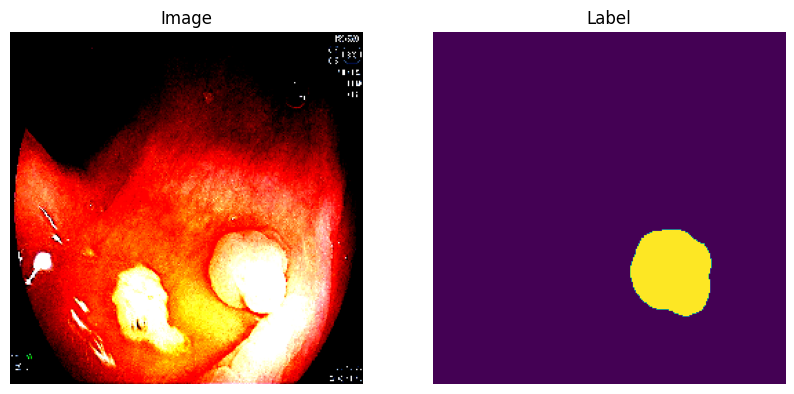

In [11]:
image,label = train_dataset[2]

label_array = label.permute(1, 2, 0).numpy()
image_array = image.permute(1, 2, 0).numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_array)
axs[0].set_title('Image')
axs[0].axis('off')  

axs[1].imshow(label_array)
axs[1].set_title('Label')
axs[1].axis('off')  

plt.show()

In [12]:
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
color_dict= {0: (0, 0, 0),
             1: (255, 0, 0),
             2: (0, 255, 0)}
def mask_to_rgb(mask, color_dict):
    output = np.zeros((mask.shape[0], mask.shape[1], 3))

    for k in color_dict.keys():
        output[mask==k] = color_dict[k]

    return np.uint8(output)    

In [14]:
!pip install wandb
import wandb
!wandb login 'd51fe1c5d8de52366edde886e7d46cbce99e9f64'

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [15]:
wandb.init(
    project = 'semantic-segmentation-BKAINeoPolyp'
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: anvu1204 (AnVH225467). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241124_162609-1o5lvp2i
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run bumbling-star-3
wandb: ⭐️ View project at https://wandb.ai/AnVH225467/semantic-segmentation-BKAINeoPolyp
wandb: 🚀 View run at https://wandb.ai/AnVH225467/semantic-segmentation-BKAINeoPolyp/runs/1o5lvp2i


Epoch [1/200], Loss: 0.7435893141
Save new model


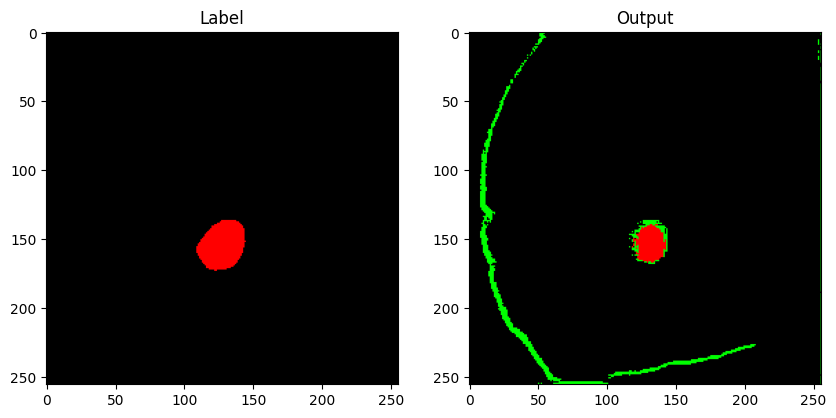

Epoch [2/200], Loss: 0.4325904709
Save new model


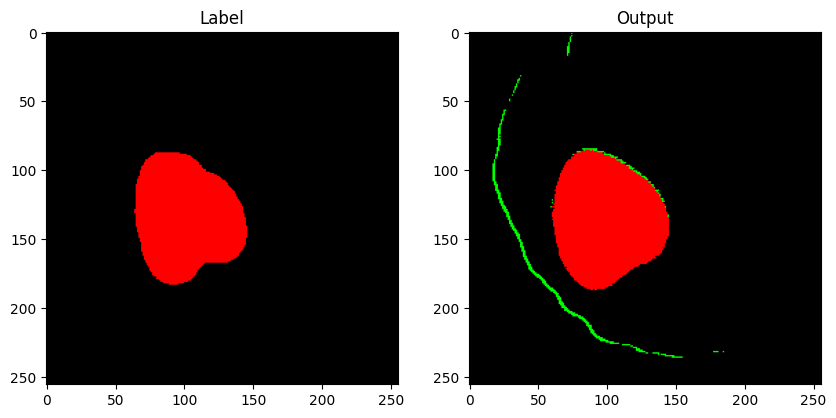

Epoch [3/200], Loss: 0.2501167907
Save new model


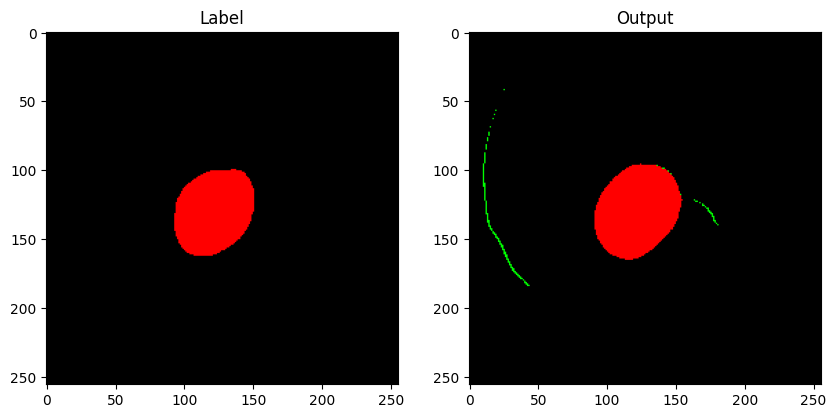

Epoch [4/200], Loss: 0.1644868644
Save new model


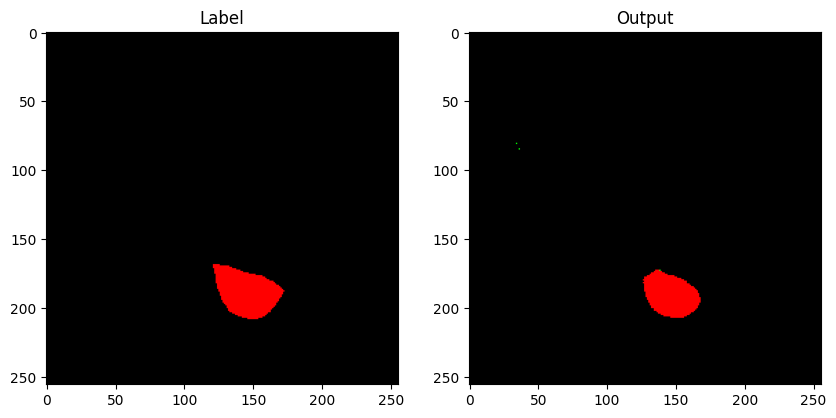

Epoch [5/200], Loss: 0.1249945324
Save new model


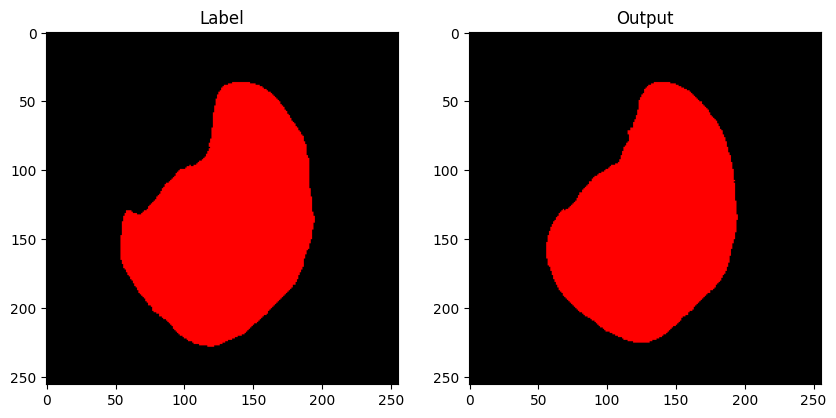

Epoch [6/200], Loss: 0.0910615107
Save new model


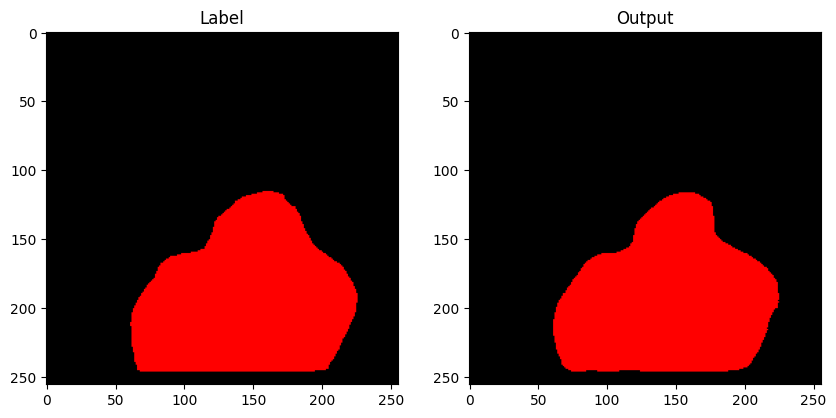

Epoch [7/200], Loss: 0.0776017294
Save new model


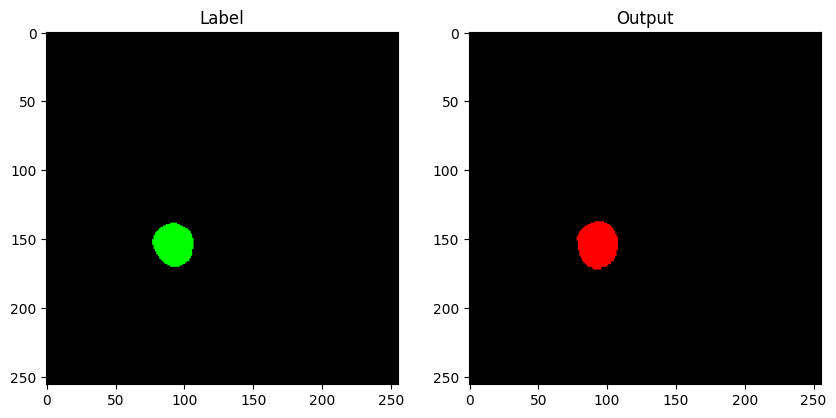

Epoch [8/200], Loss: 0.0729305555
Save new model


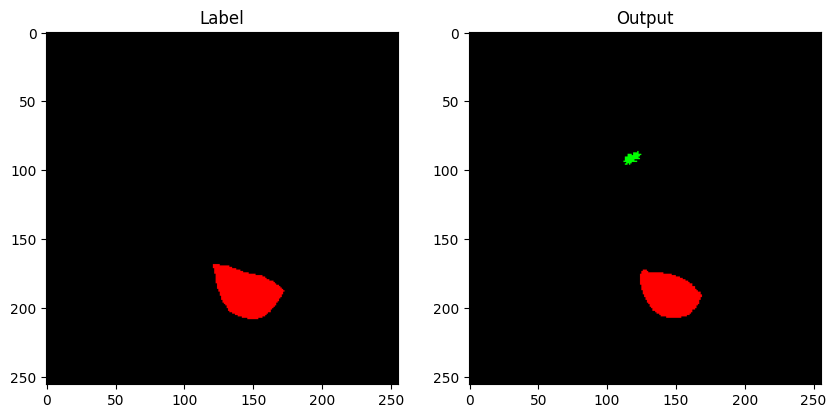

Epoch [9/200], Loss: 0.0652376926
Save new model


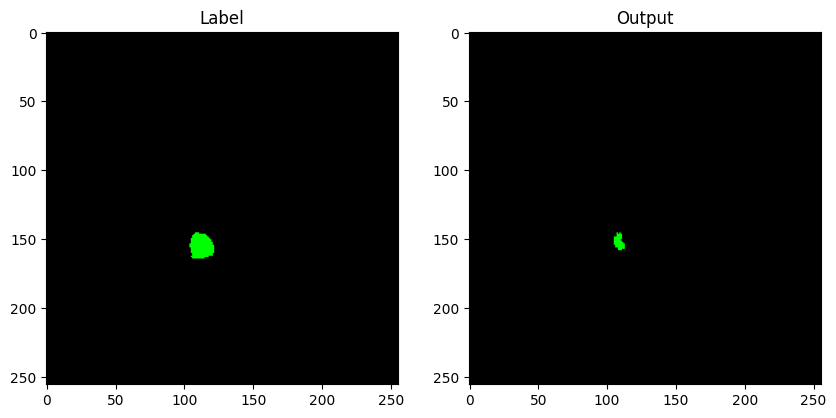

Epoch [10/200], Loss: 0.0635062055
Save new model


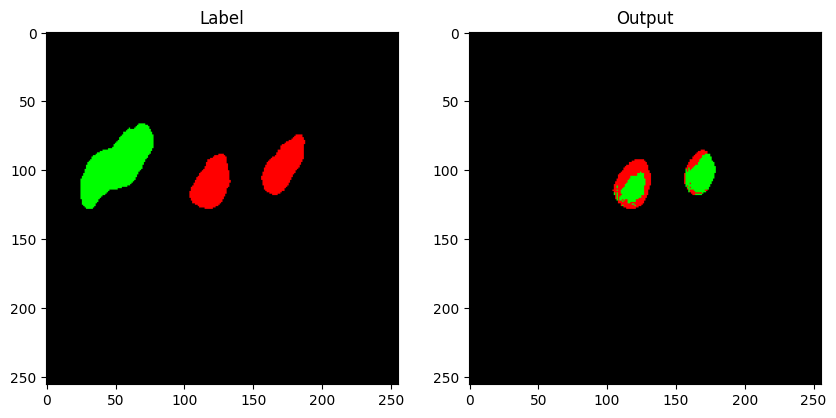

Epoch [11/200], Loss: 0.0556955888
Save new model


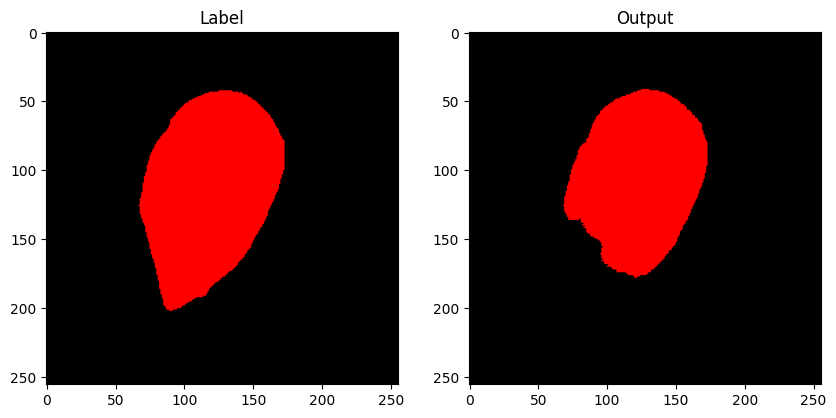

Epoch [12/200], Loss: 0.0577537949


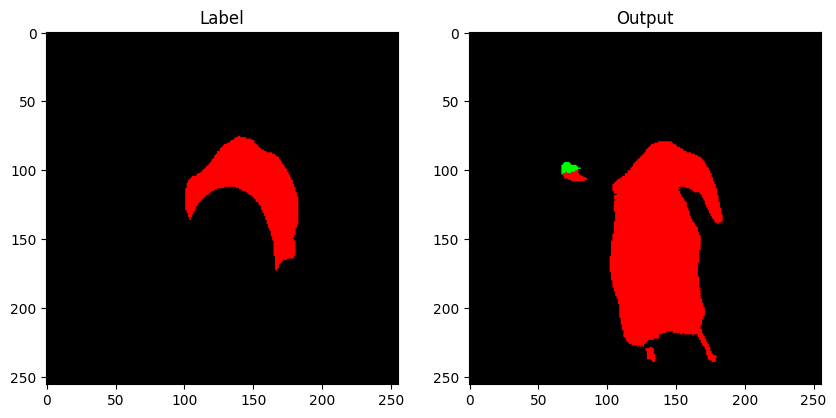

Epoch [13/200], Loss: 0.0547981160
Save new model


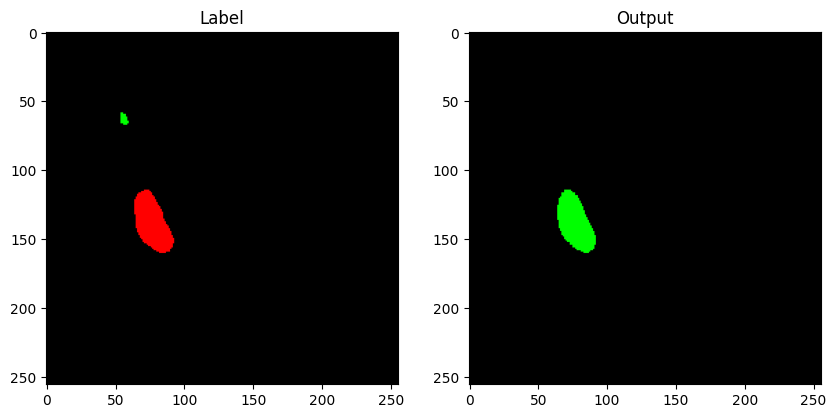

Epoch [14/200], Loss: 0.0580505469


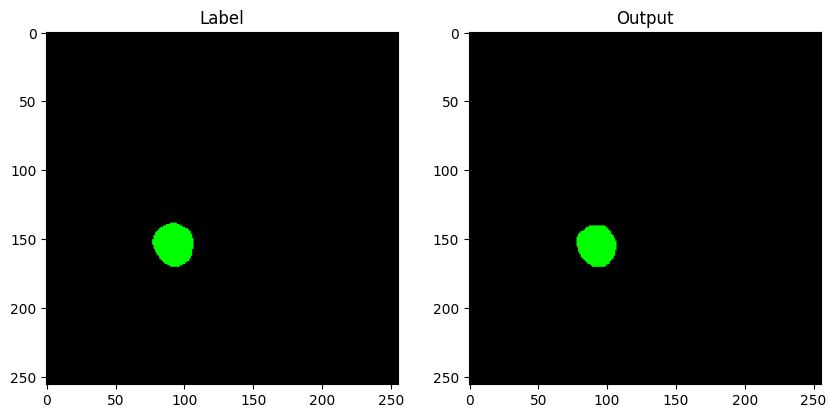

Epoch [15/200], Loss: 0.0524355256
Save new model


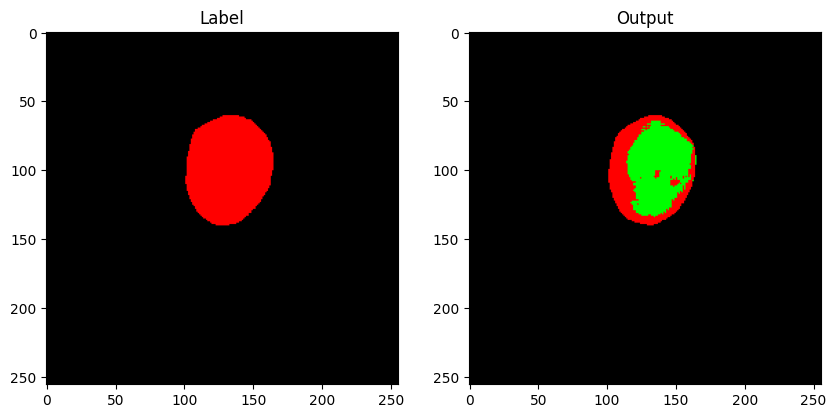

Epoch [16/200], Loss: 0.0511500592
Save new model


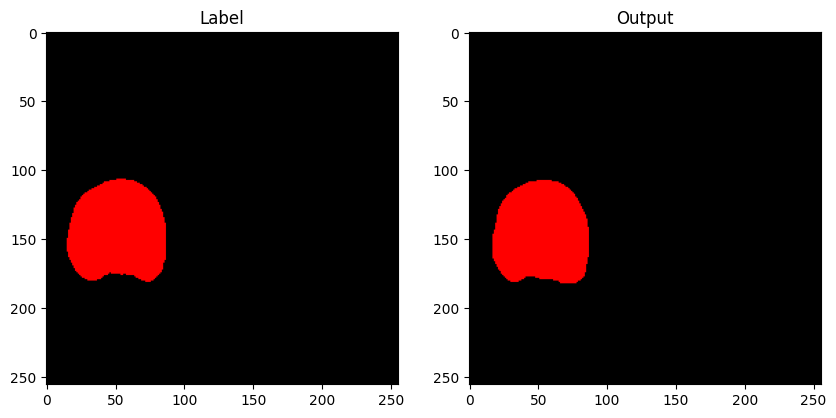

Epoch [17/200], Loss: 0.0500611927
Save new model


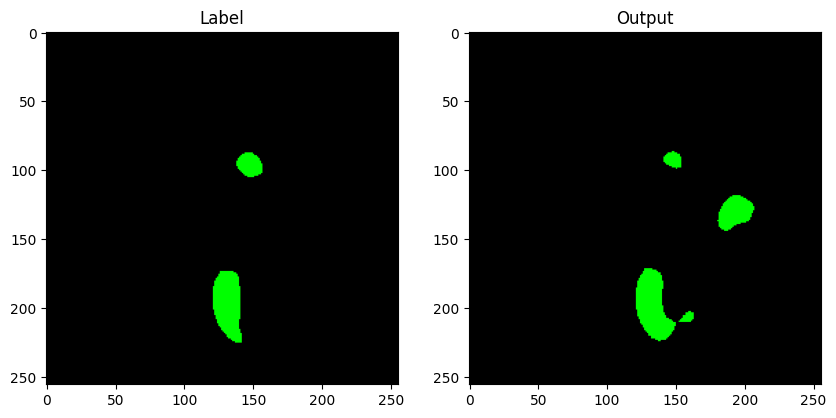

Epoch [18/200], Loss: 0.0572995670


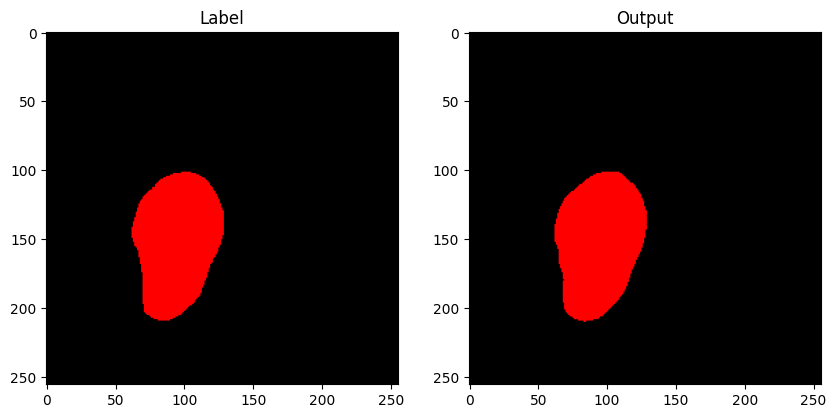

Epoch [19/200], Loss: 0.0506008733


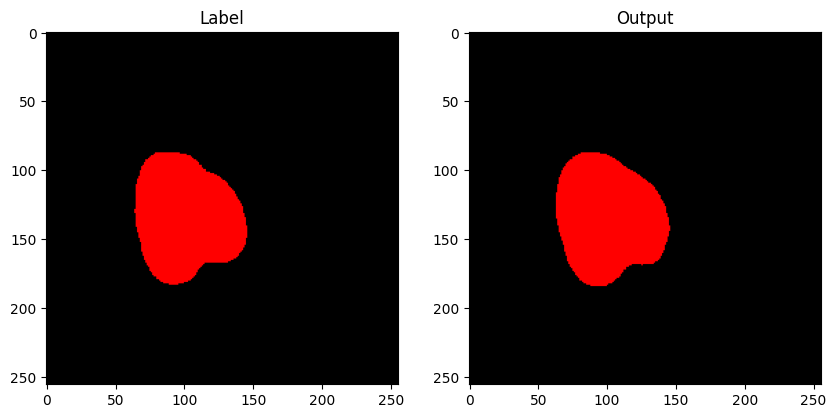

Epoch [20/200], Loss: 0.0516983769


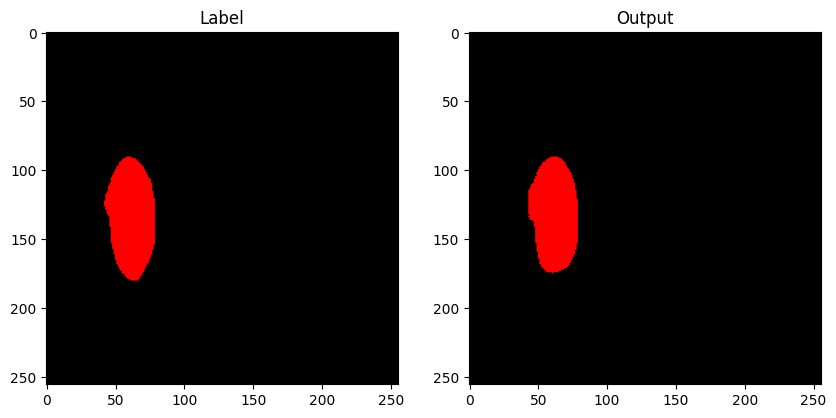

Epoch [21/200], Loss: 0.0567129899


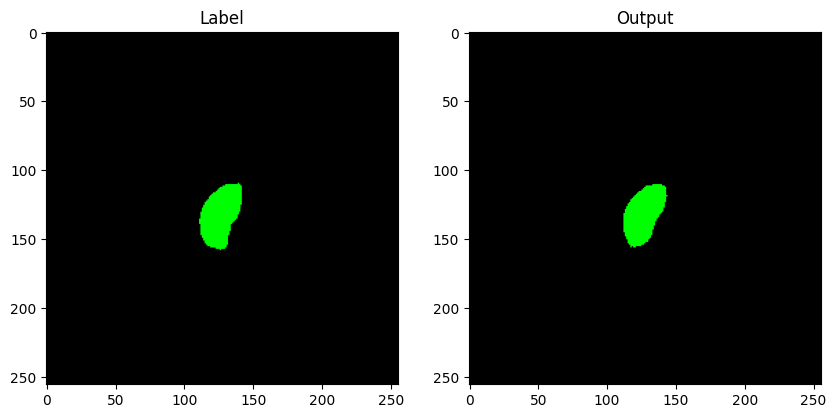

Epoch [22/200], Loss: 0.0560746436


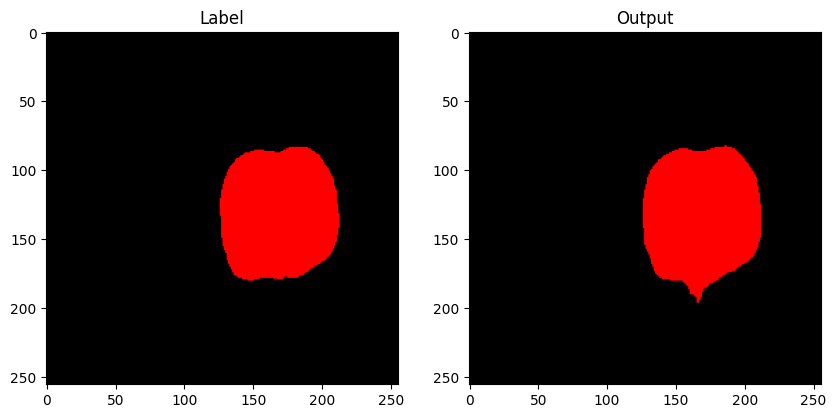

Epoch [23/200], Loss: 0.0557979155


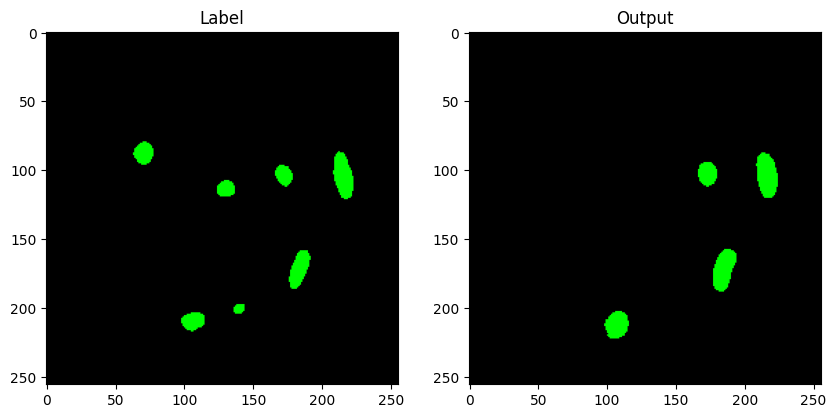

Epoch [24/200], Loss: 0.0528576169


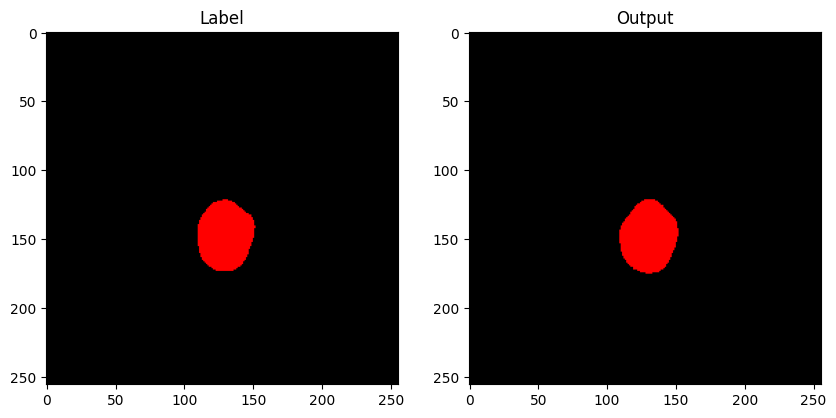

Epoch [25/200], Loss: 0.0505760791


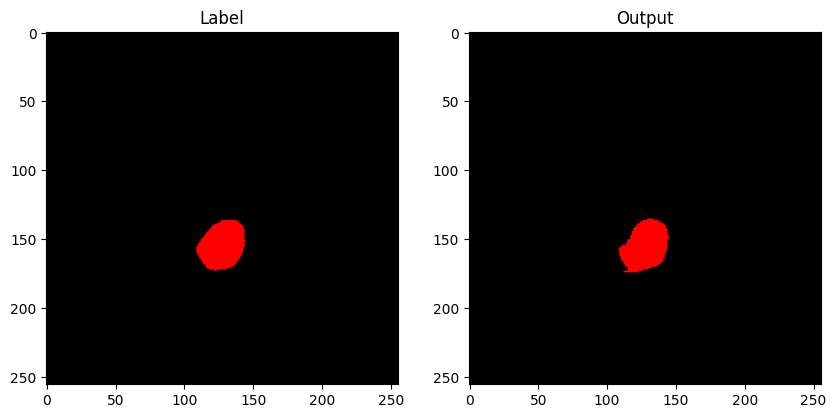

Epoch [26/200], Loss: 0.0601657136


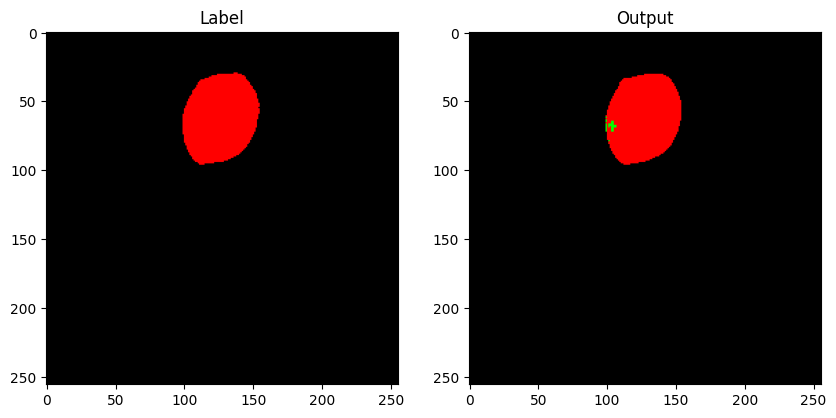

Epoch [27/200], Loss: 0.0535458210


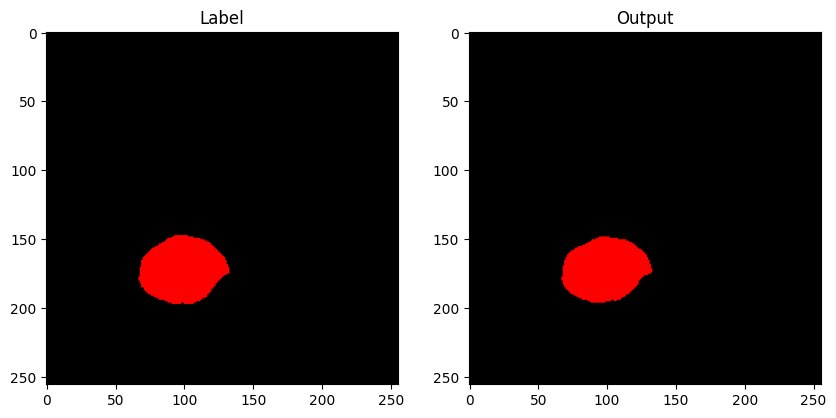

Epoch [28/200], Loss: 0.0568780797


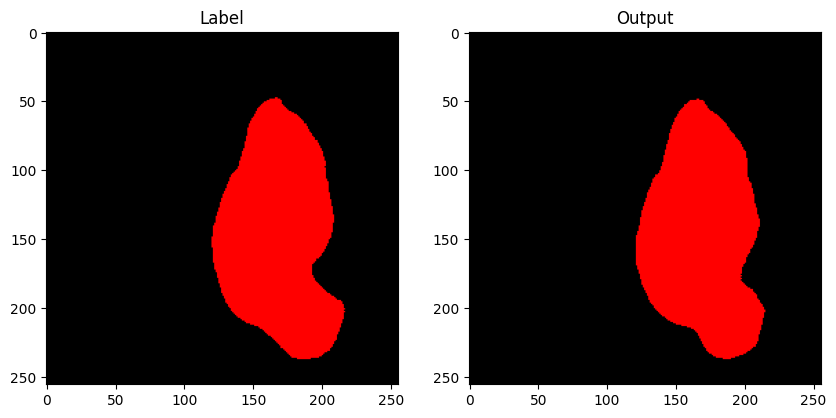

Epoch [29/200], Loss: 0.0497005858
Save new model


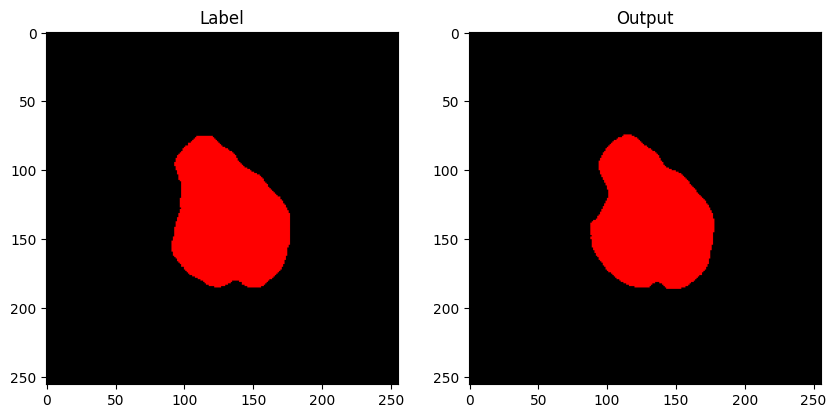

Epoch [30/200], Loss: 0.0566192408


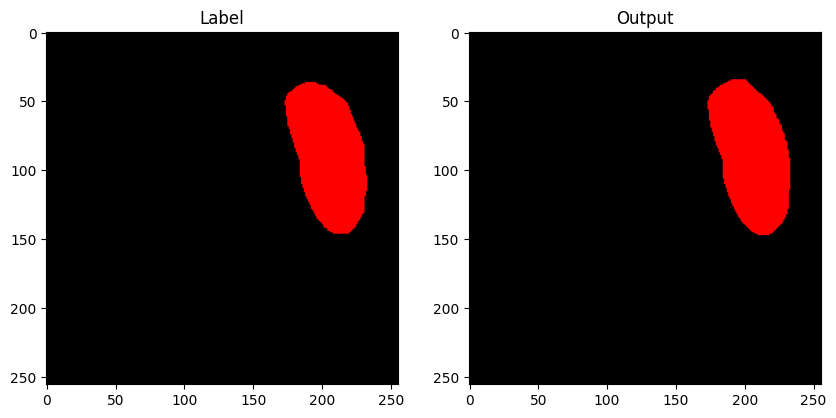

Epoch [31/200], Loss: 0.0590239192


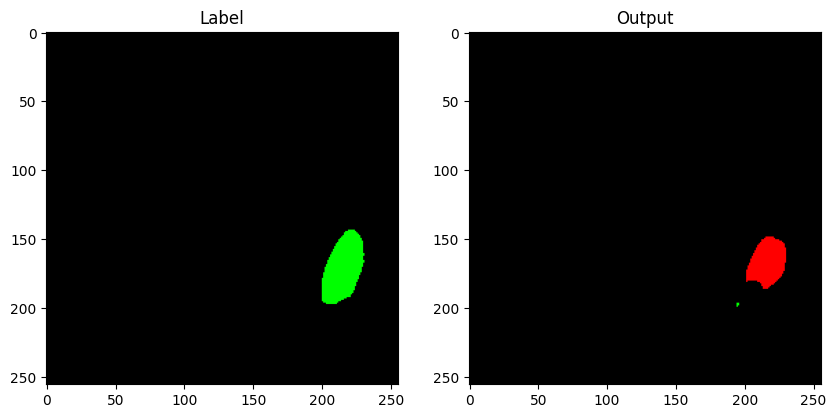

Epoch [32/200], Loss: 0.0646202976


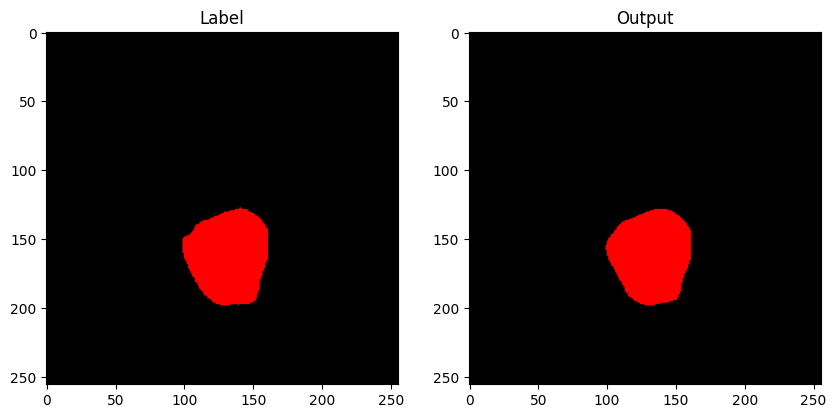

Epoch [33/200], Loss: 0.0616840537


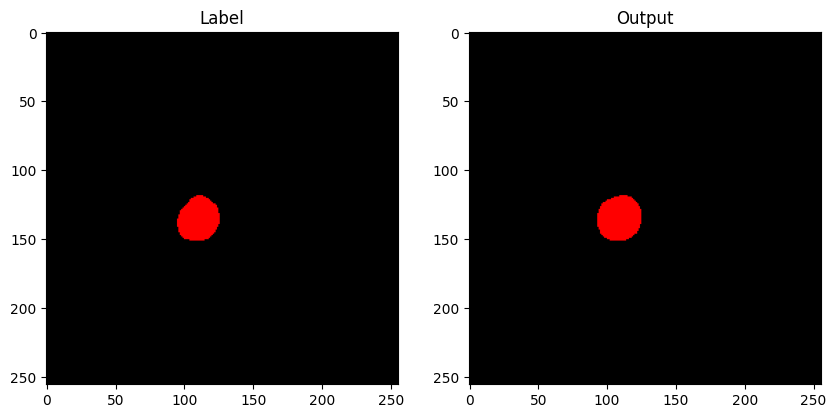

Epoch [34/200], Loss: 0.0524890811


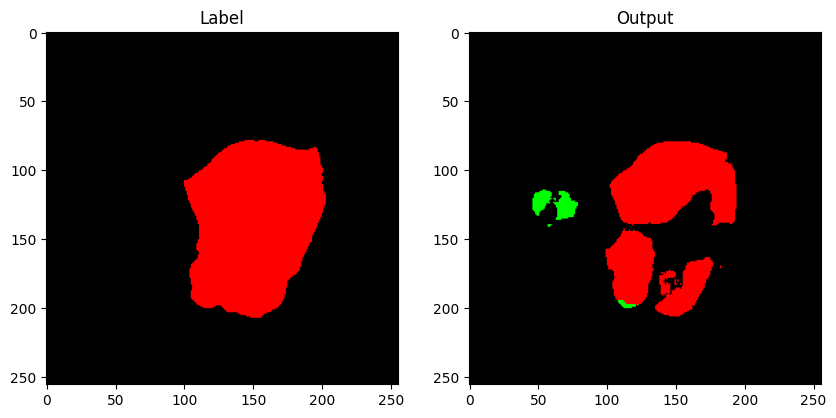

Epoch [35/200], Loss: 0.0630969715


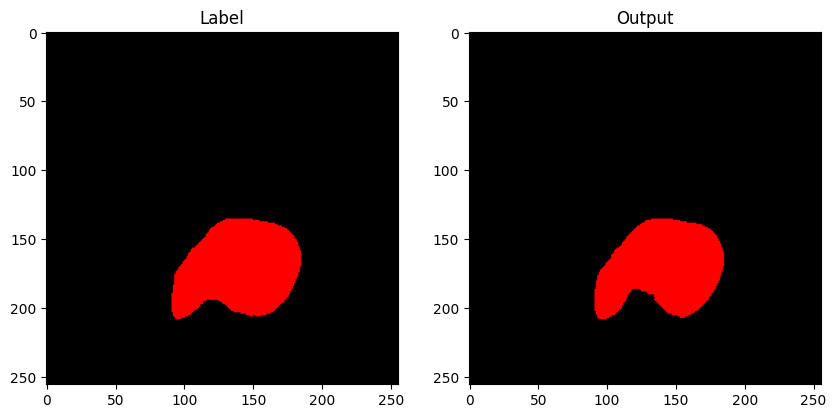

Epoch [36/200], Loss: 0.0596223800


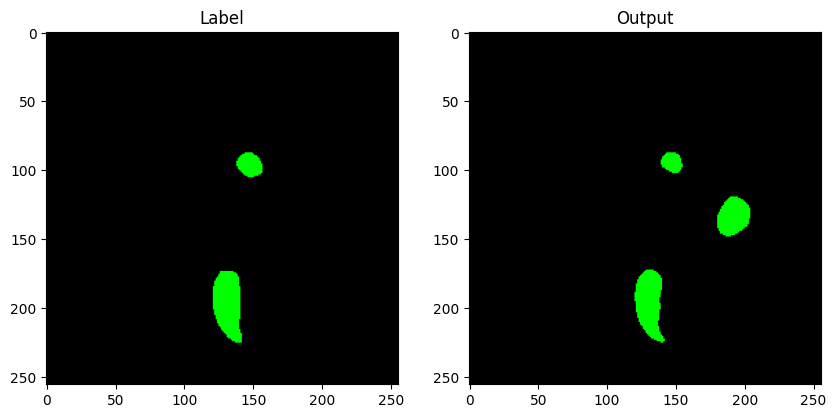

Epoch [37/200], Loss: 0.0605779858


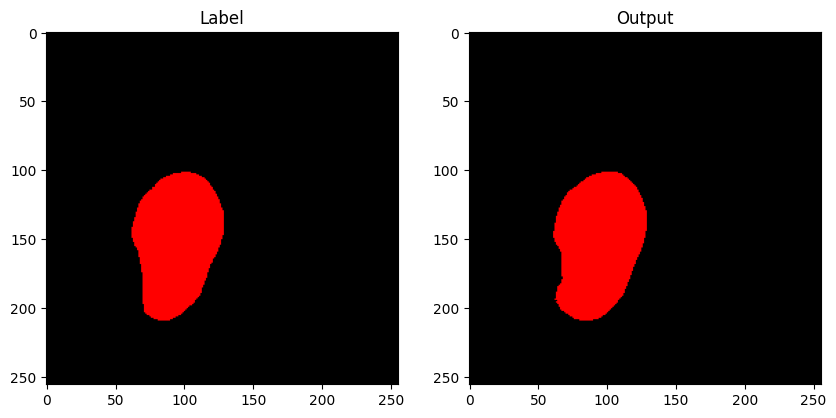

Epoch [38/200], Loss: 0.0547280125


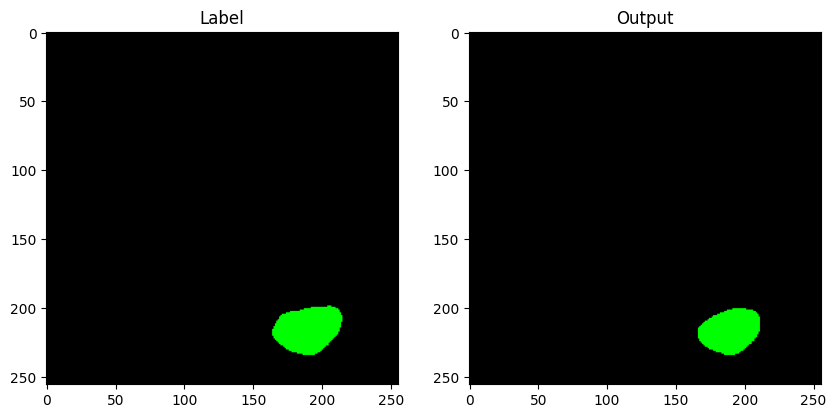

Epoch [39/200], Loss: 0.0581792208


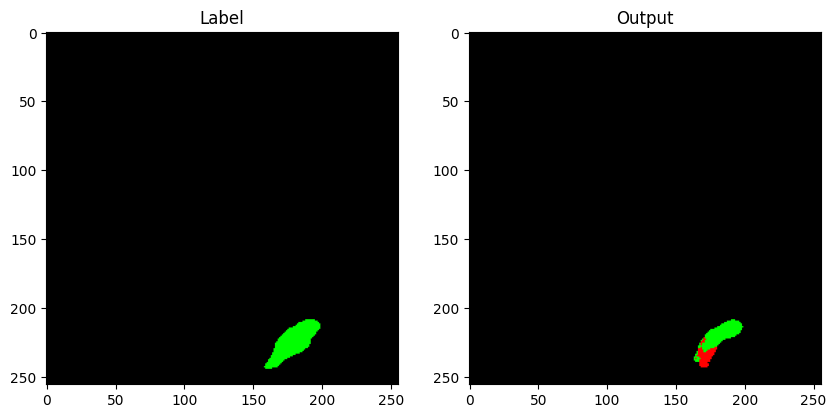

Epoch [40/200], Loss: 0.0699640473


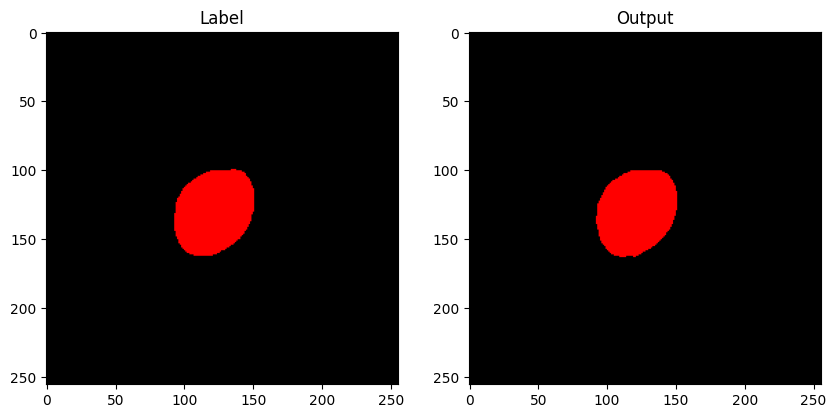

Epoch [41/200], Loss: 0.0661794543


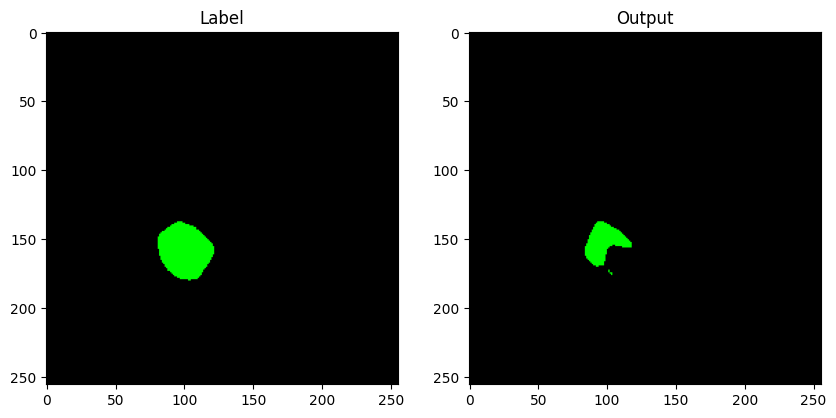

Epoch [42/200], Loss: 0.0493324320
Save new model


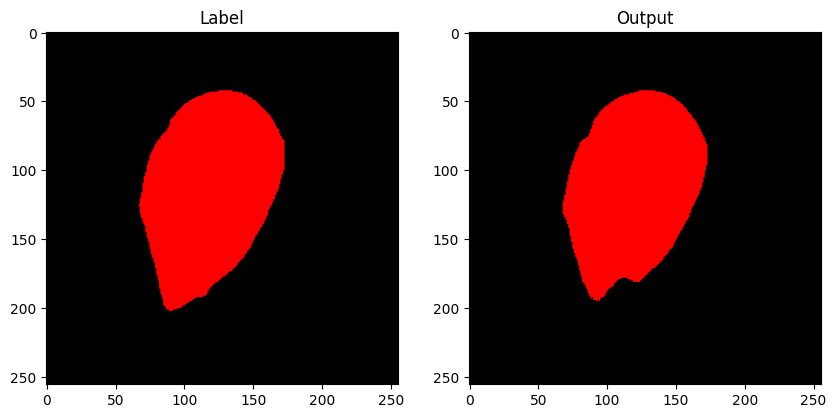

Epoch [43/200], Loss: 0.0523976065


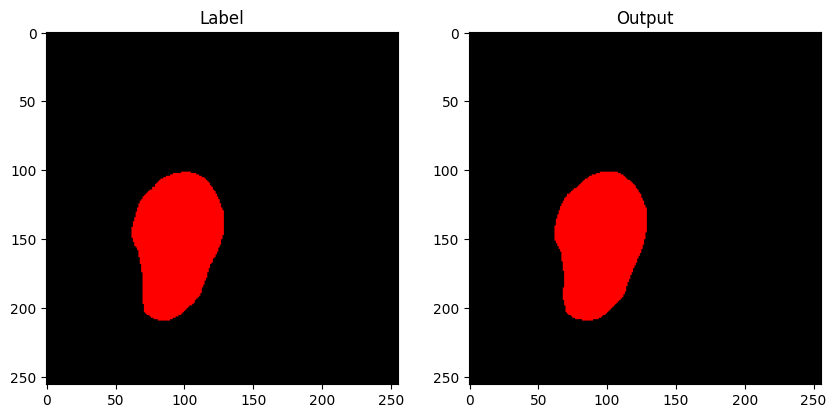

Epoch [44/200], Loss: 0.0596550166


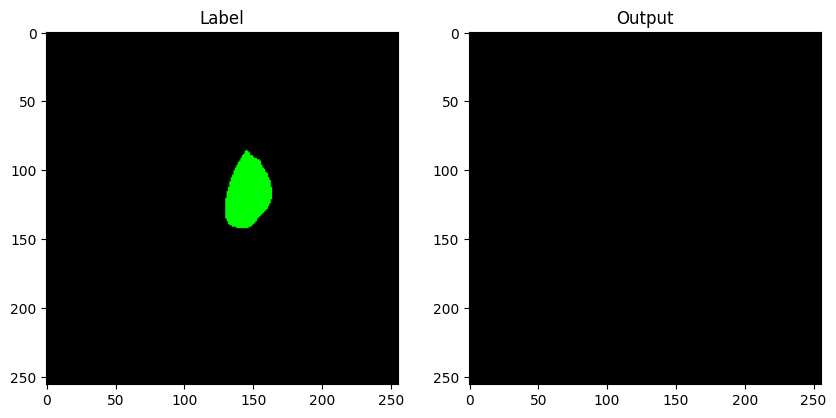

Epoch [45/200], Loss: 0.0545882586


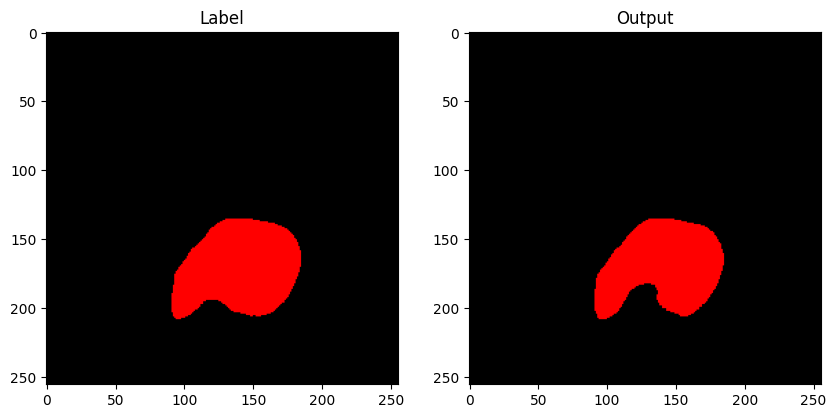

Epoch [46/200], Loss: 0.0664169268


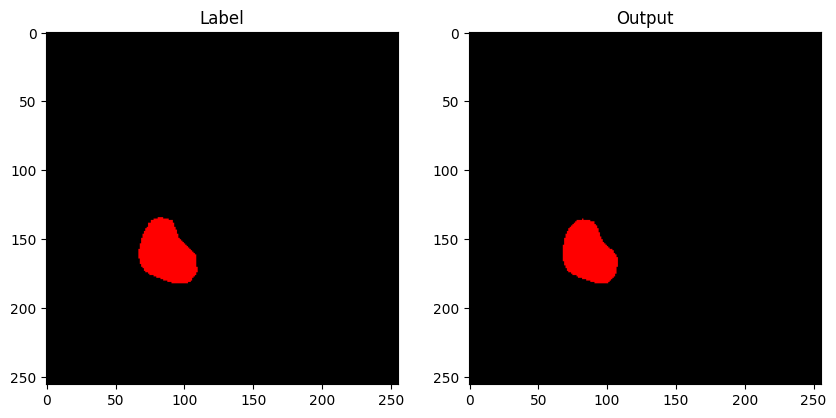

Epoch [47/200], Loss: 0.0622304144


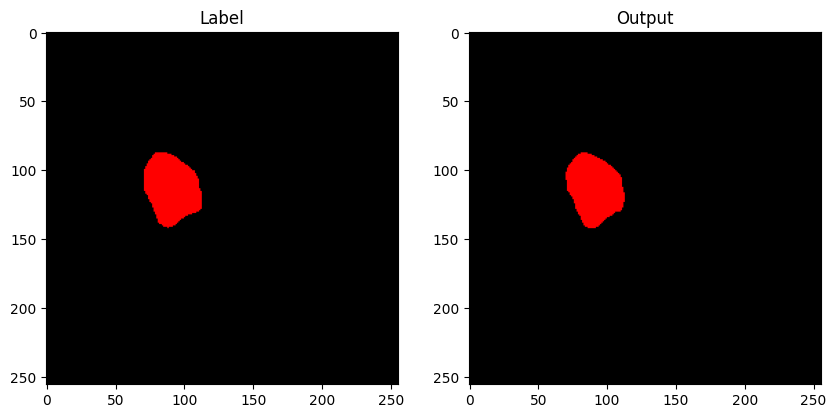

Epoch [48/200], Loss: 0.0622648134


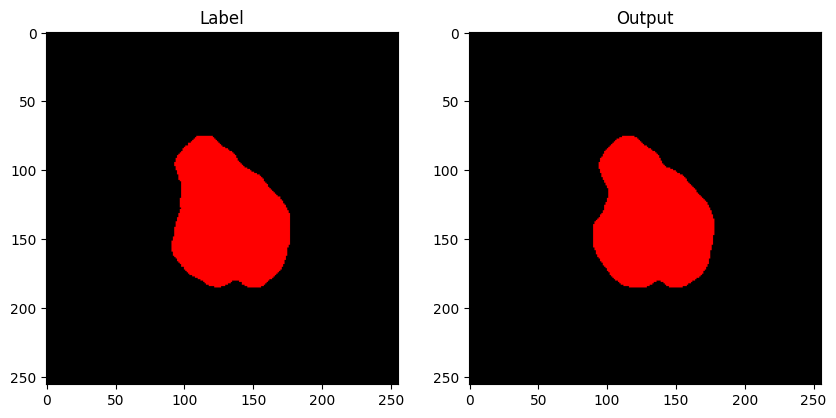

Epoch [49/200], Loss: 0.0614384930


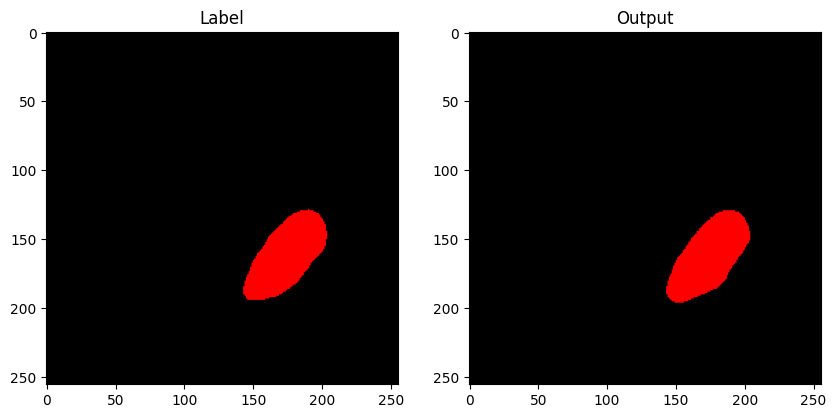

Epoch [50/200], Loss: 0.0610120381


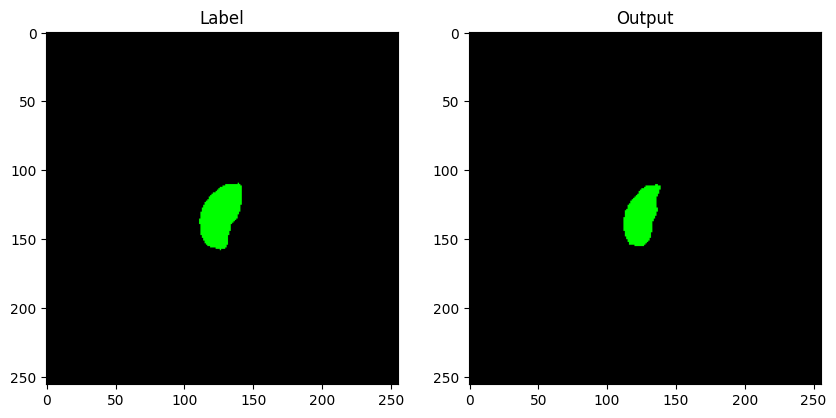

Epoch [51/200], Loss: 0.0613057127


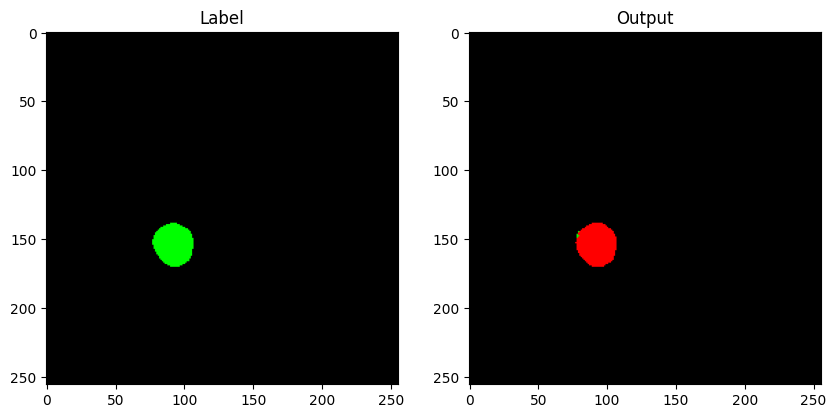

Epoch [52/200], Loss: 0.0631991828


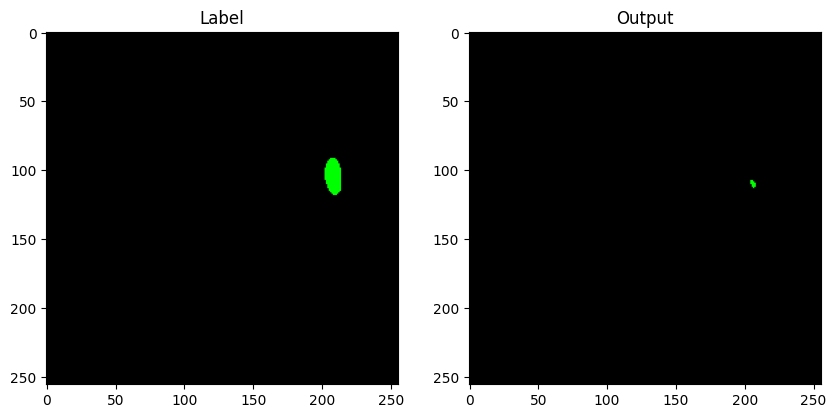

Epoch [53/200], Loss: 0.0588266582


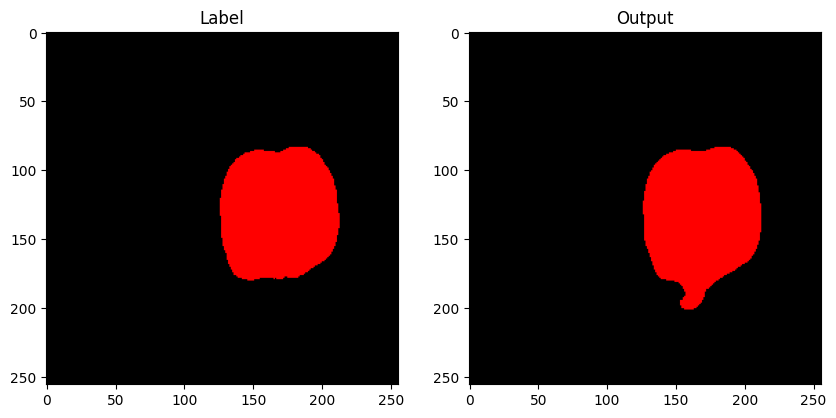

Epoch [54/200], Loss: 0.0716954228


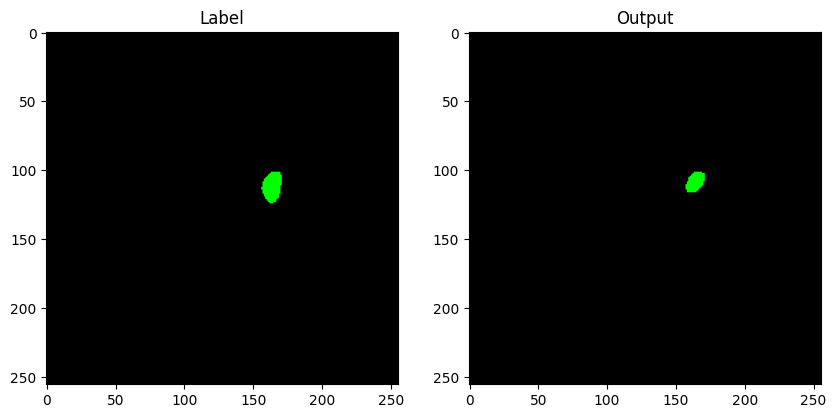

Epoch [55/200], Loss: 0.0578205542


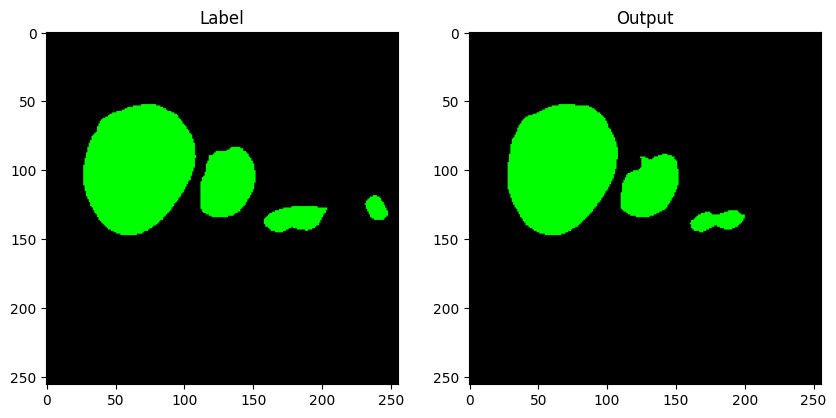

Epoch [56/200], Loss: 0.0611881453


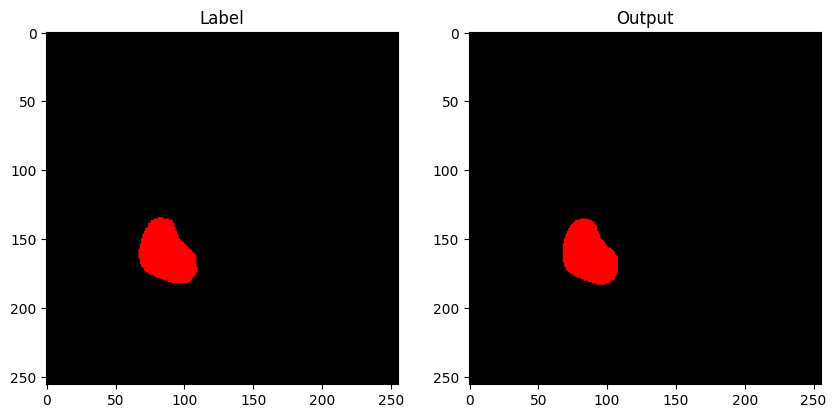

Epoch [57/200], Loss: 0.0693898609


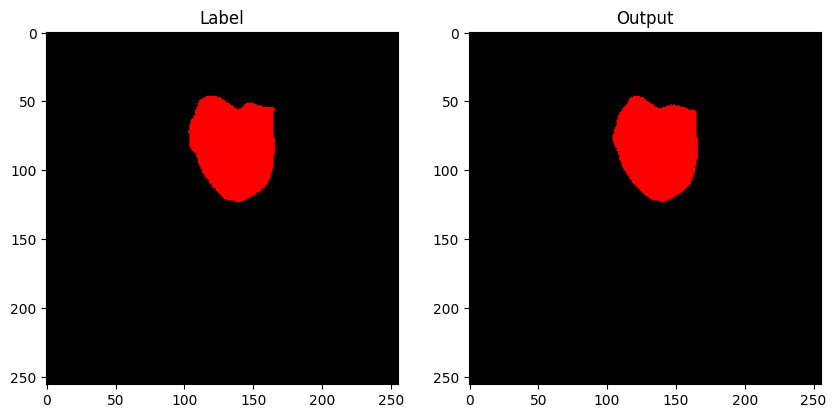

Epoch [58/200], Loss: 0.0862294528


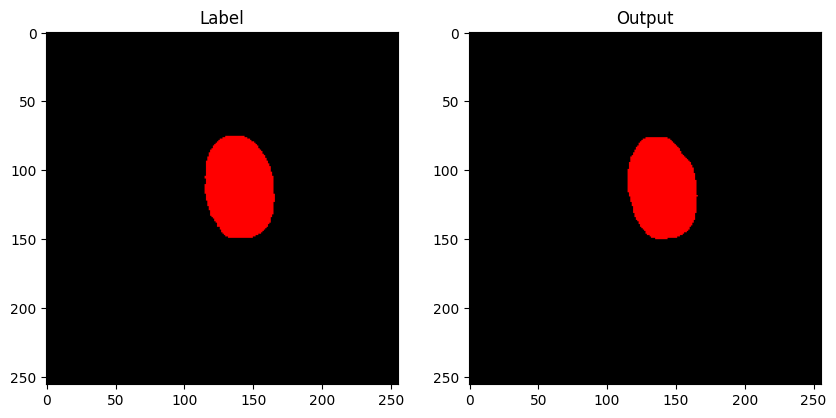

Epoch [59/200], Loss: 0.0717375171


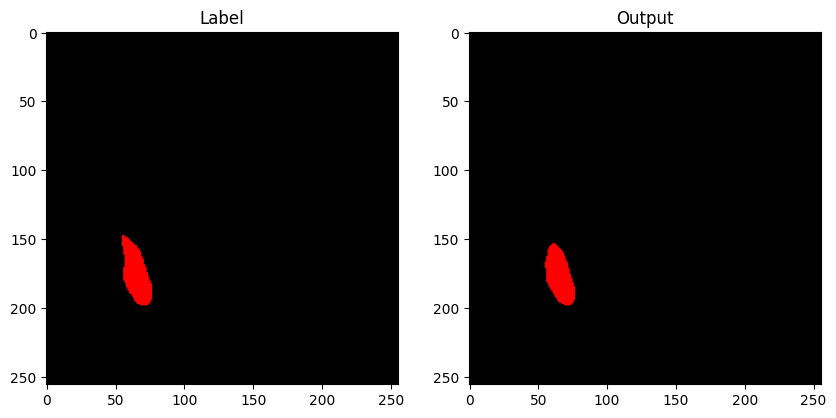

Epoch [60/200], Loss: 0.0777184898


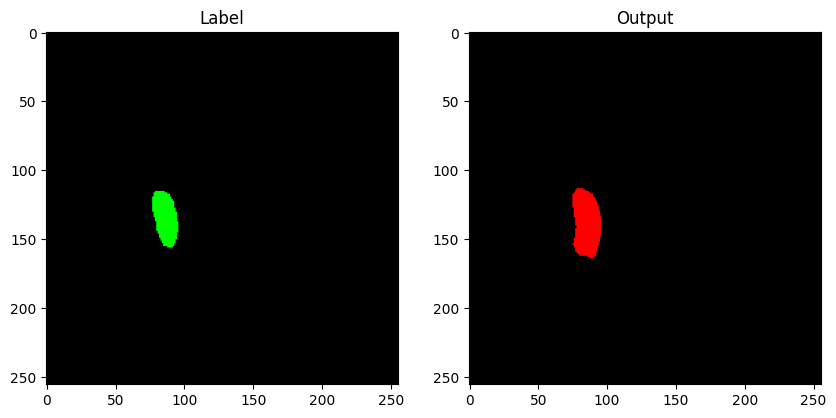

Epoch [61/200], Loss: 0.0804877909


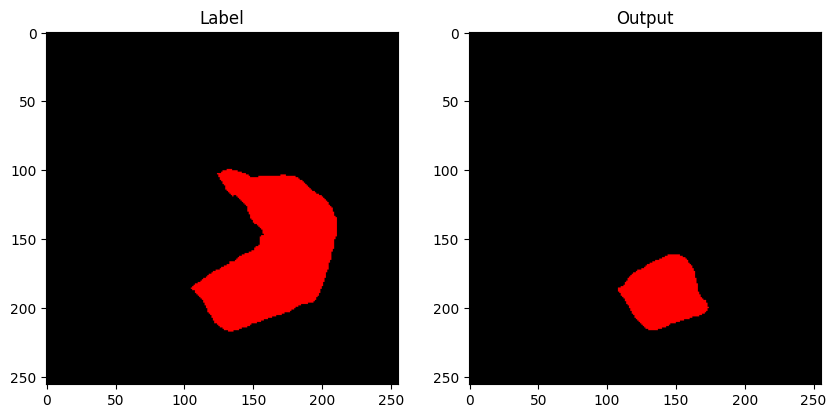

Epoch [62/200], Loss: 0.0692973979


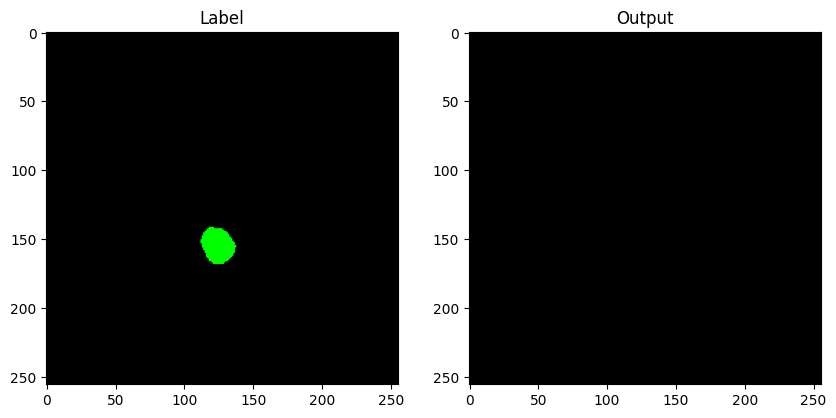

Epoch [63/200], Loss: 0.0644373867


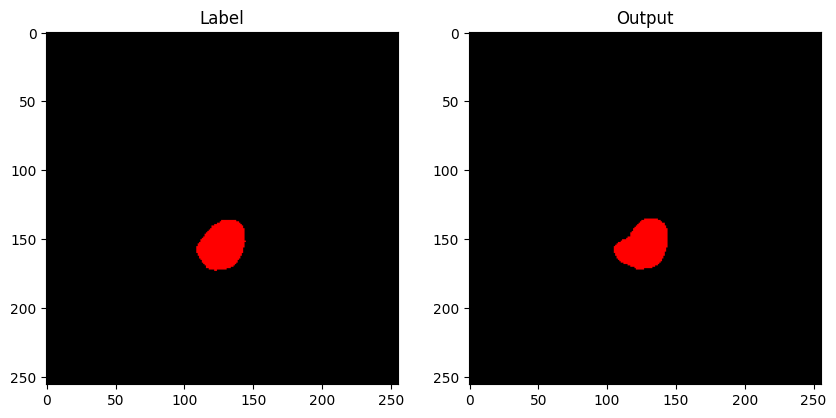

Epoch [64/200], Loss: 0.0658540453


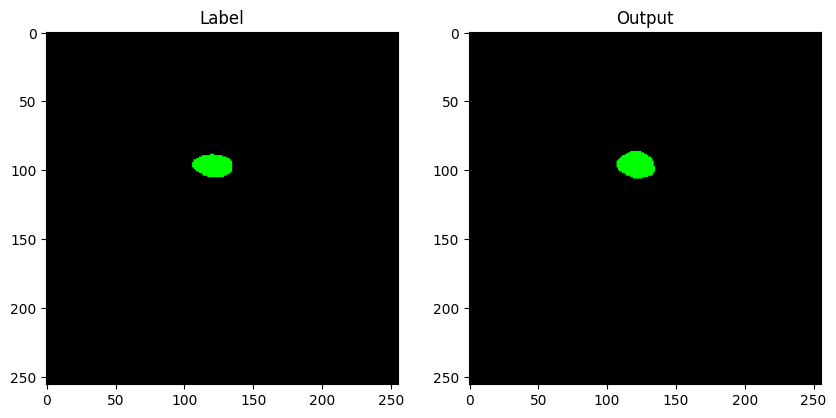

Epoch [65/200], Loss: 0.0660331666


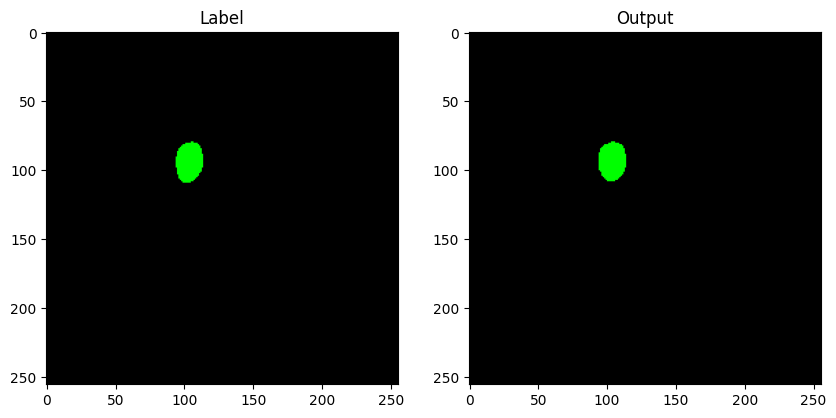

Epoch [66/200], Loss: 0.0826384836


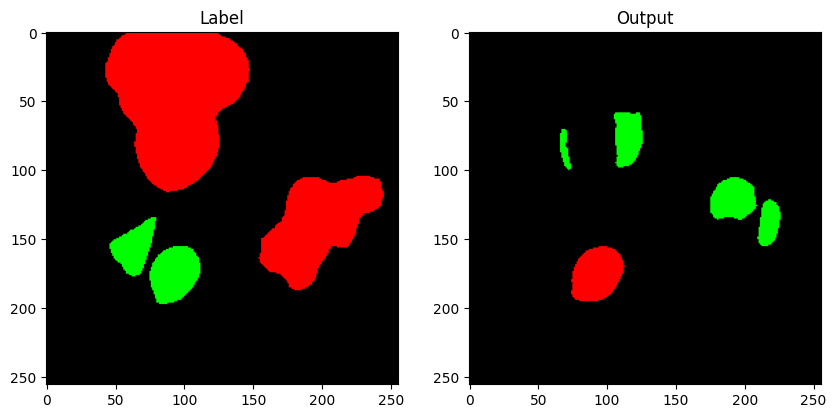

Epoch [67/200], Loss: 0.0802721191


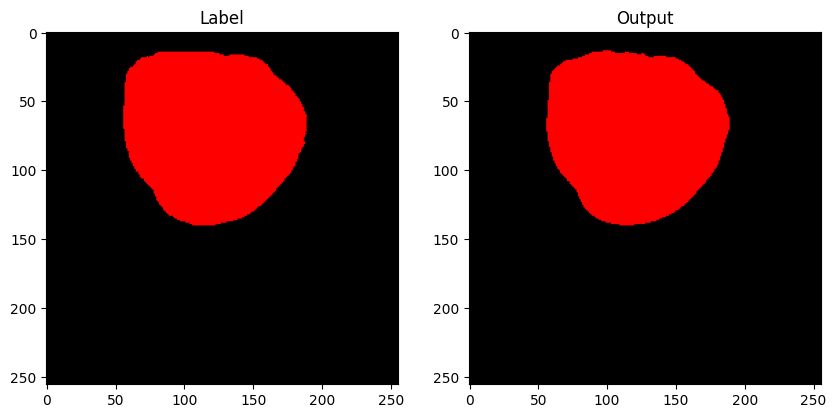

Epoch [68/200], Loss: 0.0757888948


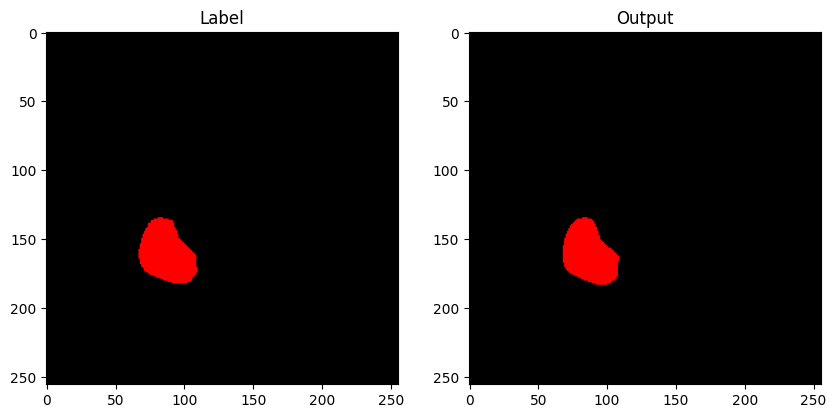

Epoch [69/200], Loss: 0.0742582927


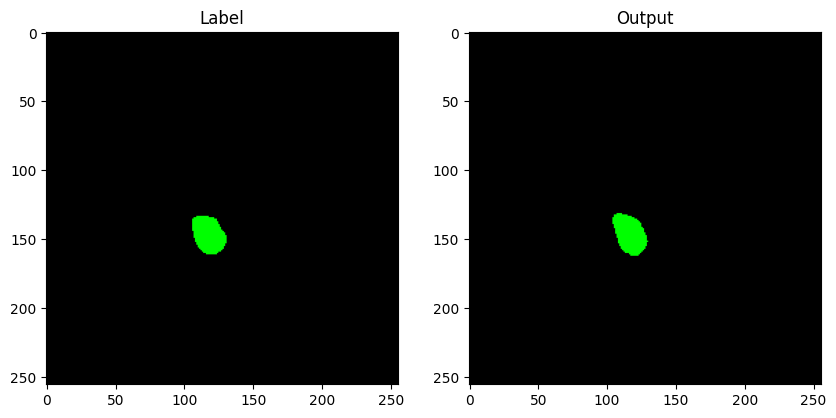

Epoch [70/200], Loss: 0.0709307070


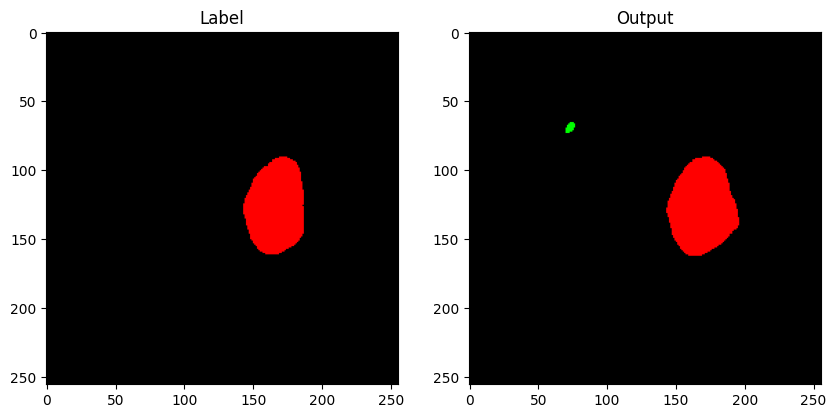

Epoch [71/200], Loss: 0.0788556911


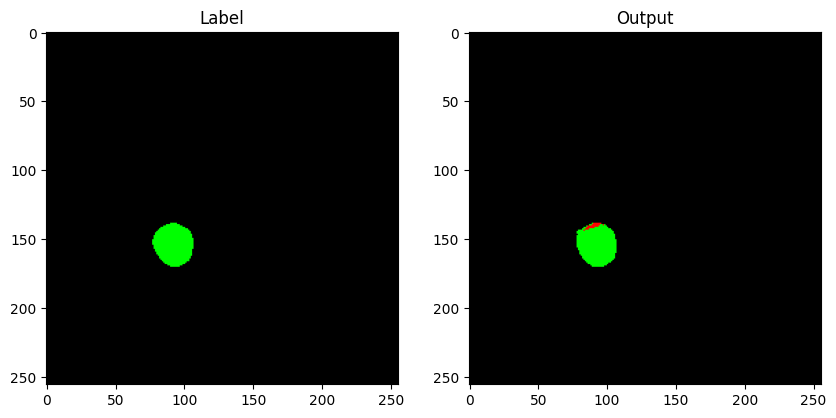

Epoch [72/200], Loss: 0.0716117560


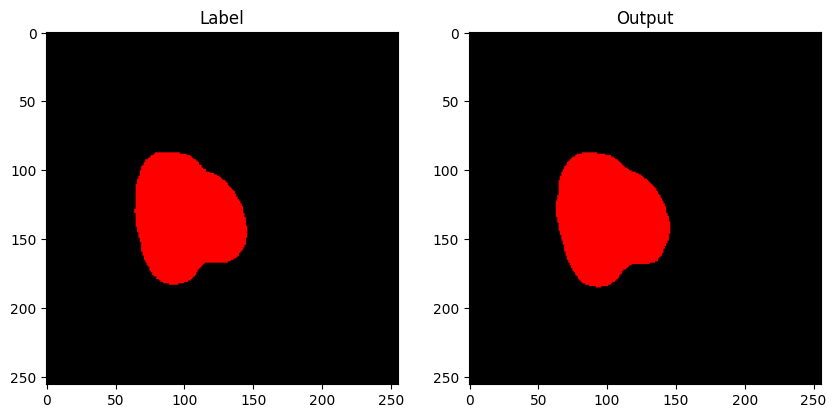

Epoch [73/200], Loss: 0.0729855649


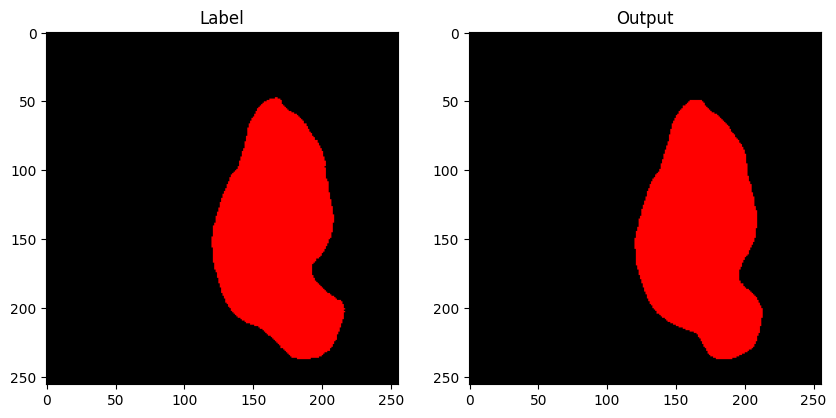

Epoch [74/200], Loss: 0.0804890444


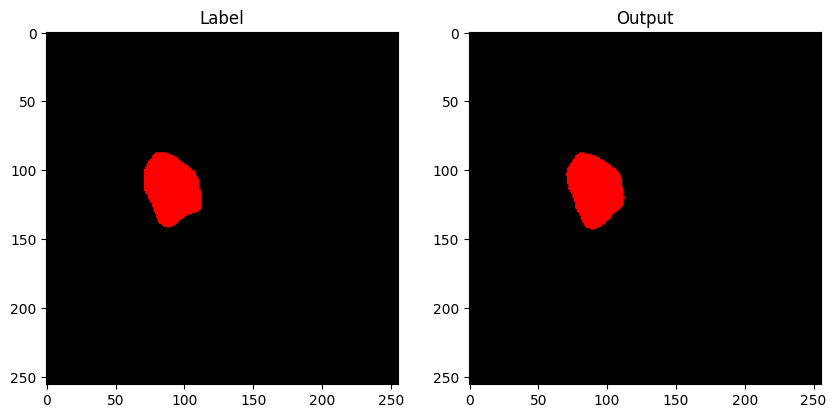

Epoch [75/200], Loss: 0.0960749426


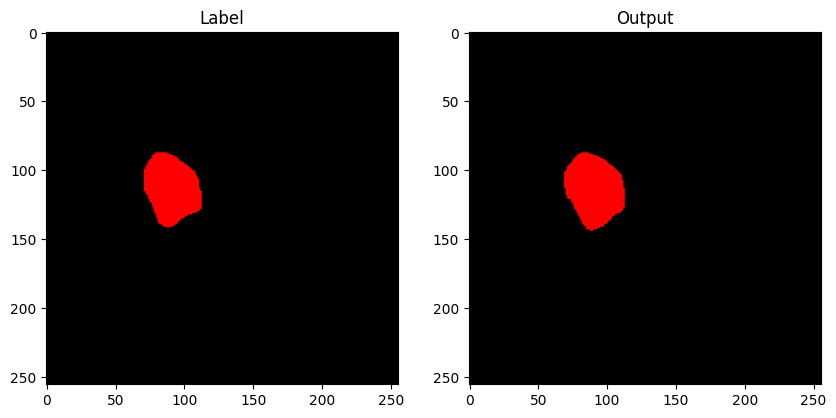

Epoch [76/200], Loss: 0.0604920913


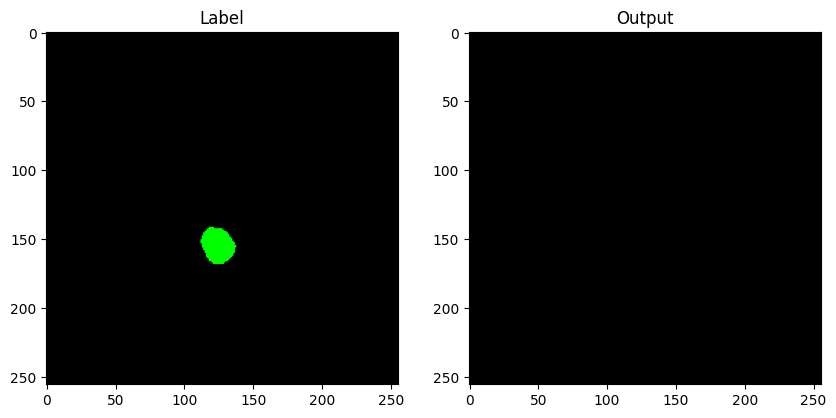

Epoch [77/200], Loss: 0.0642801014


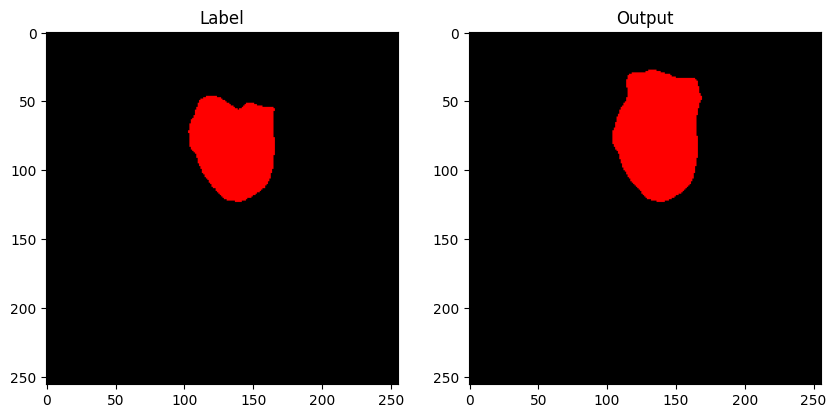

Epoch [78/200], Loss: 0.0722586049


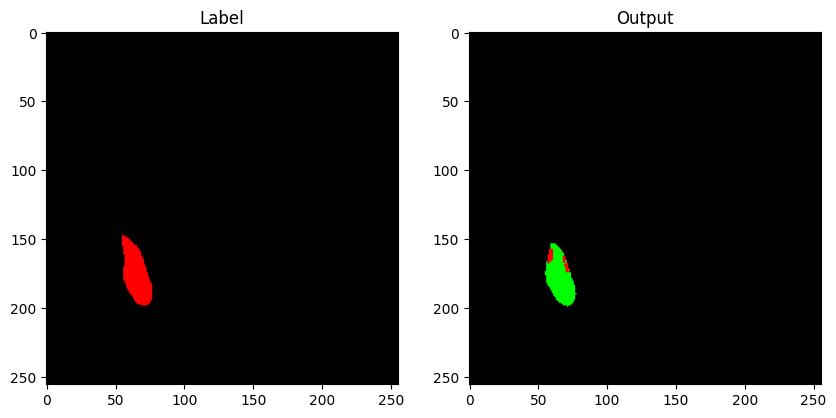

Epoch [79/200], Loss: 0.0667029334


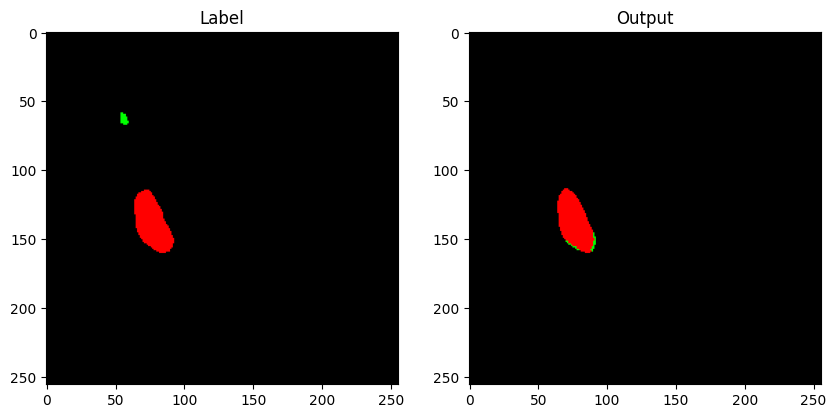

Epoch [80/200], Loss: 0.0617285362


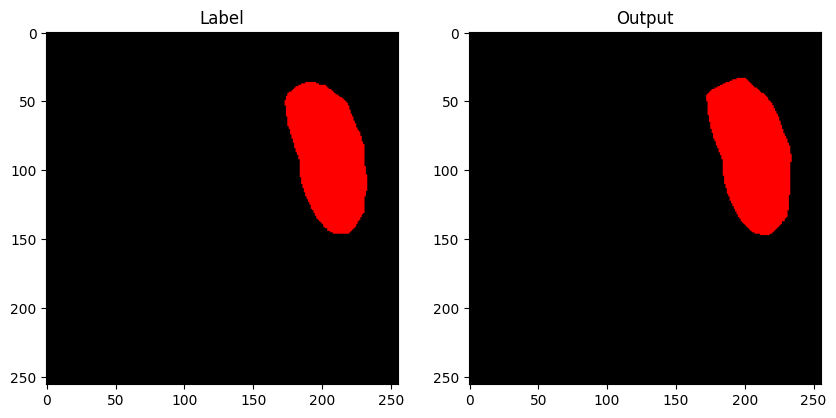

Epoch [81/200], Loss: 0.0702961904


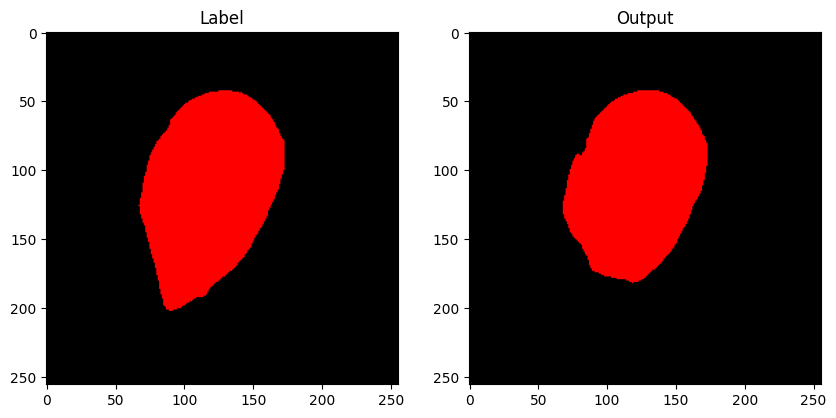

Epoch [82/200], Loss: 0.0723052516


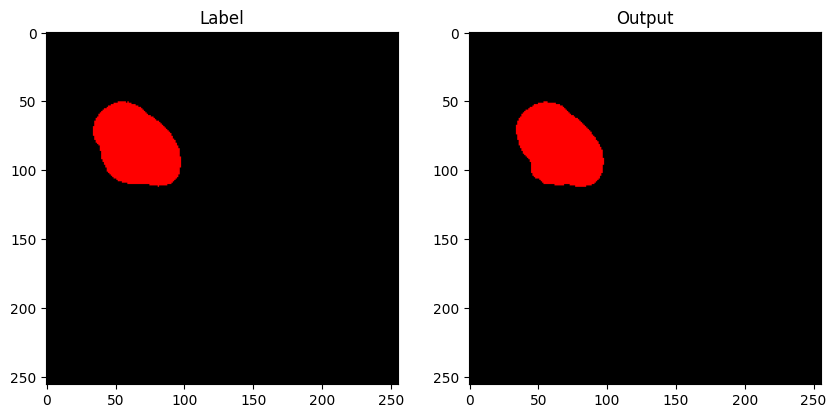

Epoch [83/200], Loss: 0.0656270367


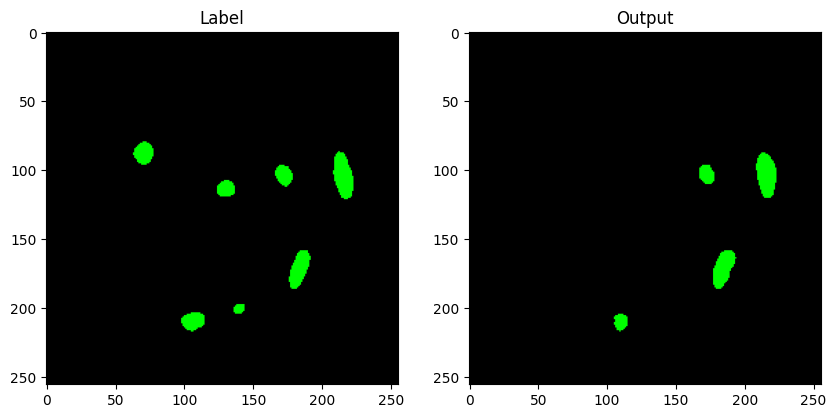

Epoch [84/200], Loss: 0.0698309882


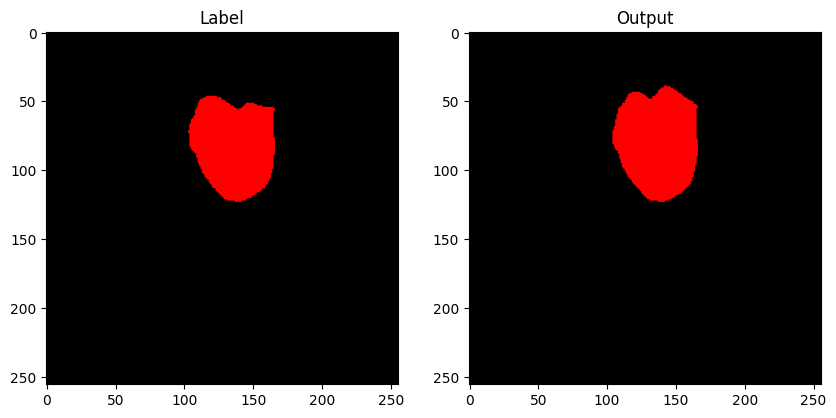

Epoch [85/200], Loss: 0.0709572502


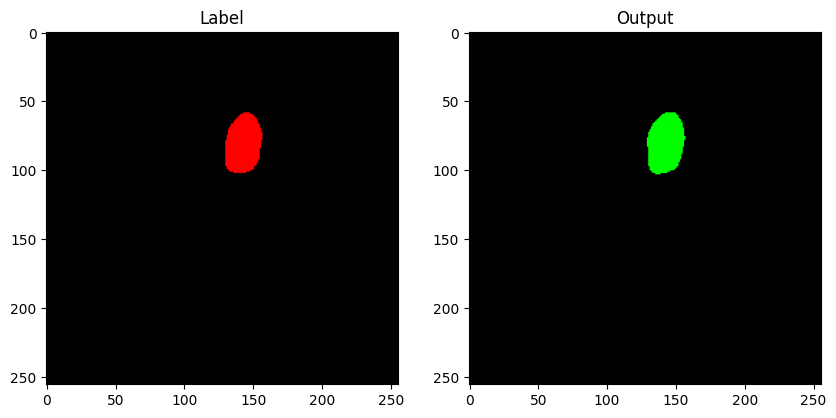

Epoch [86/200], Loss: 0.0914199444


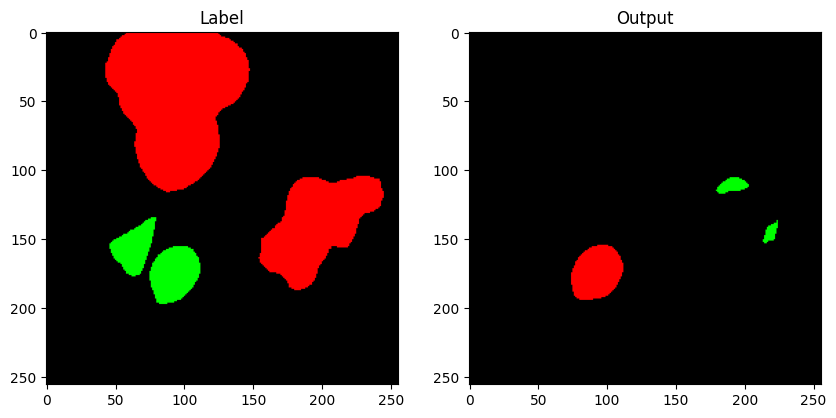

Epoch [87/200], Loss: 0.0725988866


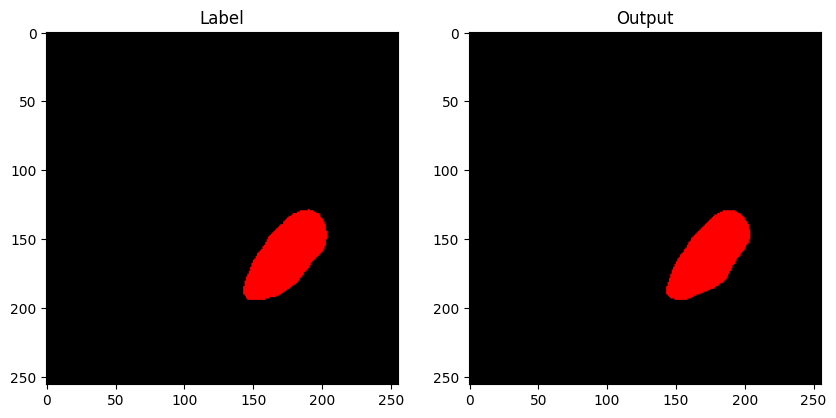

Epoch [88/200], Loss: 0.0623741266


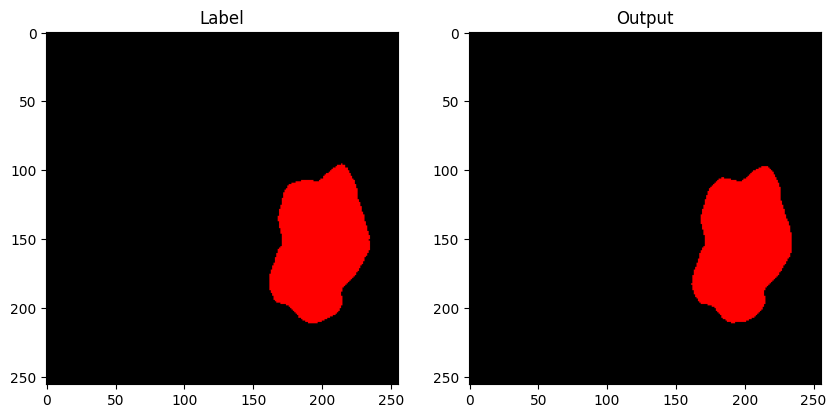

Epoch [89/200], Loss: 0.0866187477


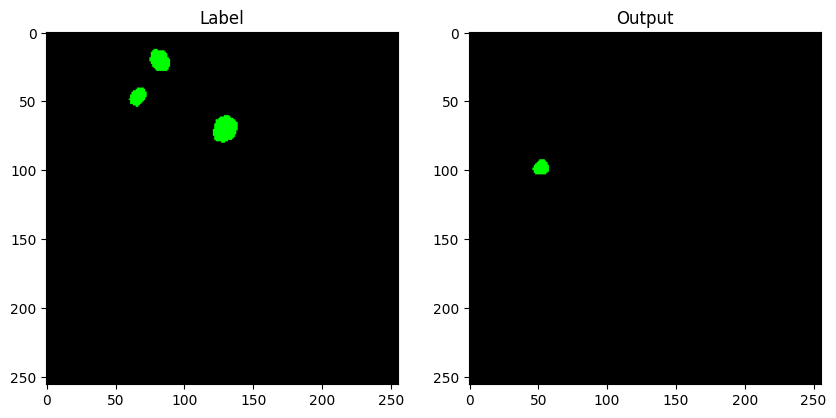

Epoch [90/200], Loss: 0.0749498136


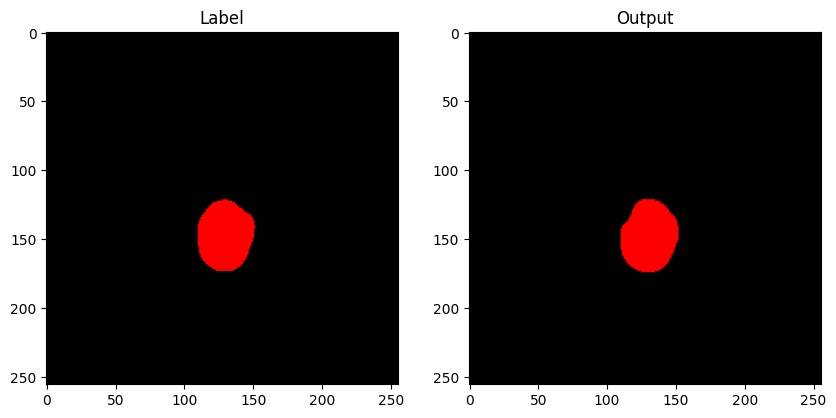

Epoch [91/200], Loss: 0.0779087006


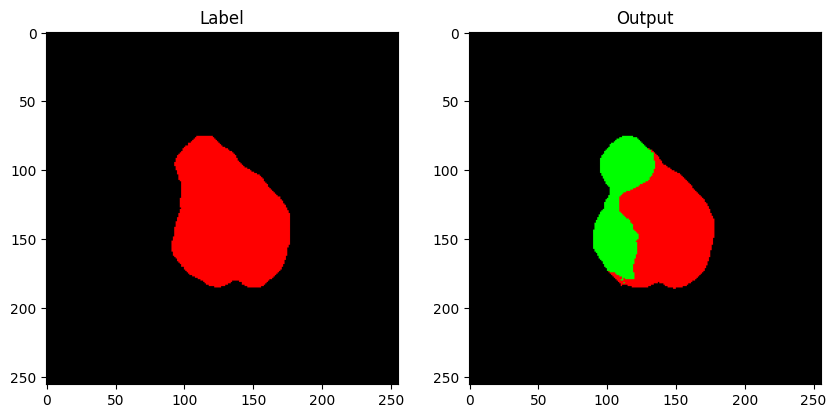

Epoch [92/200], Loss: 0.0759902370


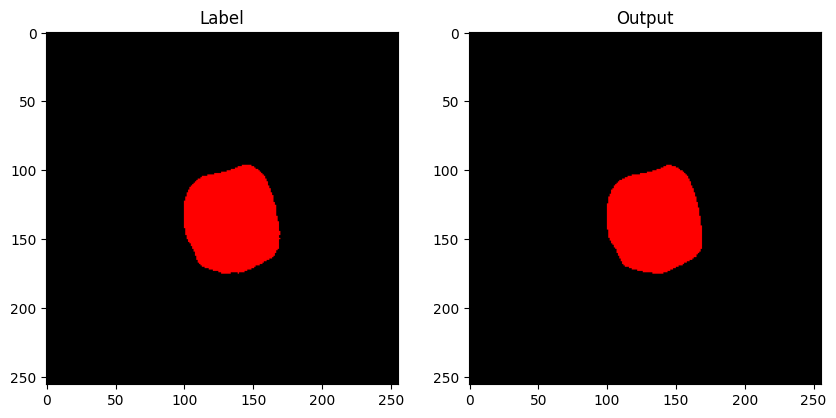

Epoch [93/200], Loss: 0.0856840344


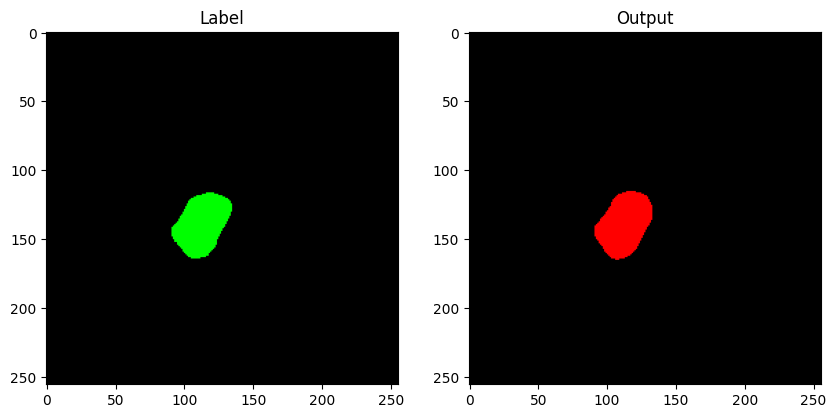

Epoch [94/200], Loss: 0.0941360418


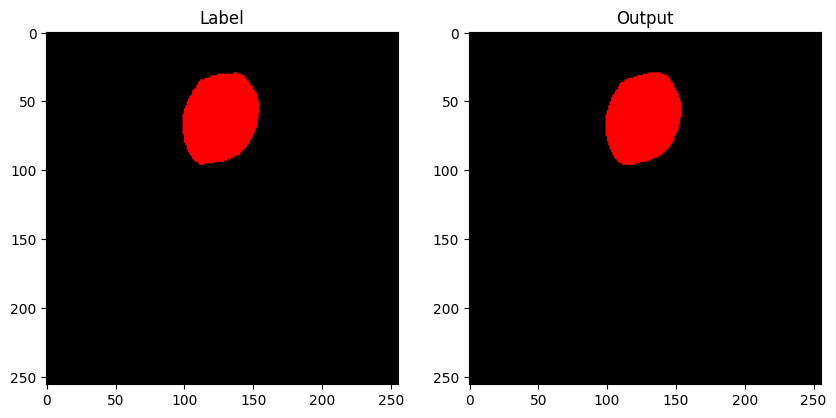

Epoch [95/200], Loss: 0.0759330409


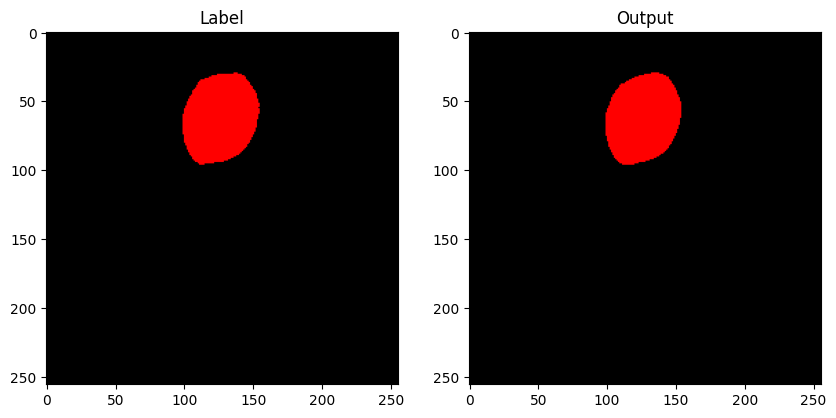

Epoch [96/200], Loss: 0.0795817783


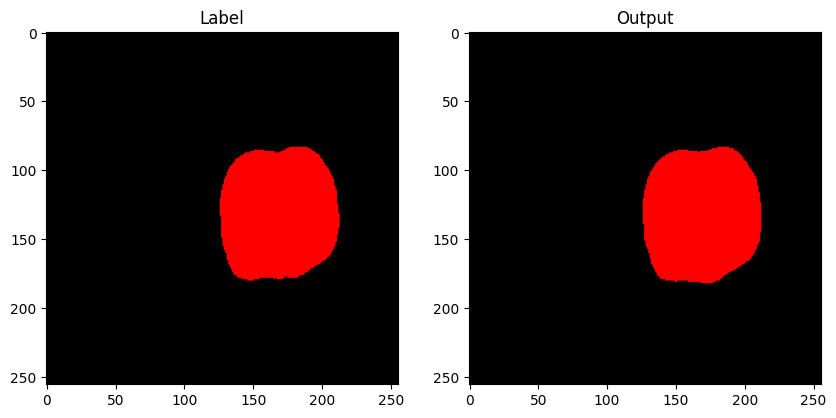

Epoch [97/200], Loss: 0.0787501348


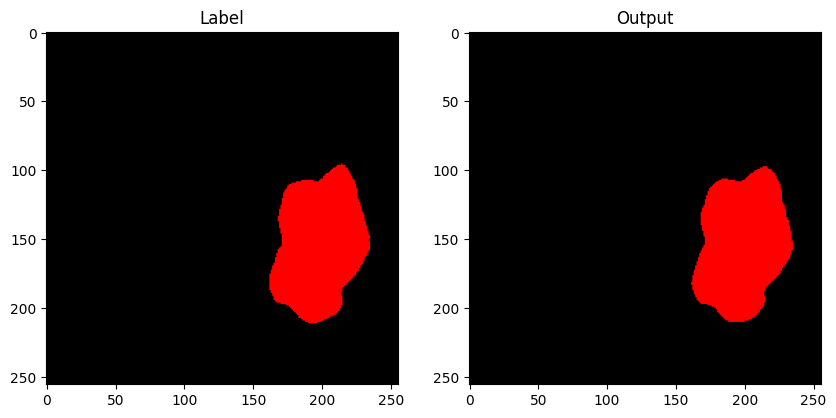

Epoch [98/200], Loss: 0.0895004780


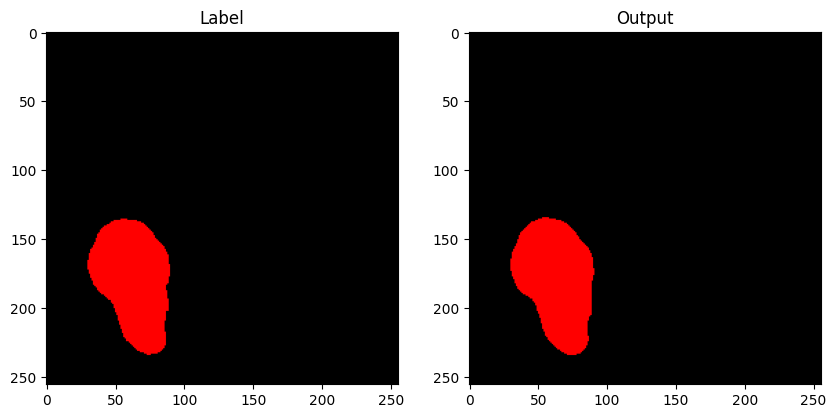

Epoch [99/200], Loss: 0.0809567423


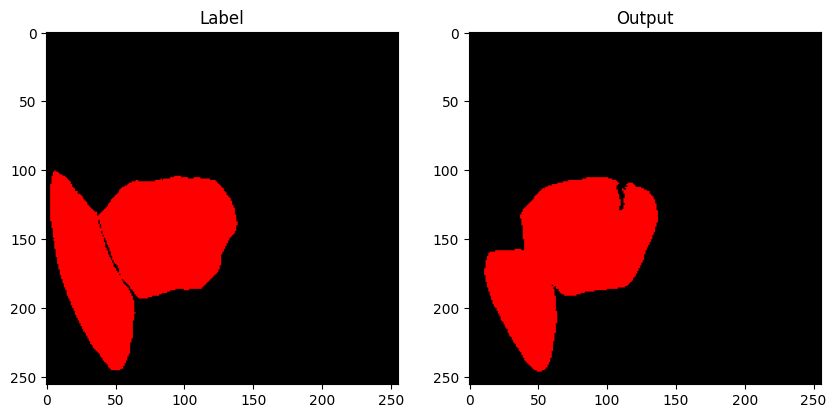

Epoch [100/200], Loss: 0.0730129029


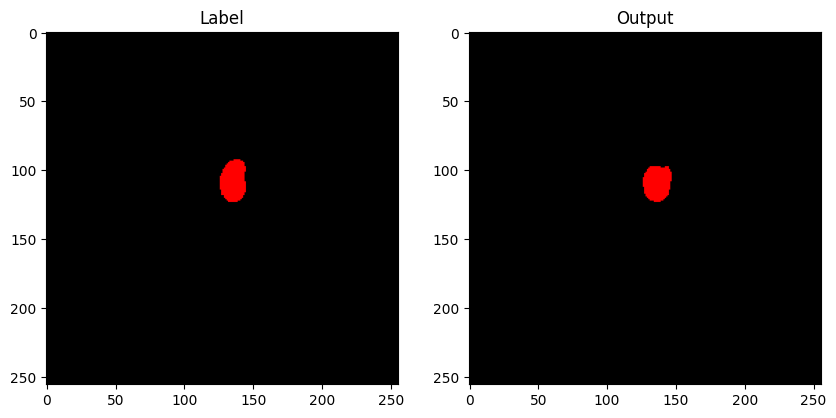

Epoch [101/200], Loss: 0.0782684495


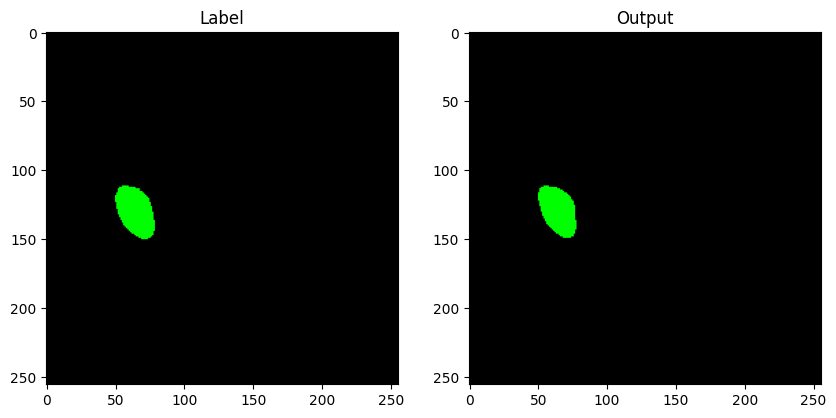

Epoch [102/200], Loss: 0.0840823420


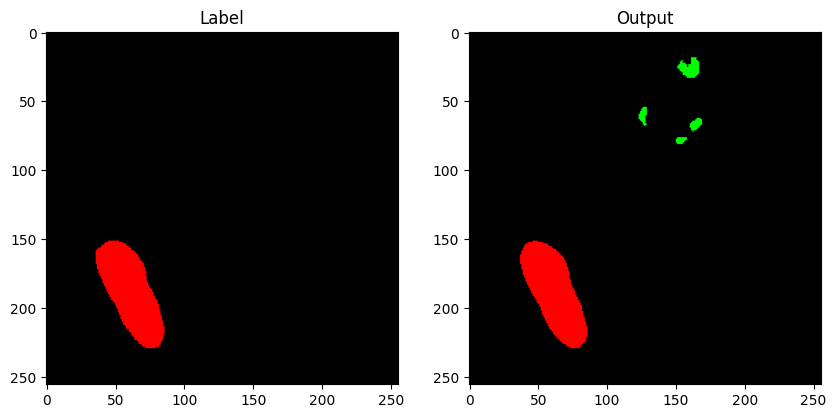

Epoch [103/200], Loss: 0.0750355401


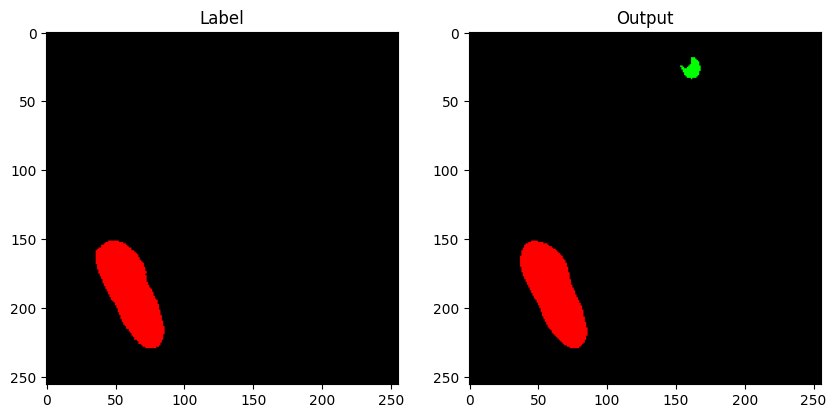

Epoch [104/200], Loss: 0.1060499957


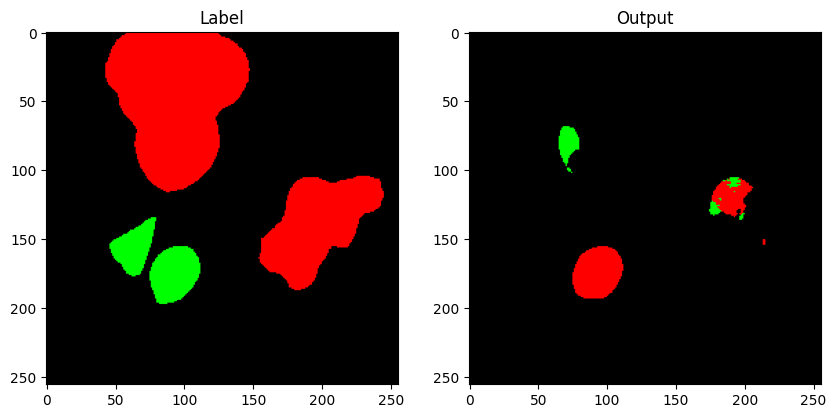

Epoch [105/200], Loss: 0.0652364266


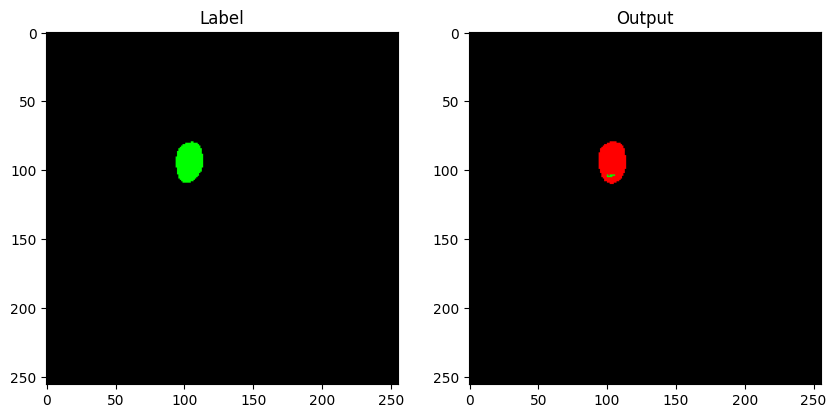

Epoch [106/200], Loss: 0.0740751885


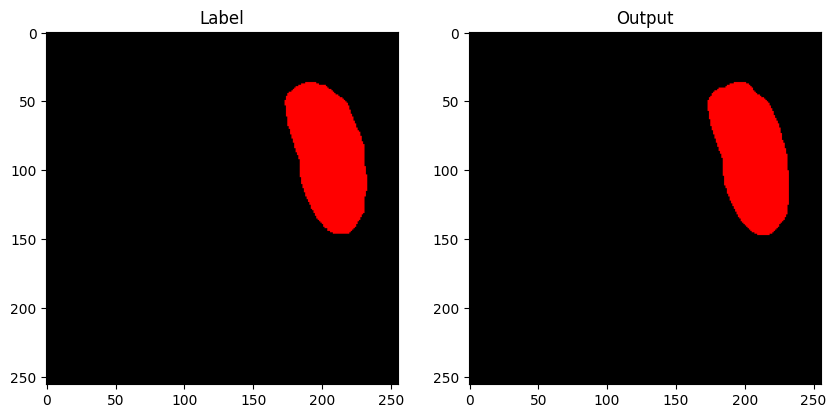

Epoch [107/200], Loss: 0.0612261673


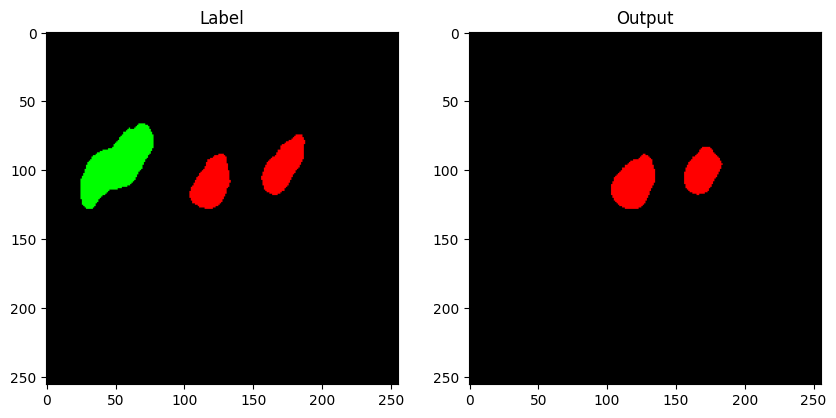

Epoch [108/200], Loss: 0.0681359986


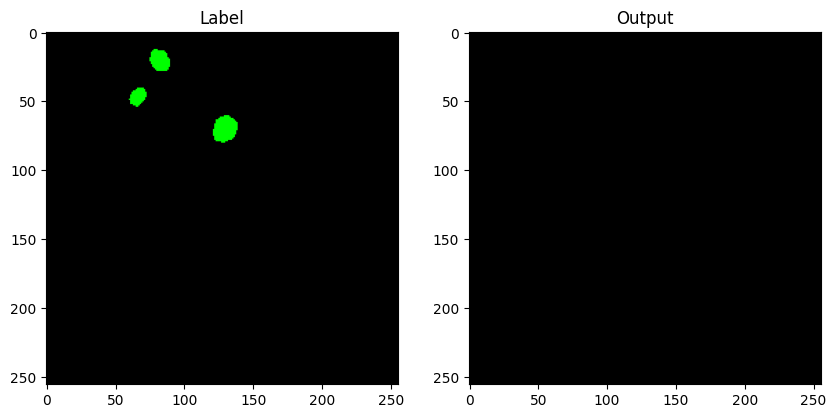

Epoch [109/200], Loss: 0.0735866811


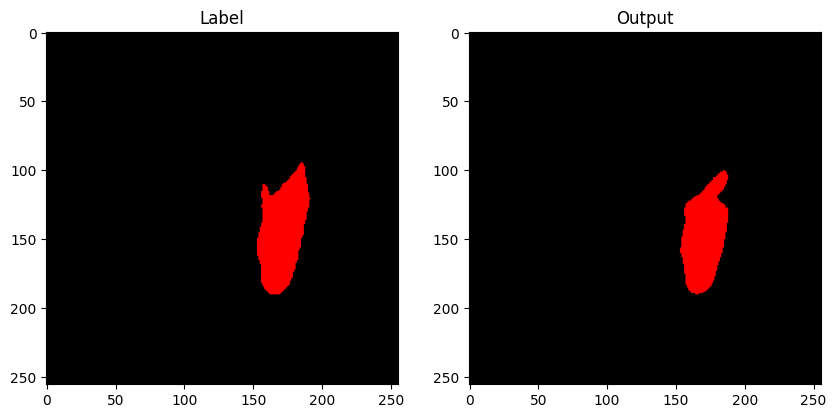

Epoch [110/200], Loss: 0.0715577930


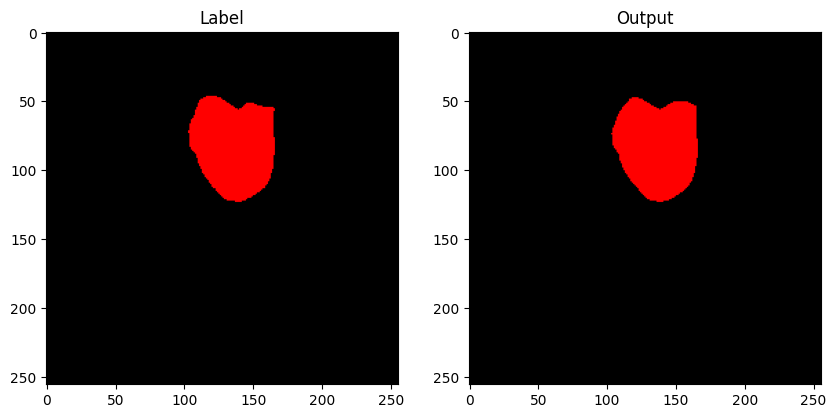

Epoch [111/200], Loss: 0.0775512081


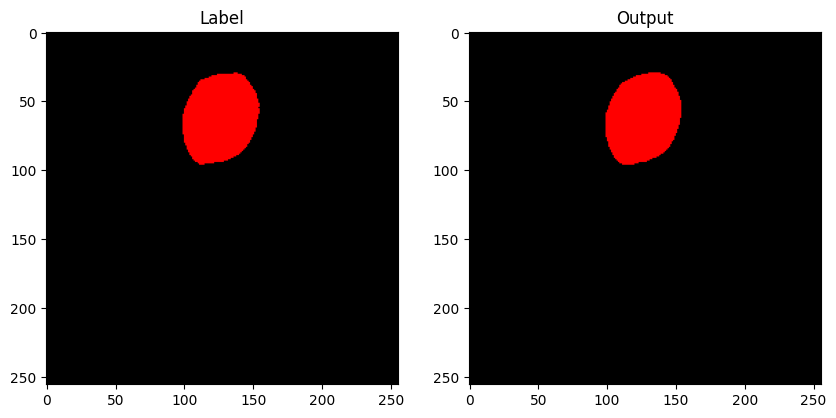

Epoch [112/200], Loss: 0.0780551999


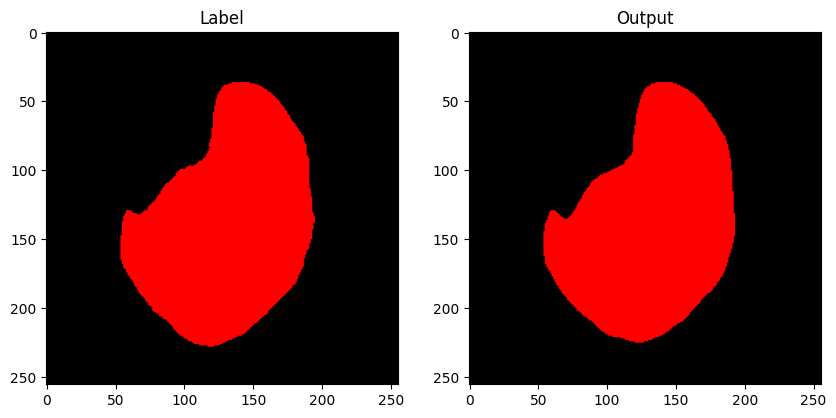

Epoch [113/200], Loss: 0.0760819383


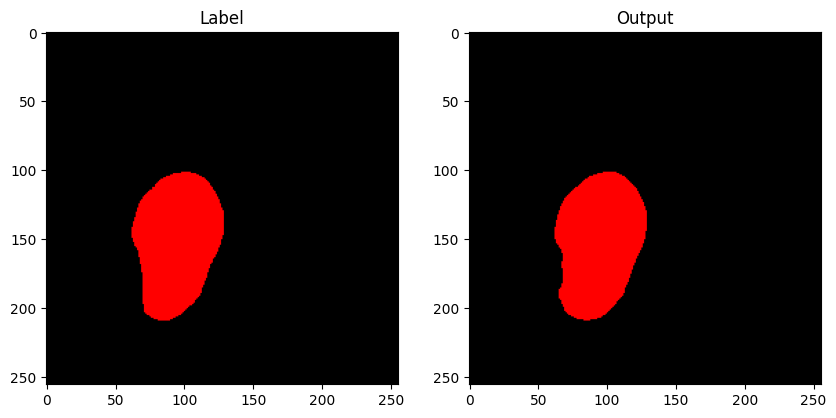

Epoch [114/200], Loss: 0.0784286714


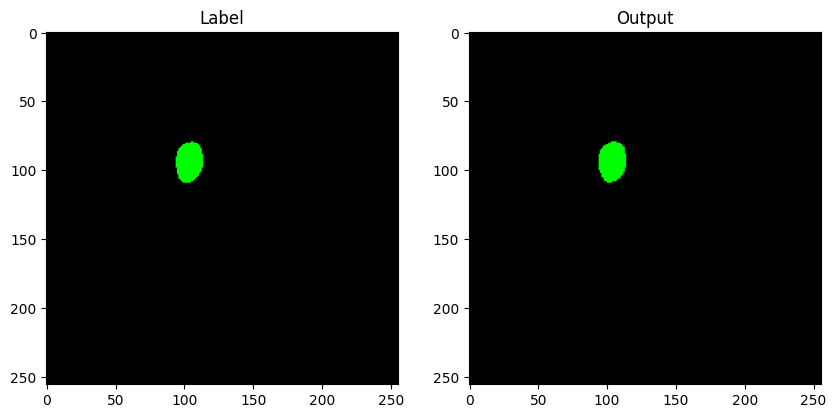

Epoch [115/200], Loss: 0.0776949579


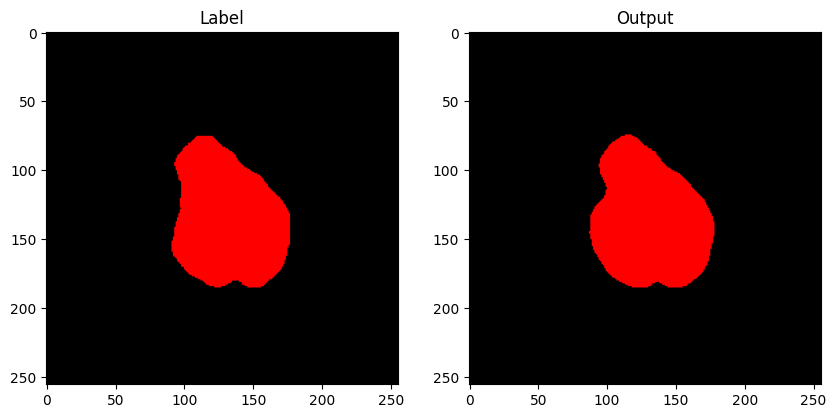

Epoch [116/200], Loss: 0.0749613676


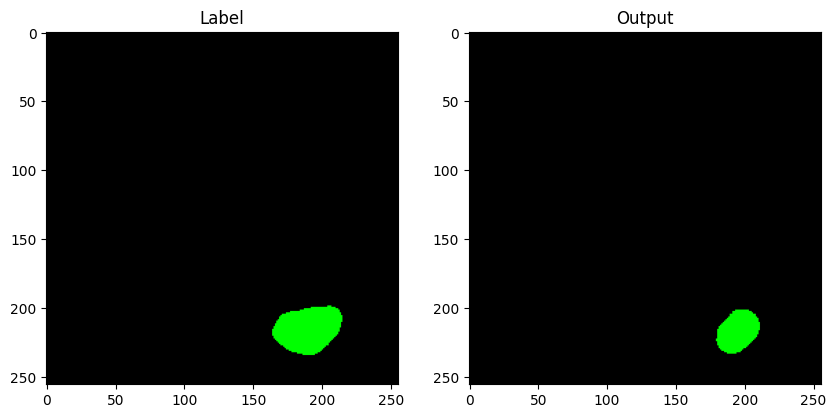

Epoch [117/200], Loss: 0.0812928004


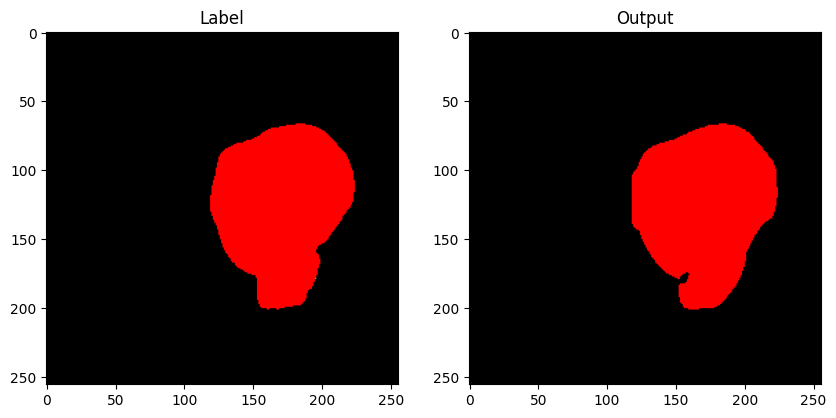

Epoch [118/200], Loss: 0.0822889083


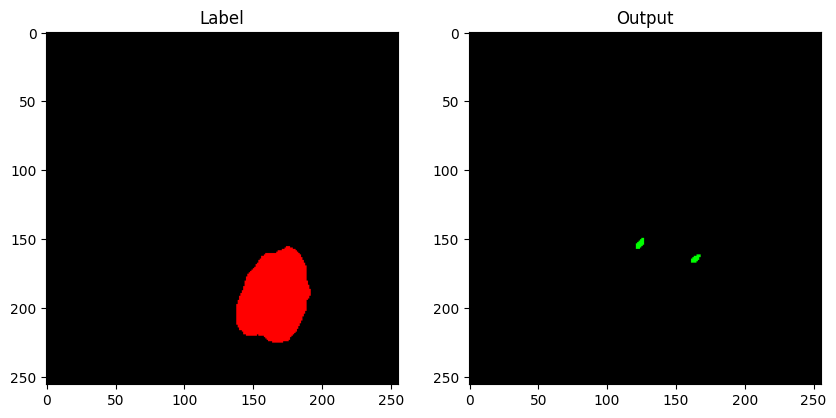

Epoch [119/200], Loss: 0.0823288014


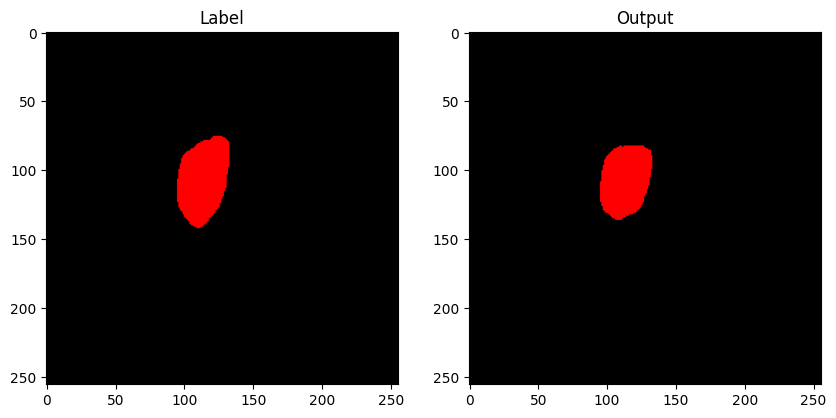

Epoch [120/200], Loss: 0.0926683547


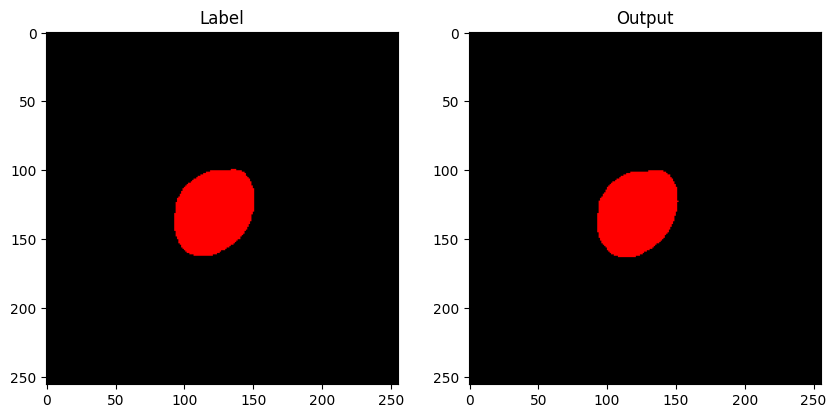

Epoch [121/200], Loss: 0.0861921239


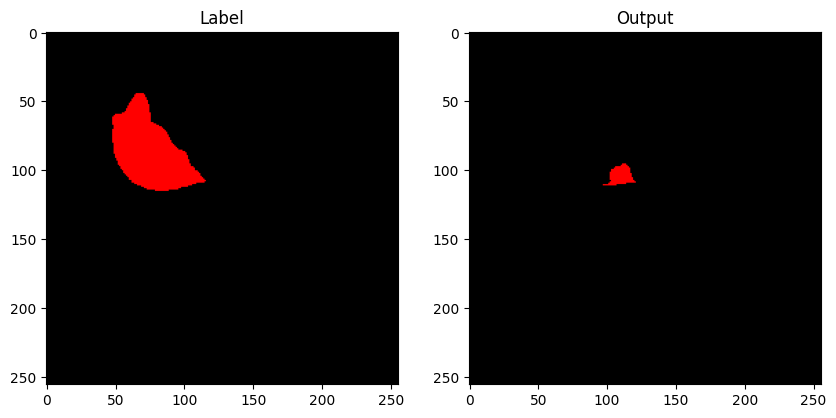

Epoch [122/200], Loss: 0.0893048863


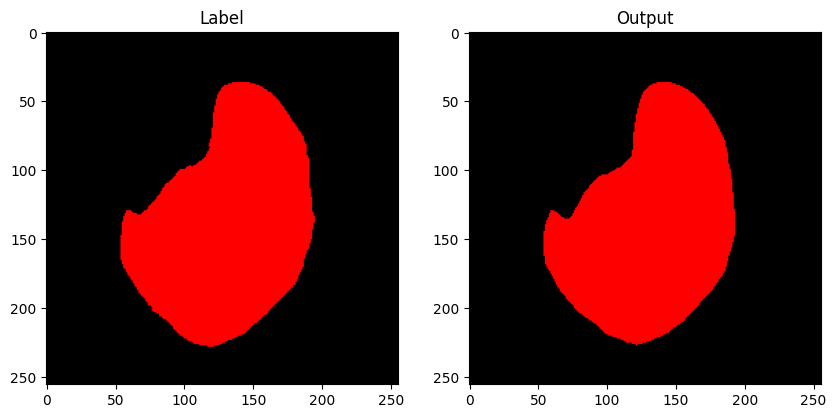

Epoch [123/200], Loss: 0.0838434329


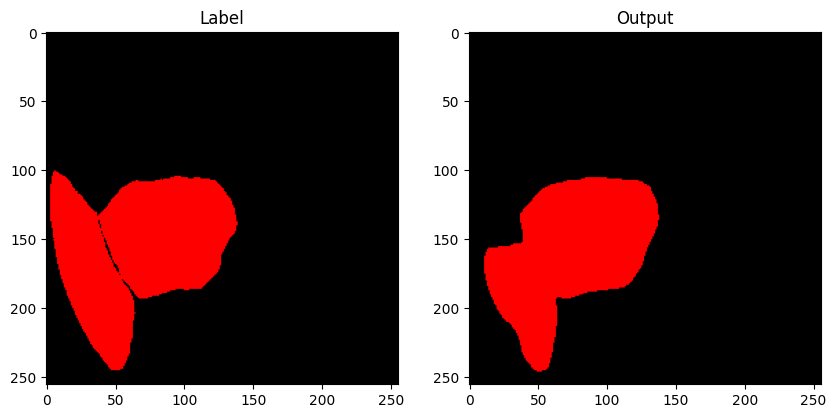

Epoch [124/200], Loss: 0.0883709131


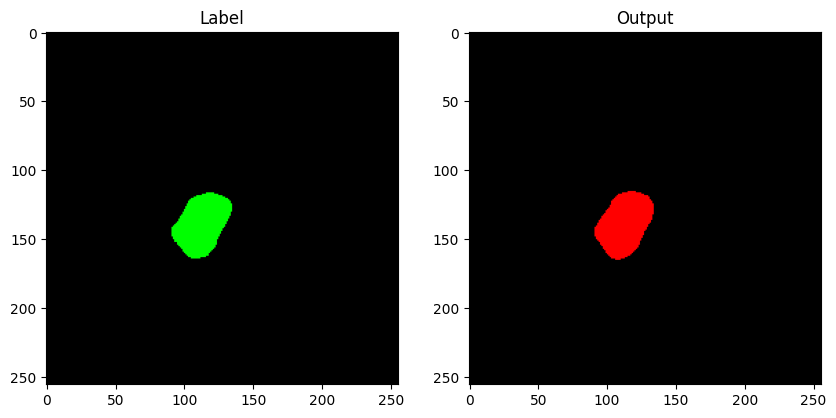

Epoch [125/200], Loss: 0.0950108934


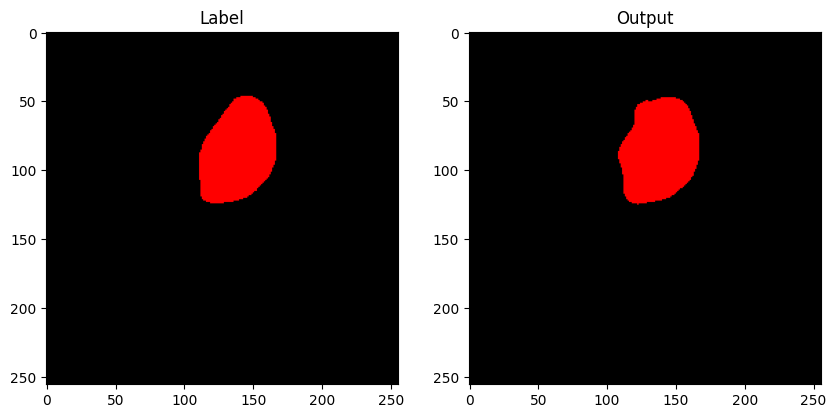

Epoch [126/200], Loss: 0.0931407029


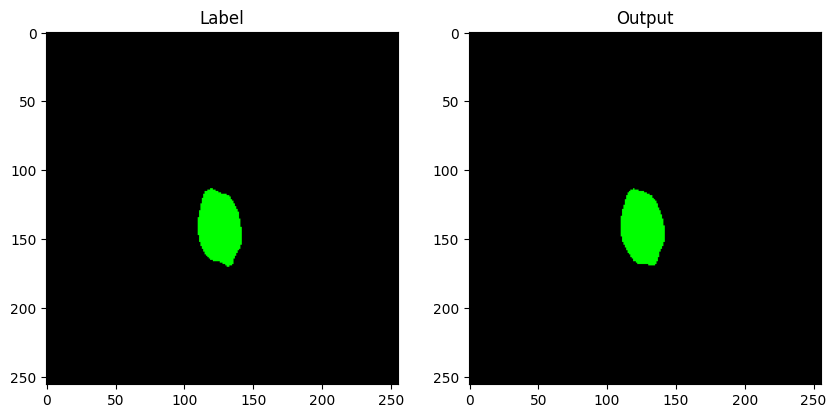

Epoch [127/200], Loss: 0.0842757840


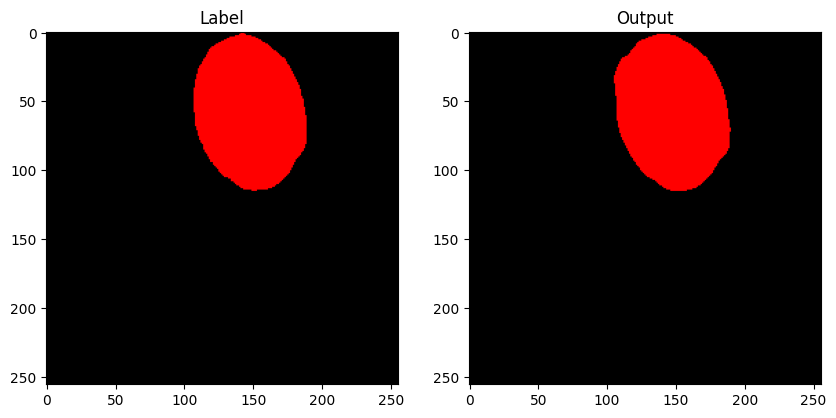

Epoch [128/200], Loss: 0.0883633168


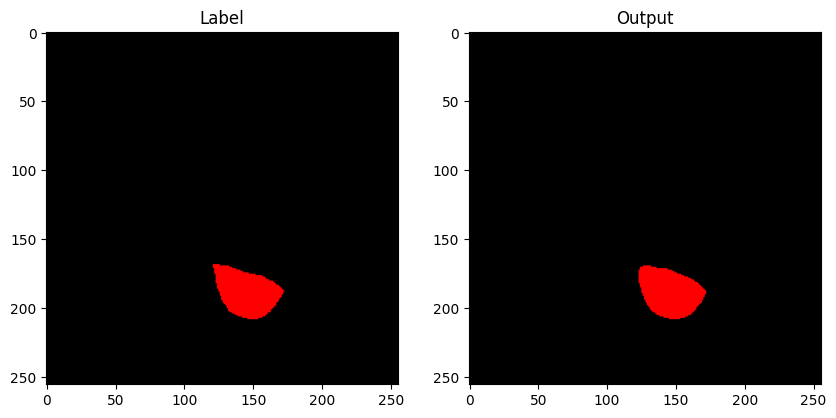

Epoch [129/200], Loss: 0.0856786895


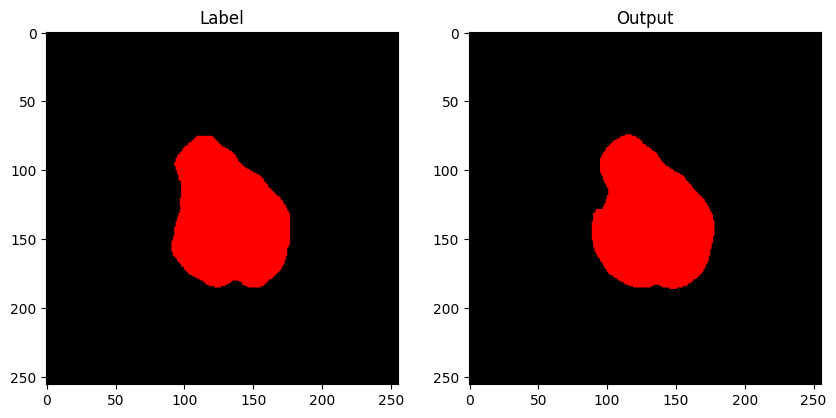

Epoch [130/200], Loss: 0.0961968624


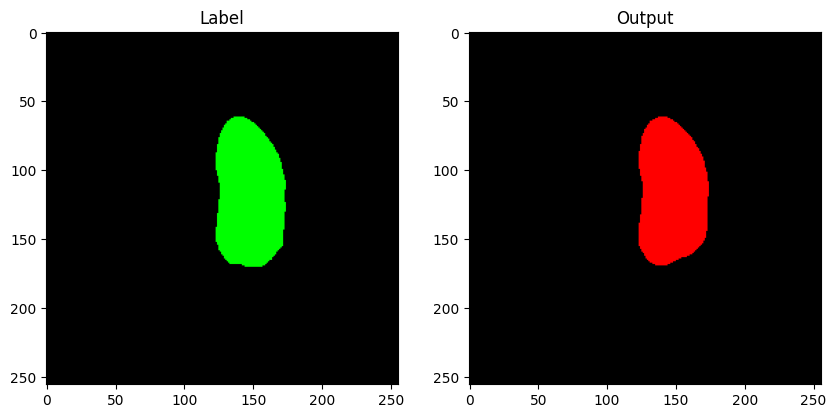

Epoch [131/200], Loss: 0.0888680348


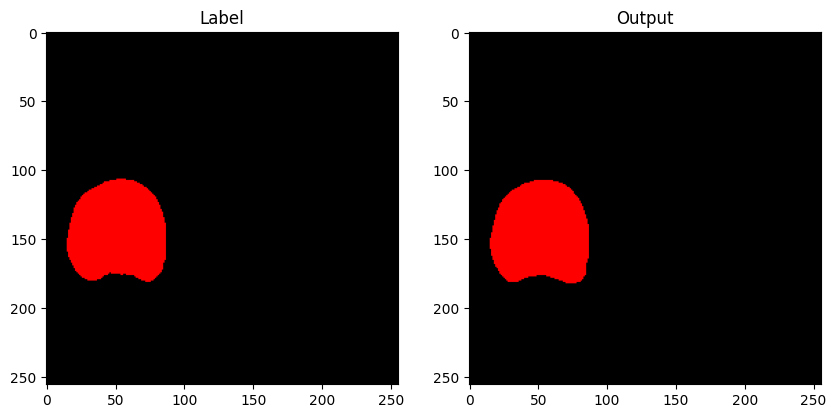

Epoch [132/200], Loss: 0.0925038893


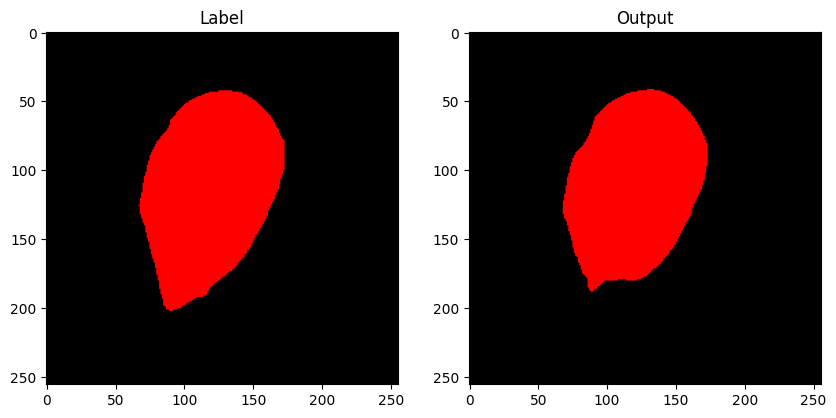

Epoch [133/200], Loss: 0.0889160242


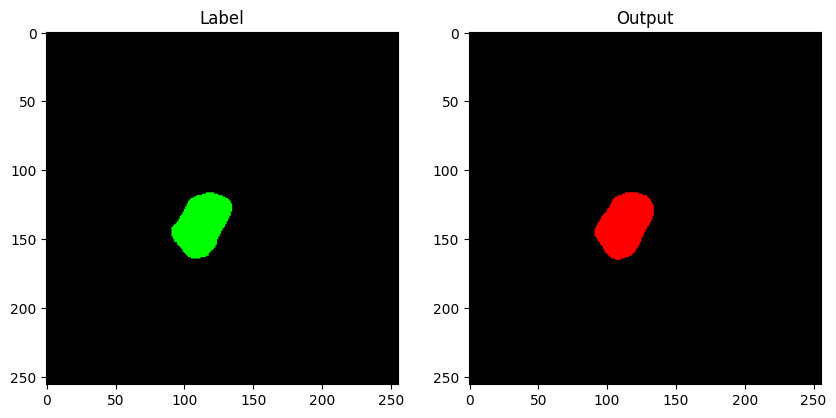

Epoch [134/200], Loss: 0.0957735639


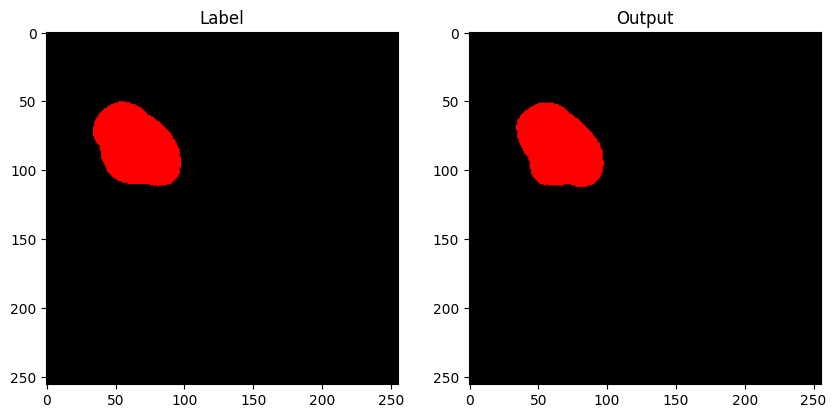

Epoch [135/200], Loss: 0.0904260249


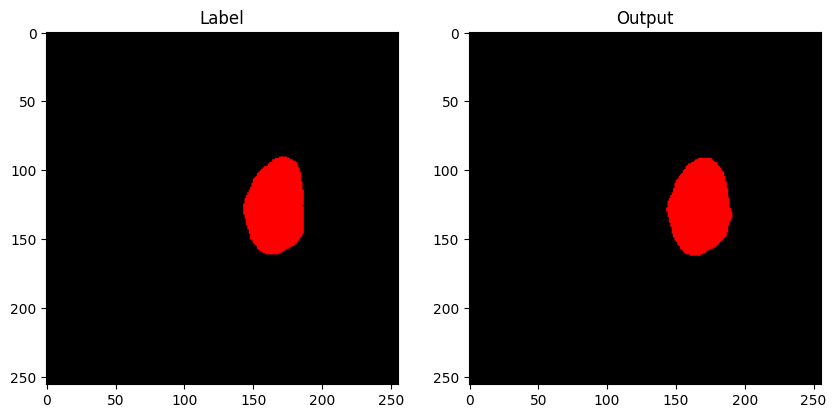

Epoch [136/200], Loss: 0.0873315445


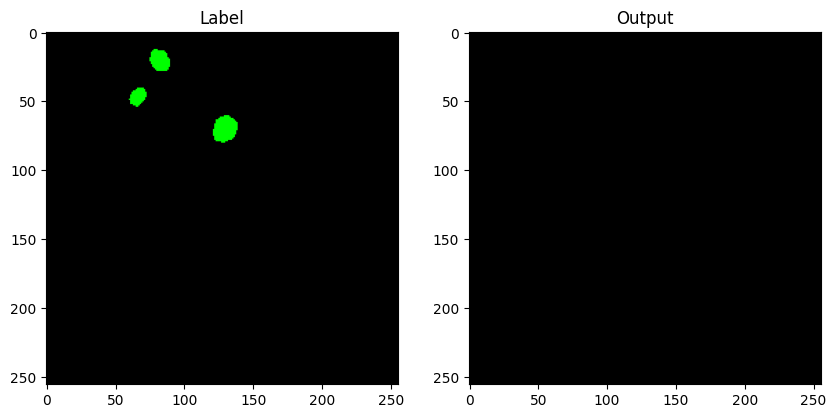

Epoch [137/200], Loss: 0.0918912295


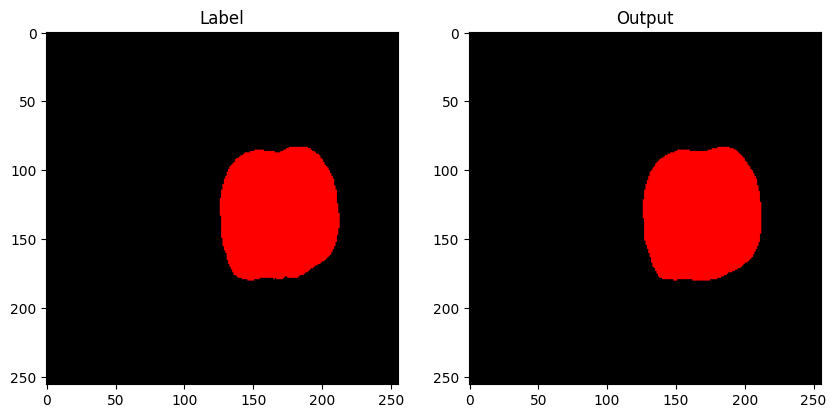

Epoch [138/200], Loss: 0.0924089290


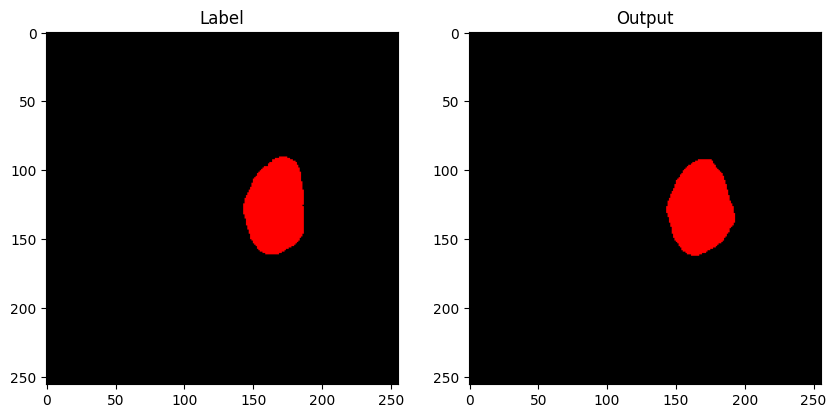

Epoch [139/200], Loss: 0.0842102292


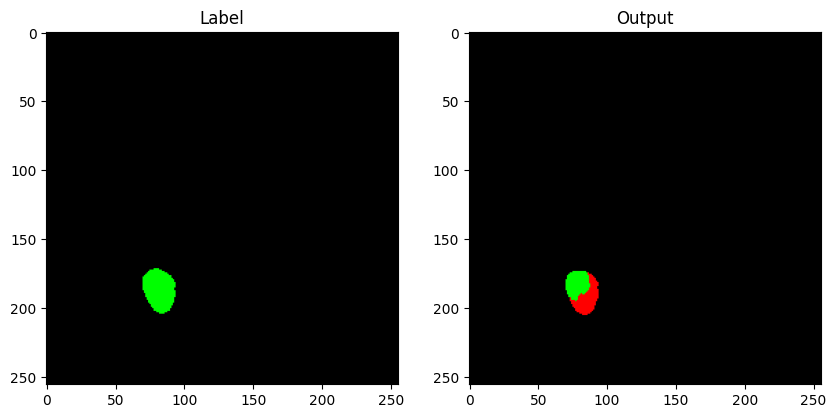

Epoch [140/200], Loss: 0.0866267217


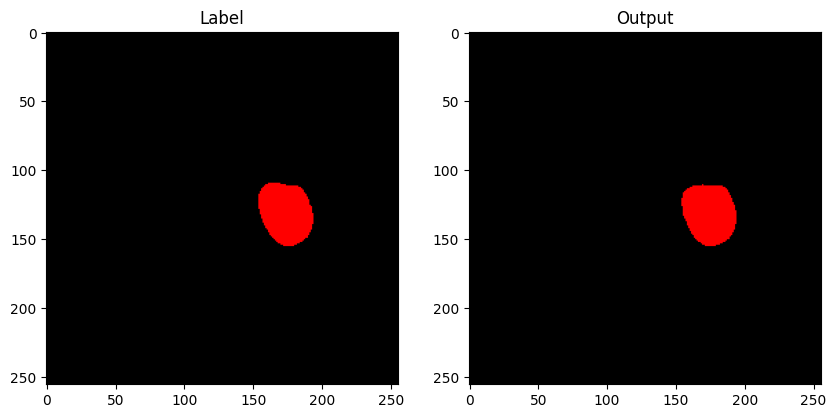

Epoch [141/200], Loss: 0.0915487425


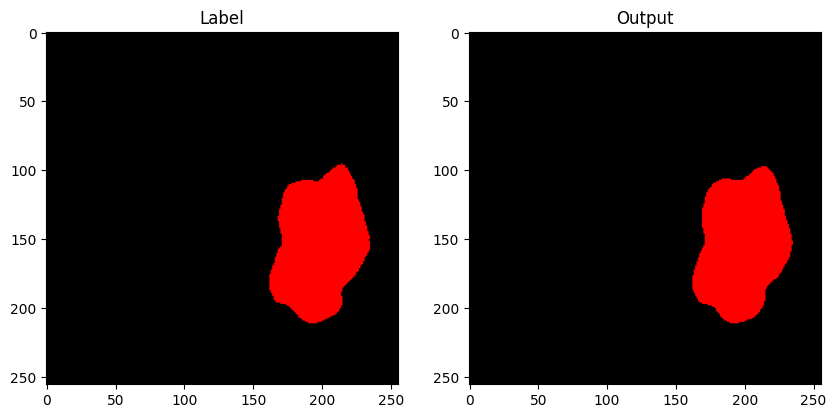

Epoch [142/200], Loss: 0.0802784905


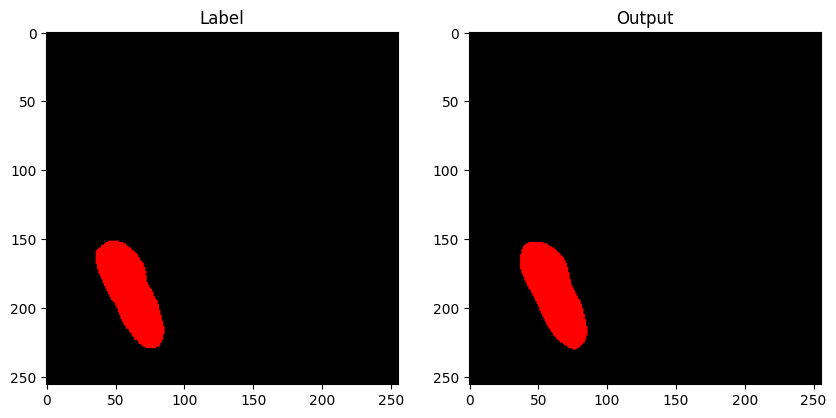

Epoch [143/200], Loss: 0.0795388322


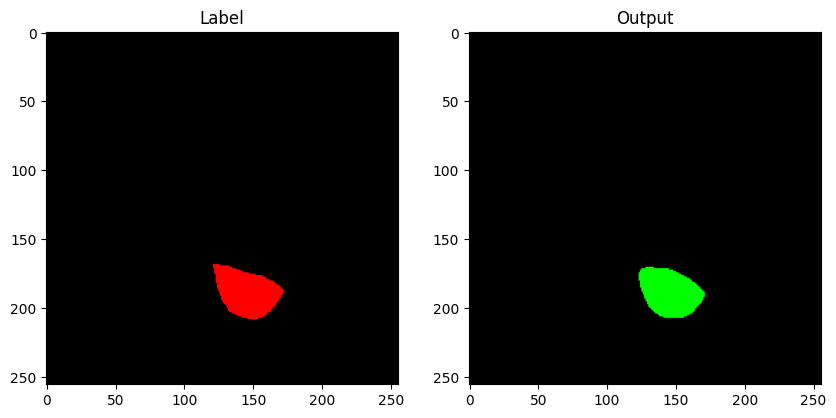

Epoch [144/200], Loss: 0.0751120401


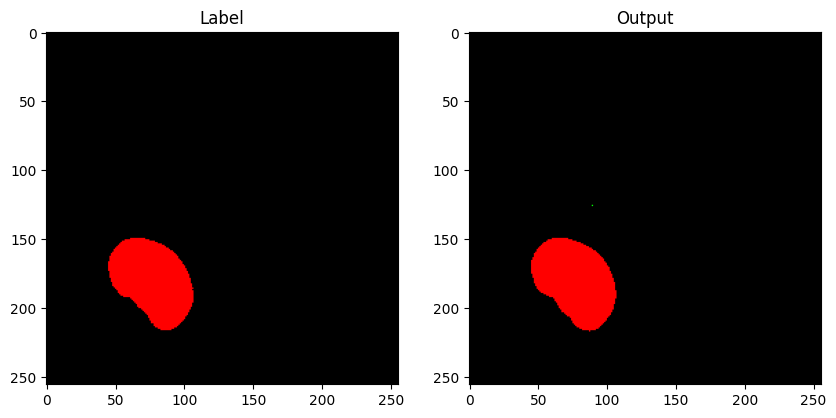

Epoch [145/200], Loss: 0.0972996681


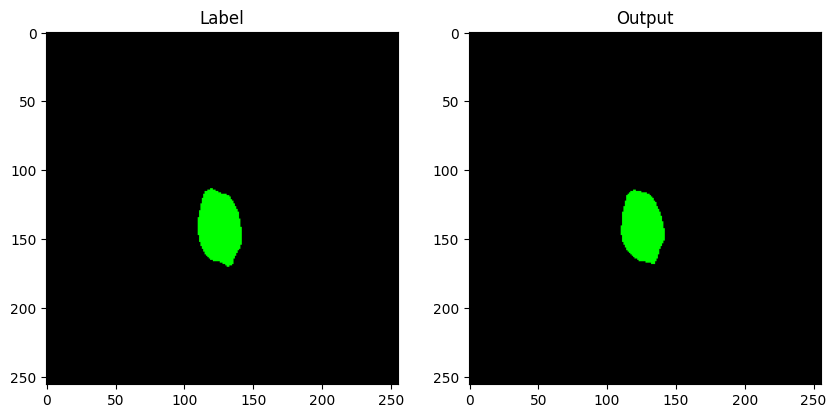

Epoch [146/200], Loss: 0.0801343762


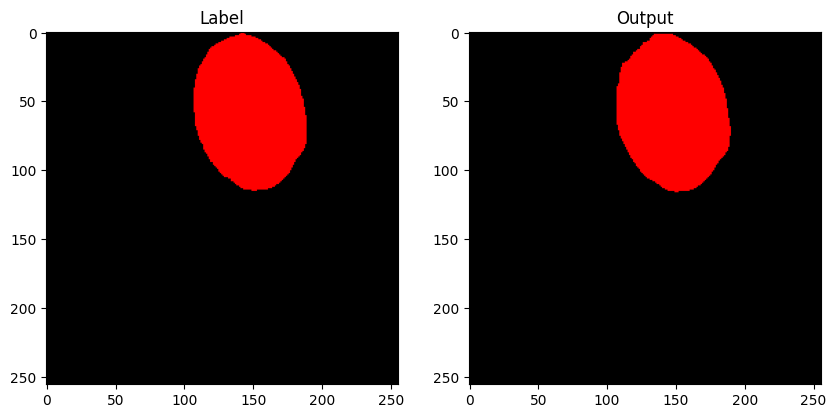

Epoch [147/200], Loss: 0.0660101576


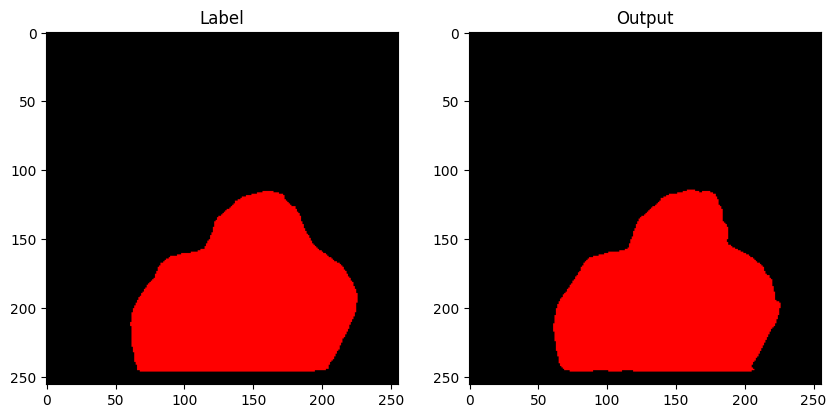

Epoch [148/200], Loss: 0.0687039267


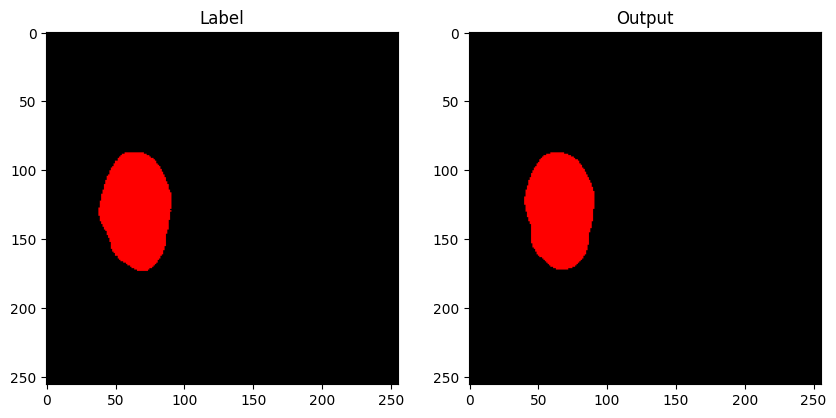

Epoch [149/200], Loss: 0.0640083117


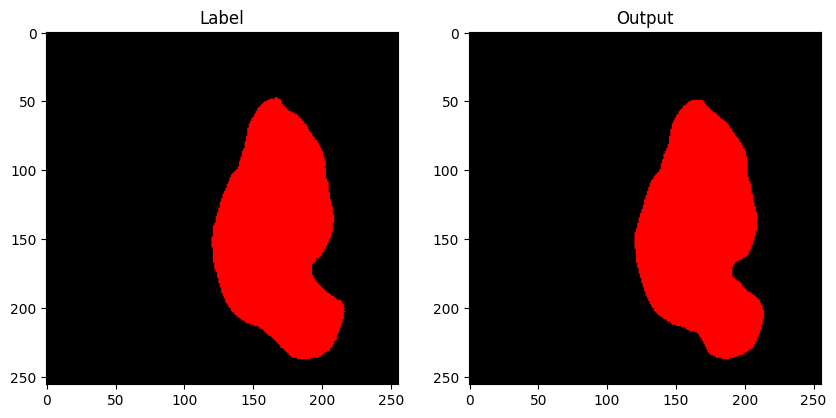

Epoch [150/200], Loss: 0.0720458589


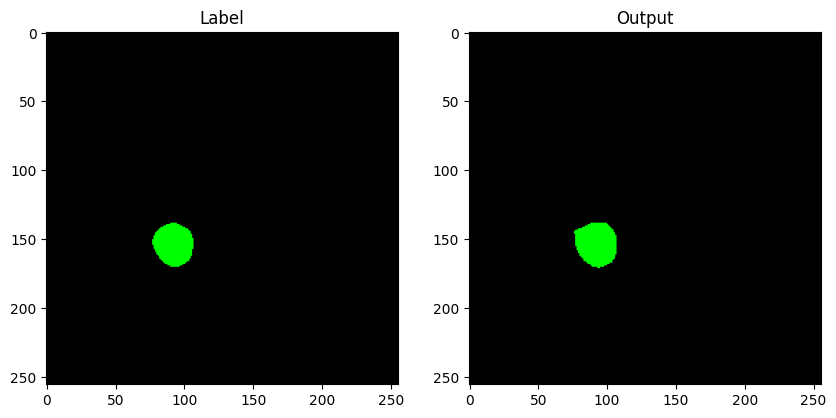

Epoch [151/200], Loss: 0.0775852535


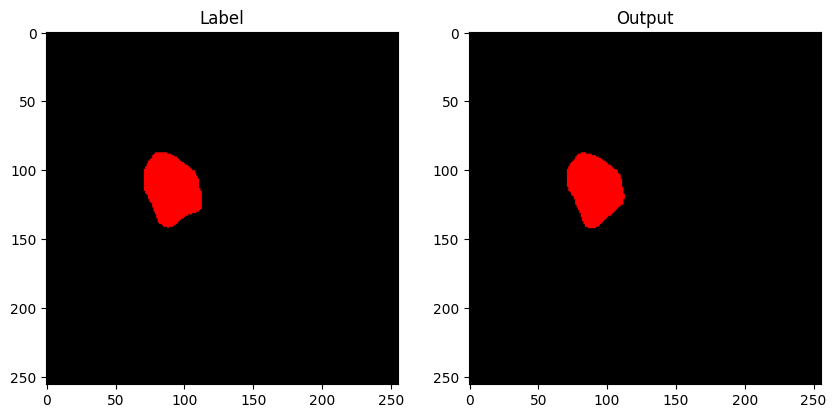

Epoch [152/200], Loss: 0.0768441376


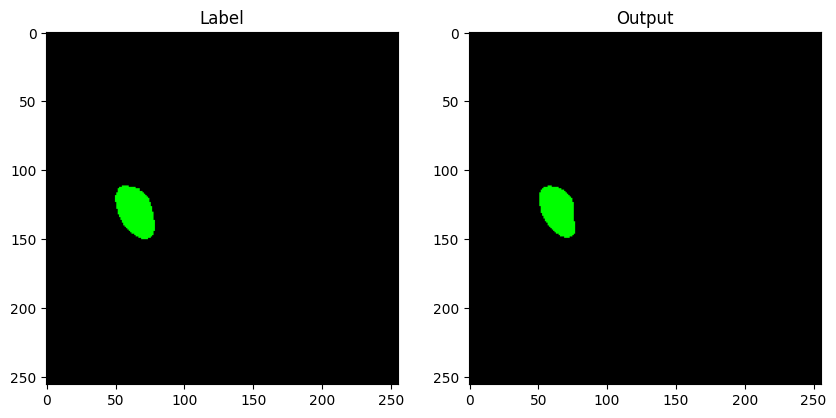

Epoch [153/200], Loss: 0.0788701840


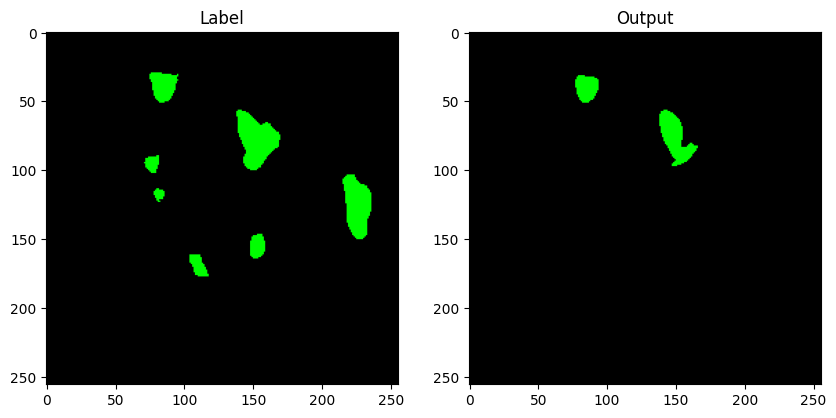

Epoch [154/200], Loss: 0.0802889620


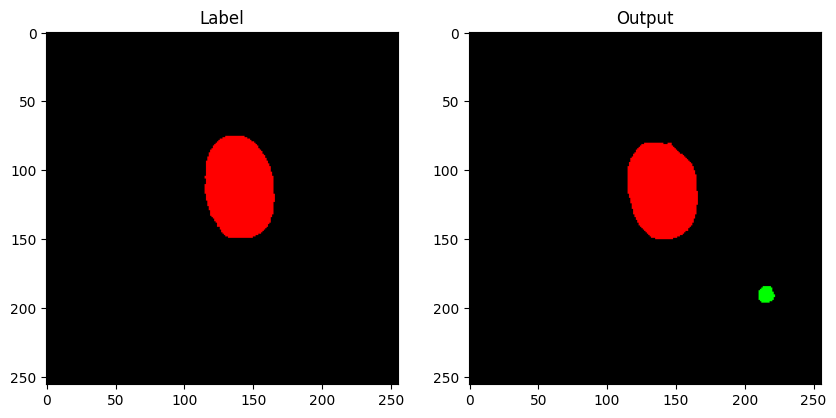

Epoch [155/200], Loss: 0.0792879615


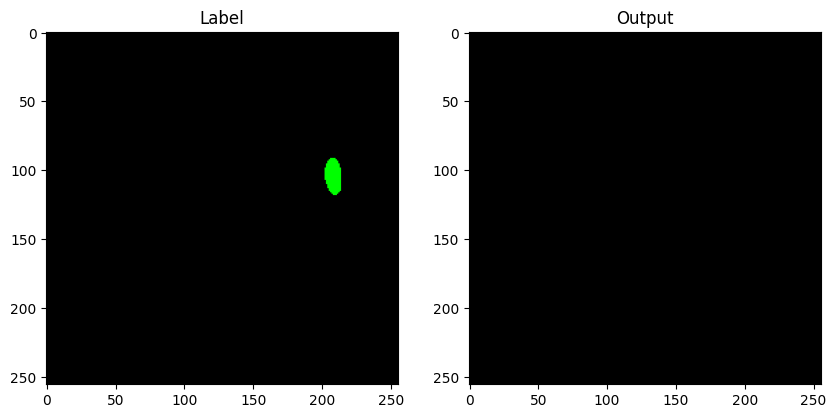

Epoch [156/200], Loss: 0.0799430332


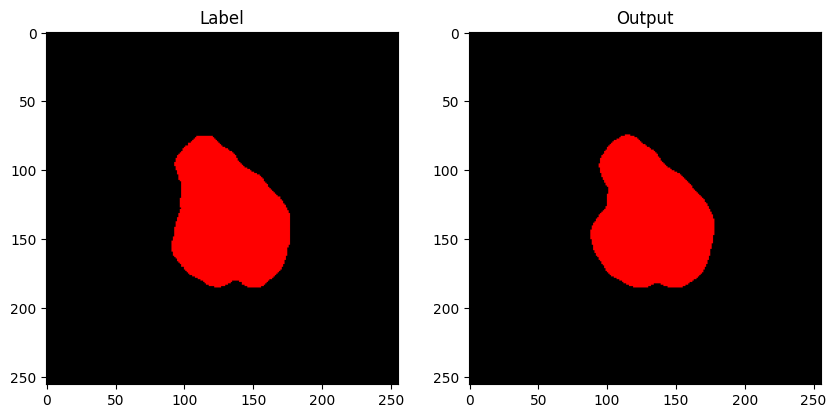

Epoch [157/200], Loss: 0.0803007693


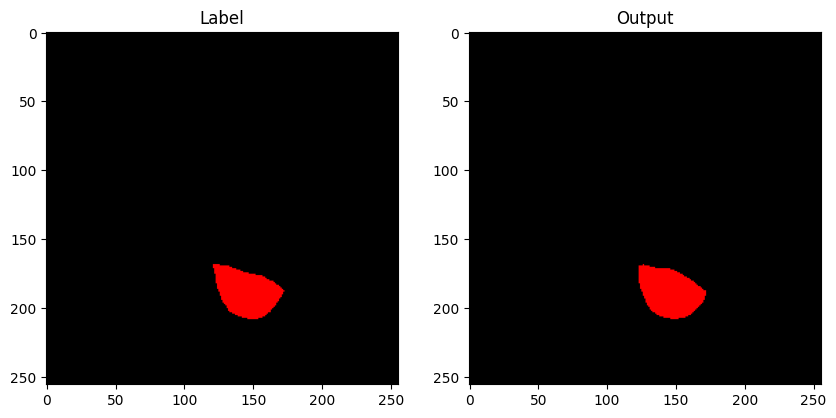

Epoch [158/200], Loss: 0.0831955977


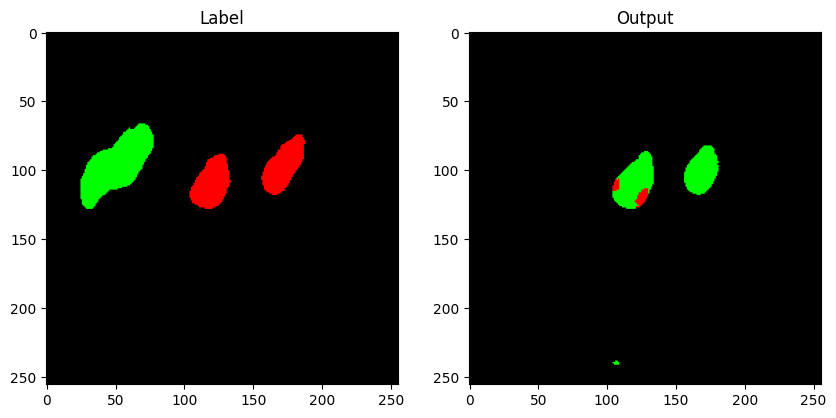

Epoch [159/200], Loss: 0.0791798349


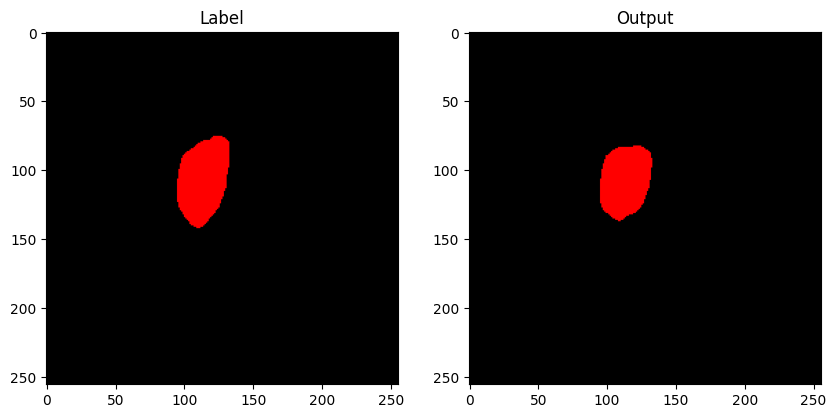

Epoch [160/200], Loss: 0.0772398793


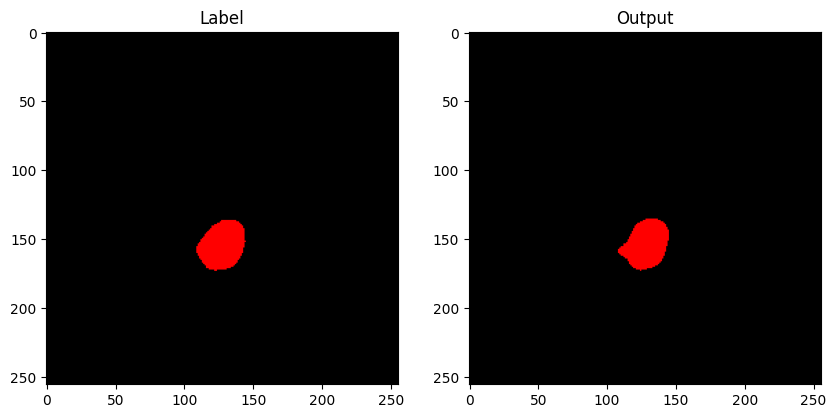

Epoch [161/200], Loss: 0.0761909963


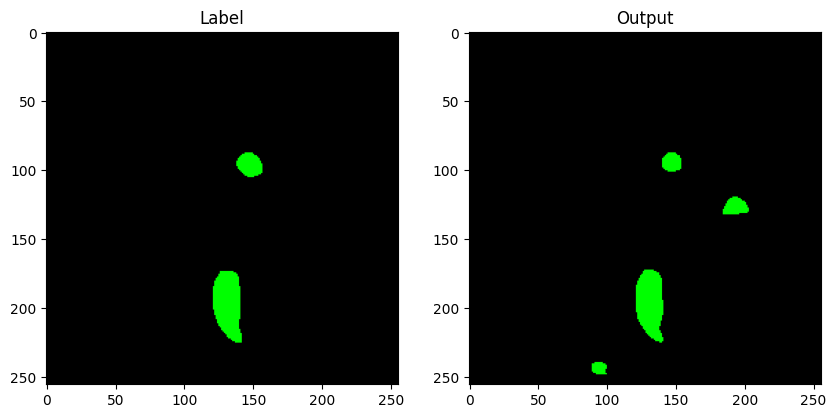

Epoch [162/200], Loss: 0.0823874947


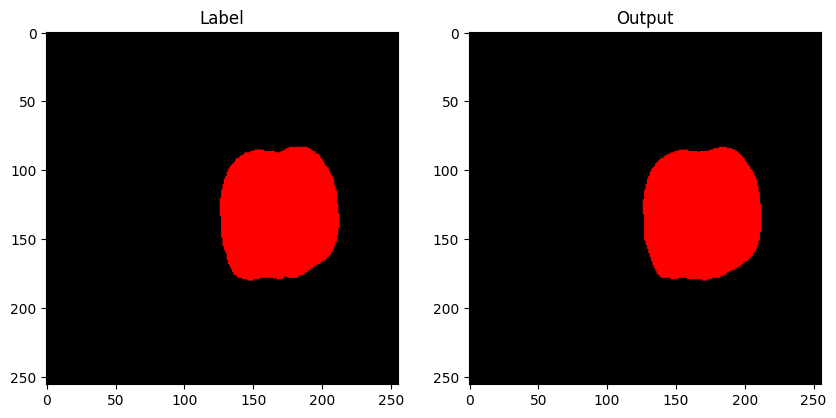

Epoch [163/200], Loss: 0.0788033726


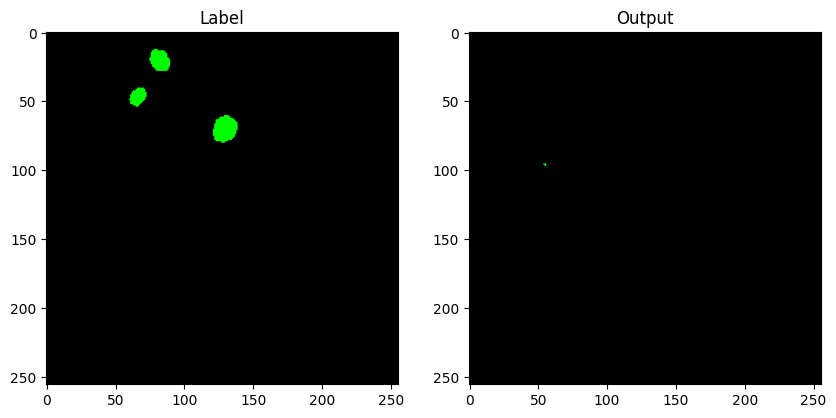

Epoch [164/200], Loss: 0.0836987378


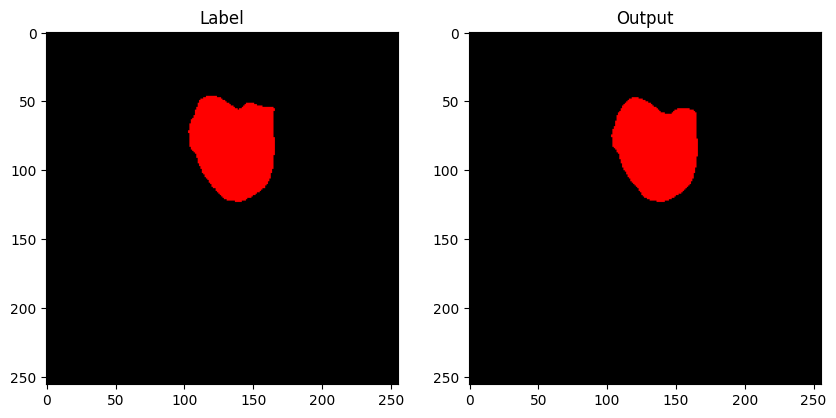

Epoch [165/200], Loss: 0.0839080652


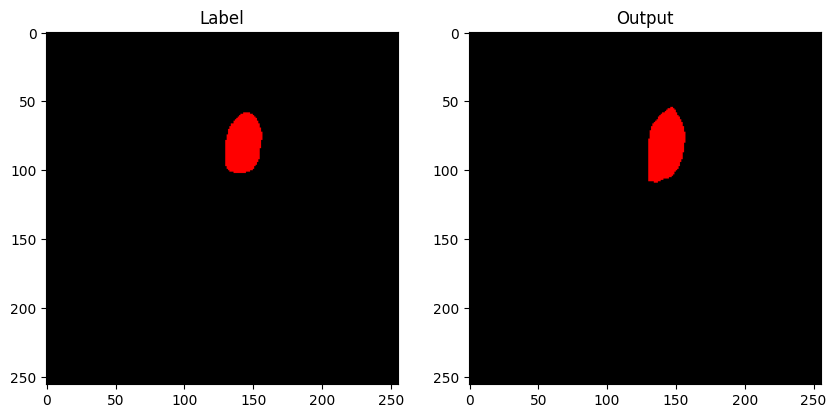

Epoch [166/200], Loss: 0.0843676035


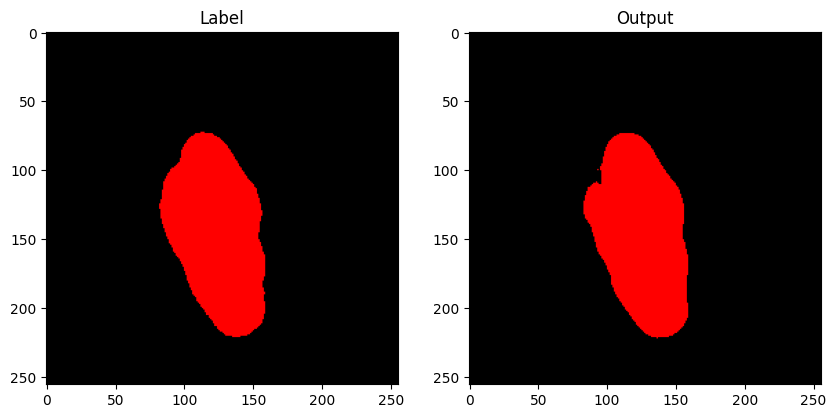

Epoch [167/200], Loss: 0.0842086191


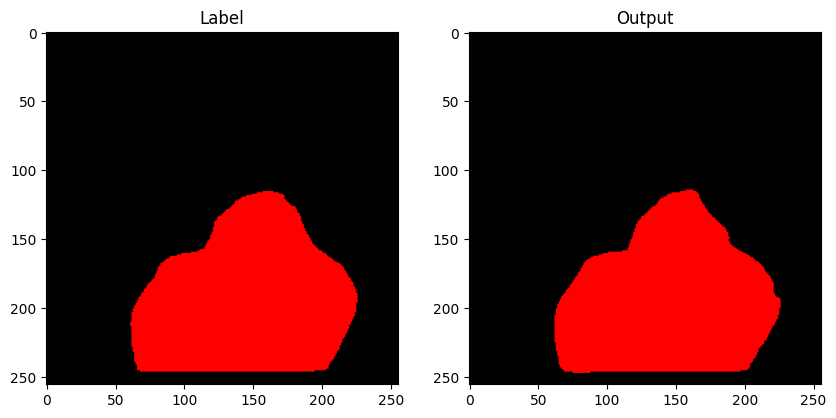

Epoch [168/200], Loss: 0.0831667388


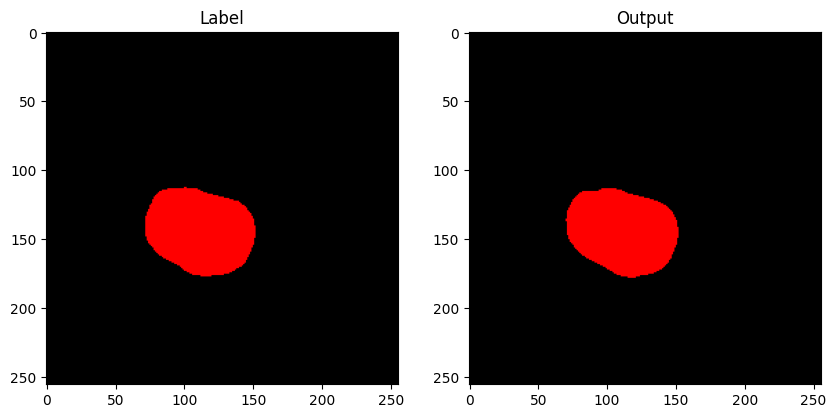

Epoch [169/200], Loss: 0.0878327717


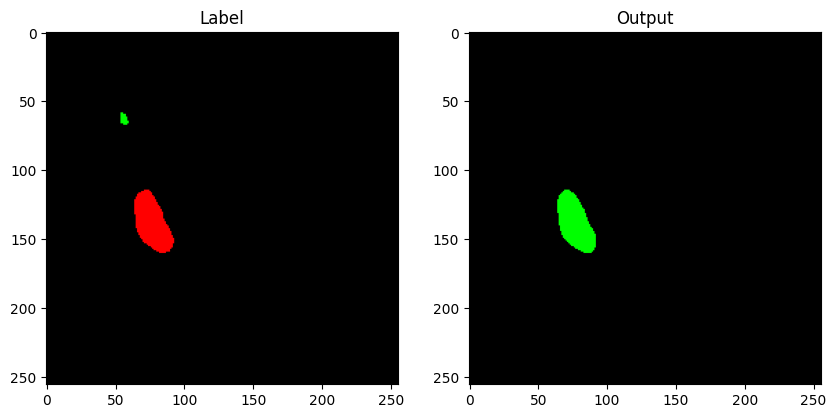

Epoch [170/200], Loss: 0.0805551295


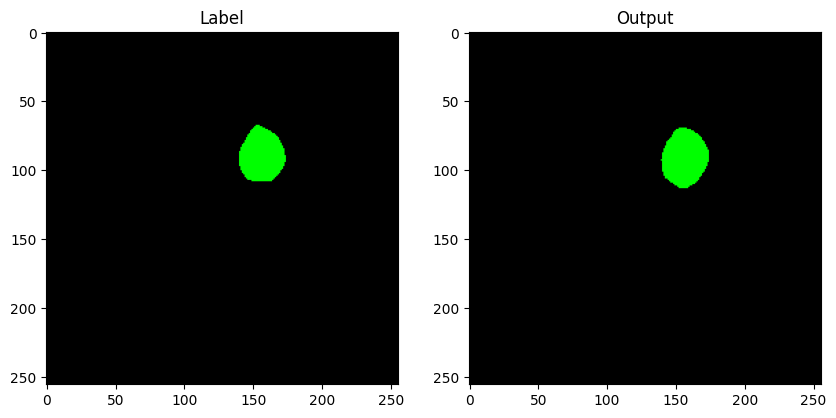

Epoch [171/200], Loss: 0.0837528426


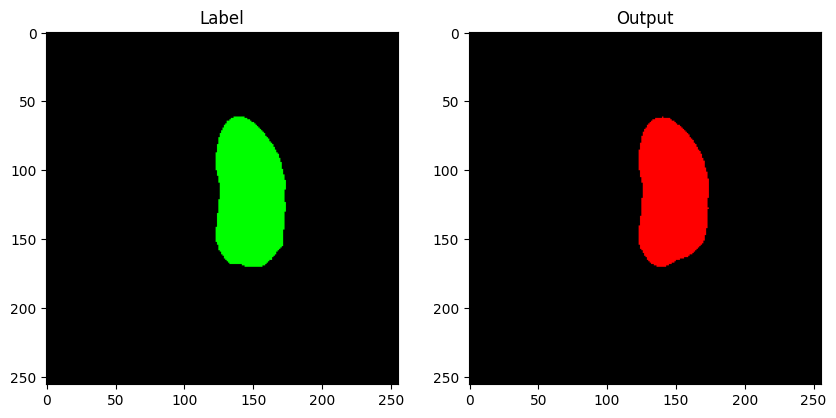

Epoch [172/200], Loss: 0.0809431089


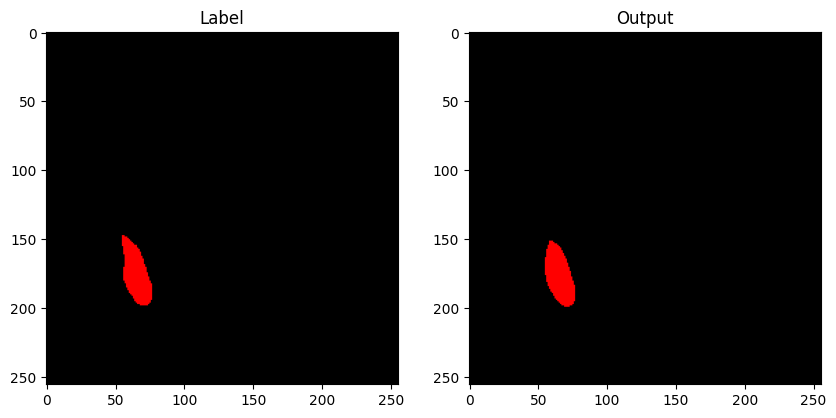

Epoch [173/200], Loss: 0.0735943918


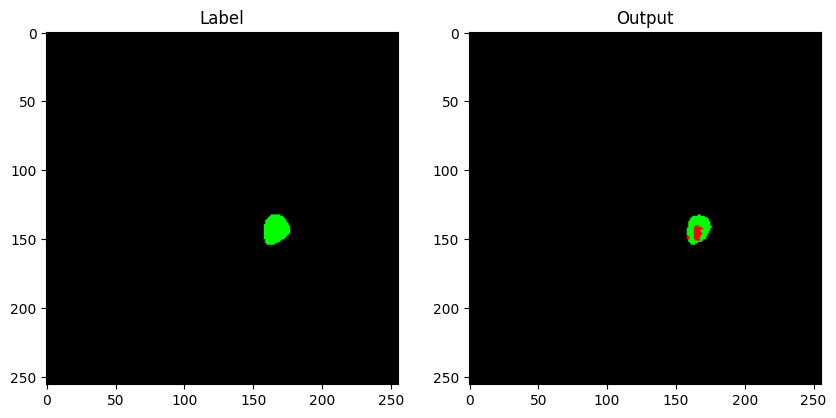

Epoch [174/200], Loss: 0.0760784053


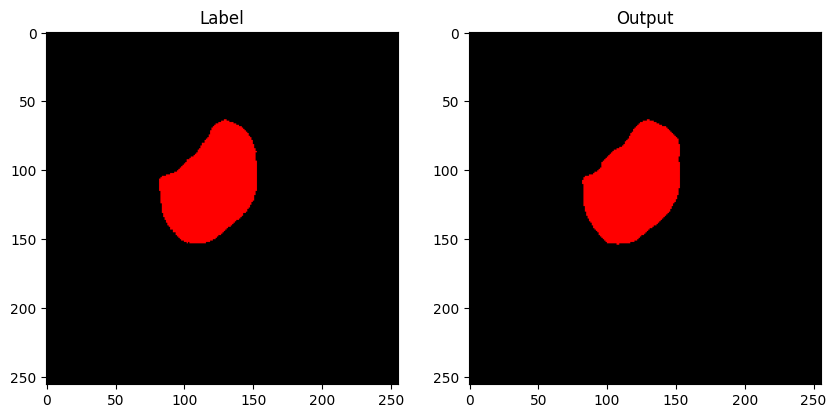

Epoch [175/200], Loss: 0.0862359584


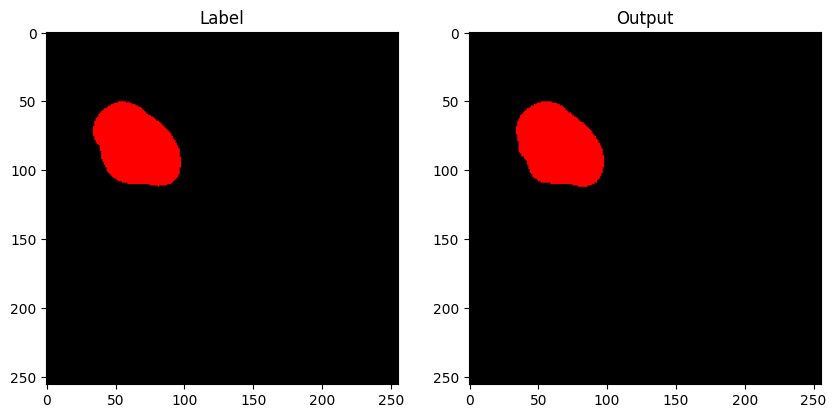

Epoch [176/200], Loss: 0.0785823060


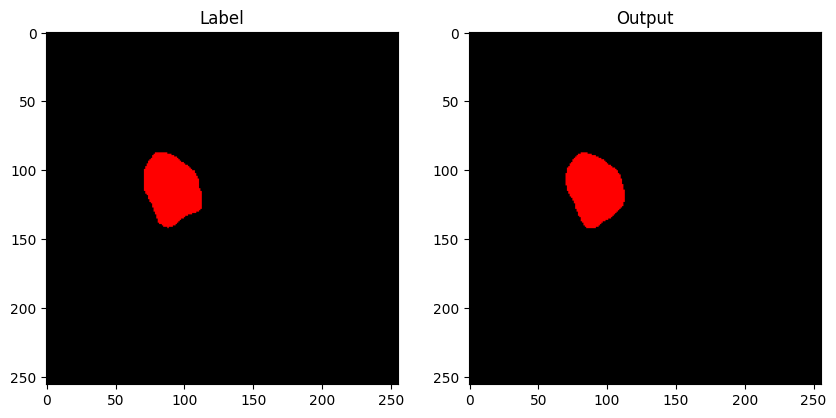

Epoch [177/200], Loss: 0.0667604035


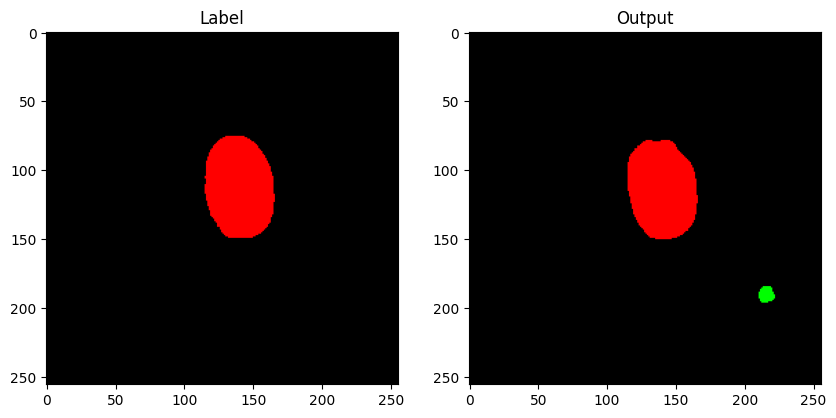

Epoch [178/200], Loss: 0.0687704444


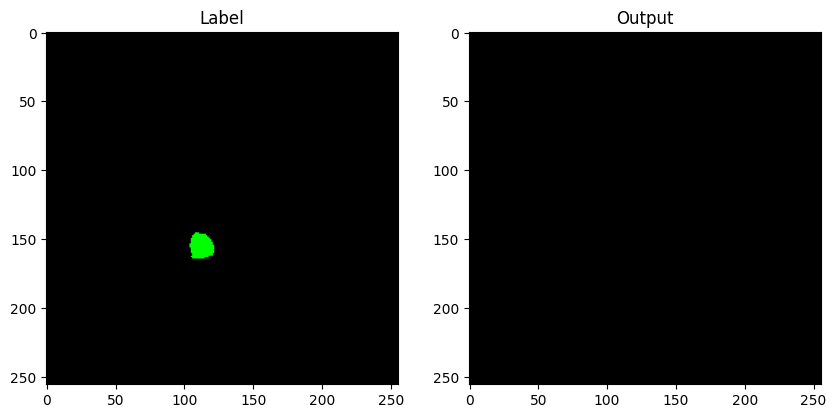

Epoch [179/200], Loss: 0.0846910117


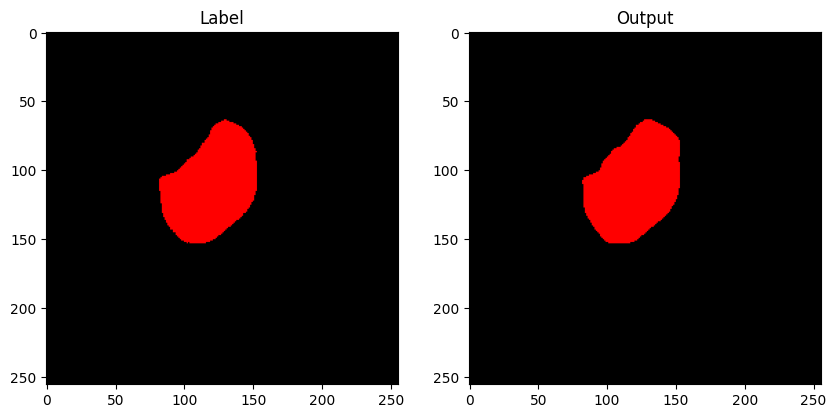

Epoch [180/200], Loss: 0.0811300362


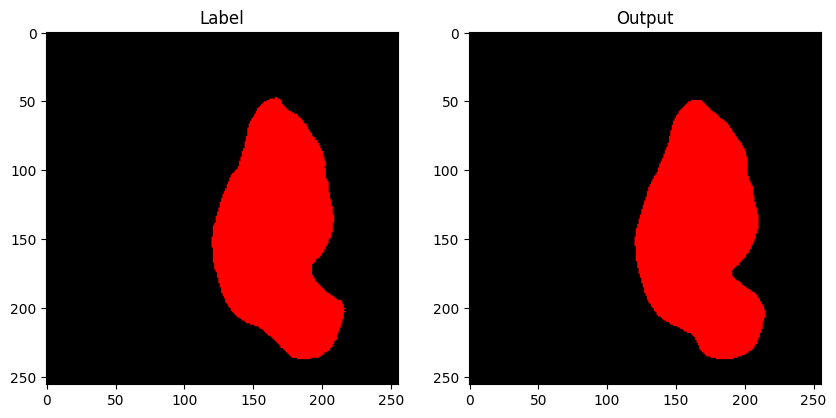

Epoch [181/200], Loss: 0.0760889865


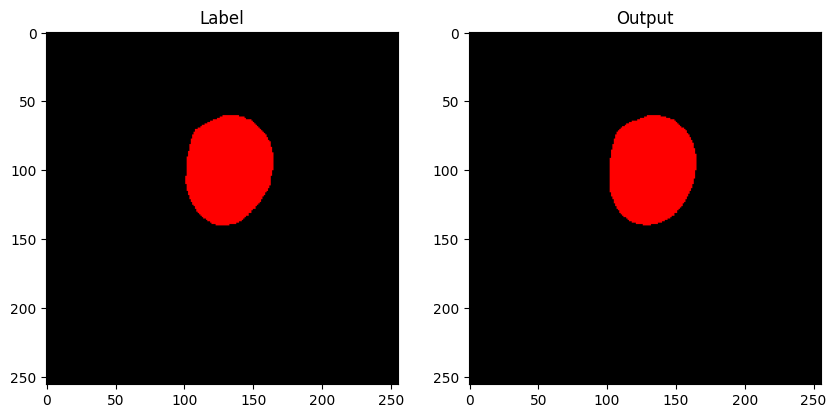

Epoch [182/200], Loss: 0.0766987118


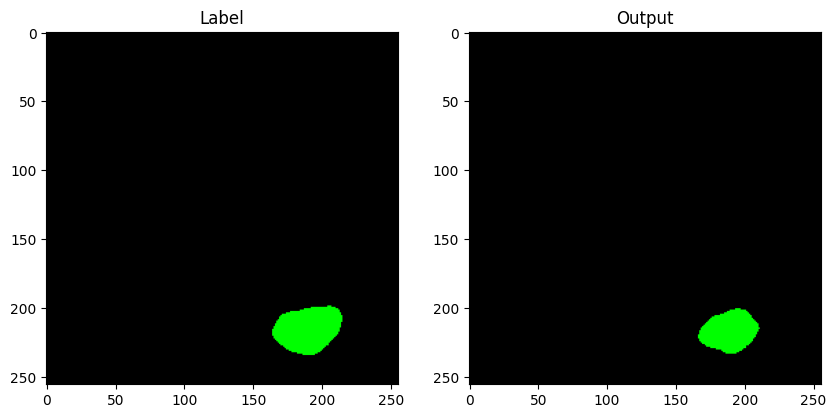

Epoch [183/200], Loss: 0.0812604956


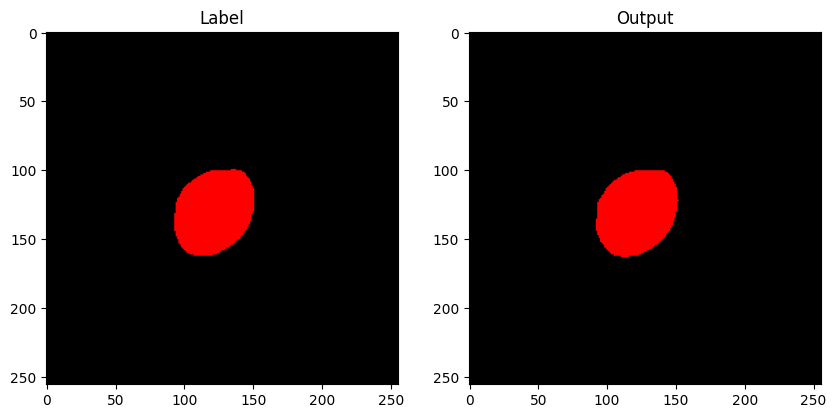

Epoch [184/200], Loss: 0.0792830108


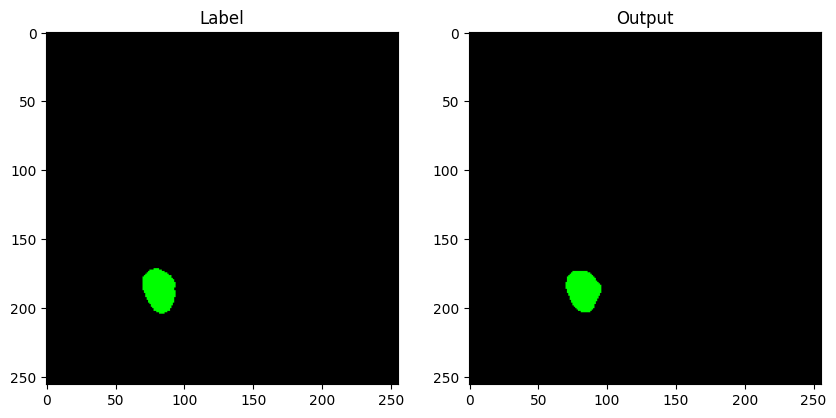

Epoch [185/200], Loss: 0.0956777656


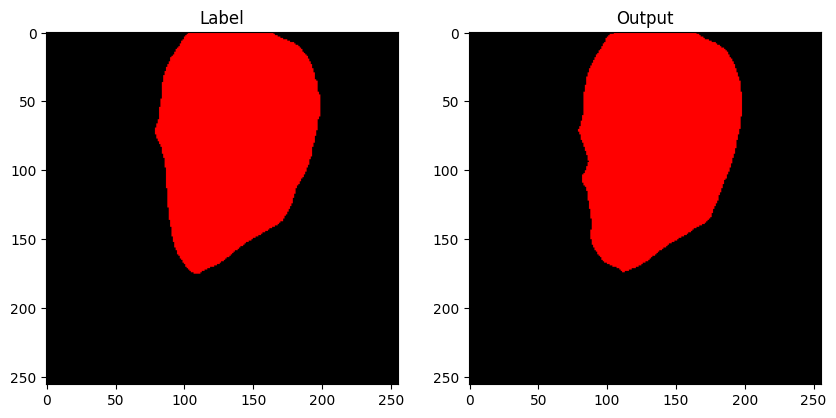

Epoch [186/200], Loss: 0.0712345759


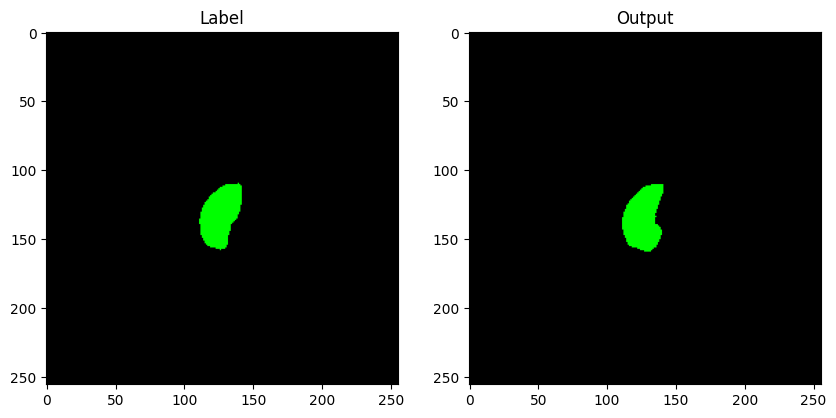

Epoch [187/200], Loss: 0.0839199910


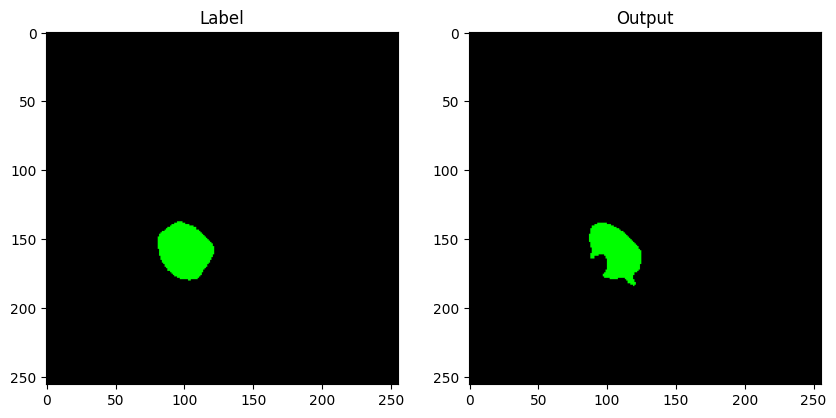

Epoch [188/200], Loss: 0.0842769903


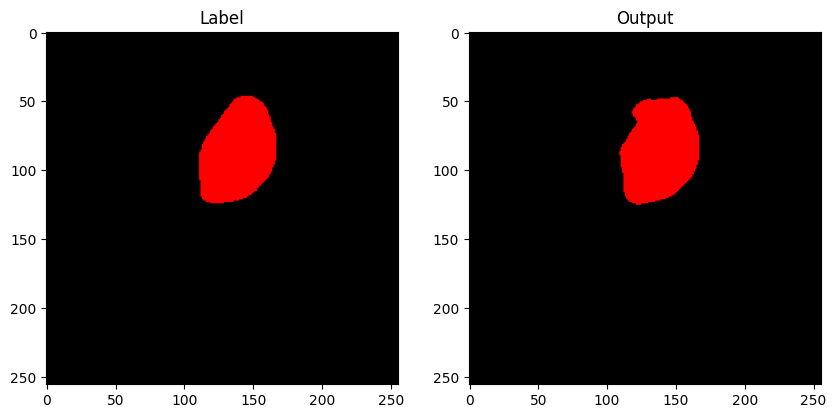

Epoch [189/200], Loss: 0.0819495676


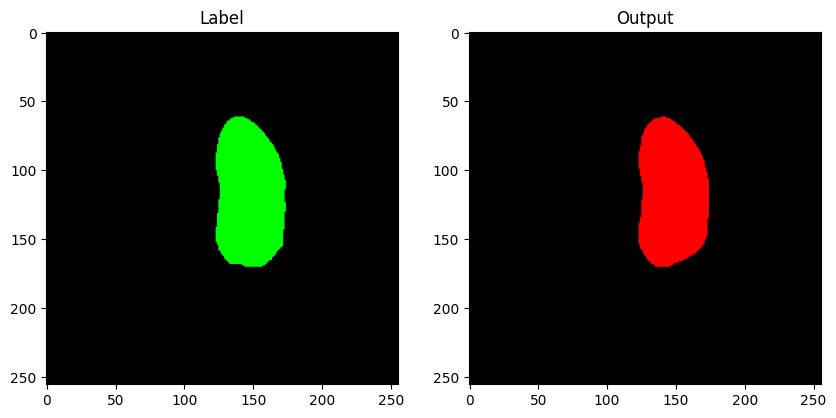

Epoch [190/200], Loss: 0.0831196298


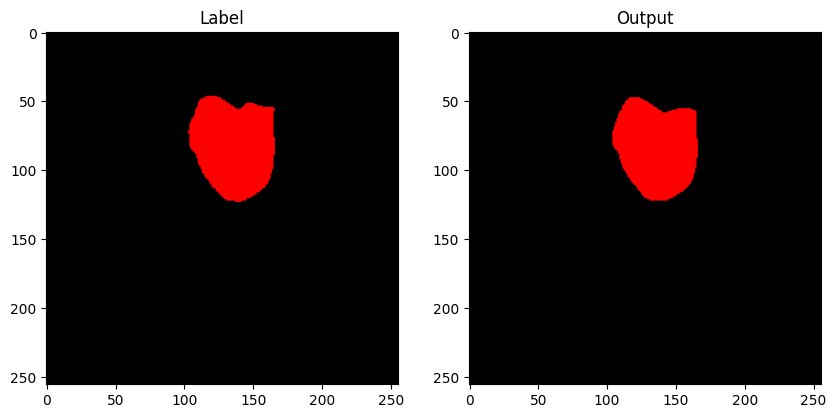

Epoch [191/200], Loss: 0.0957272783


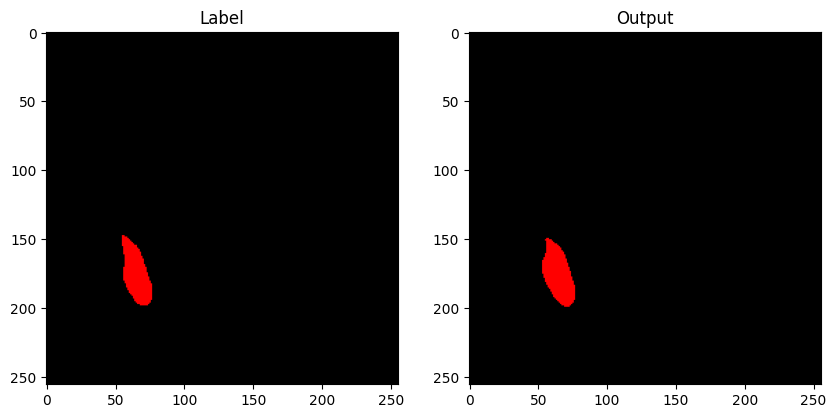

Epoch [192/200], Loss: 0.0710511101


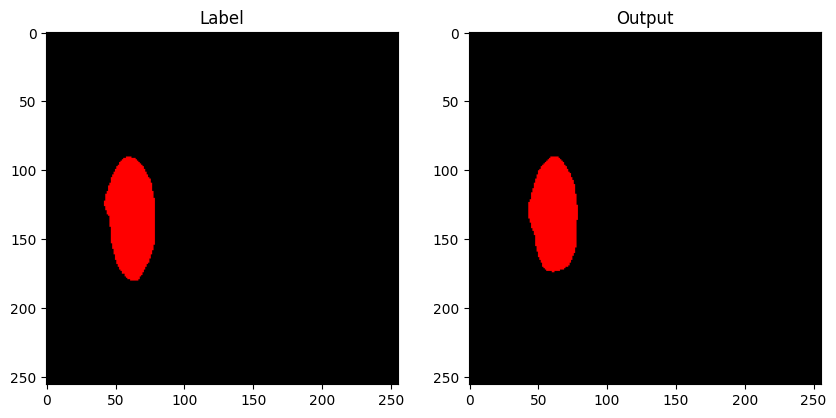

Epoch [193/200], Loss: 0.0845115649


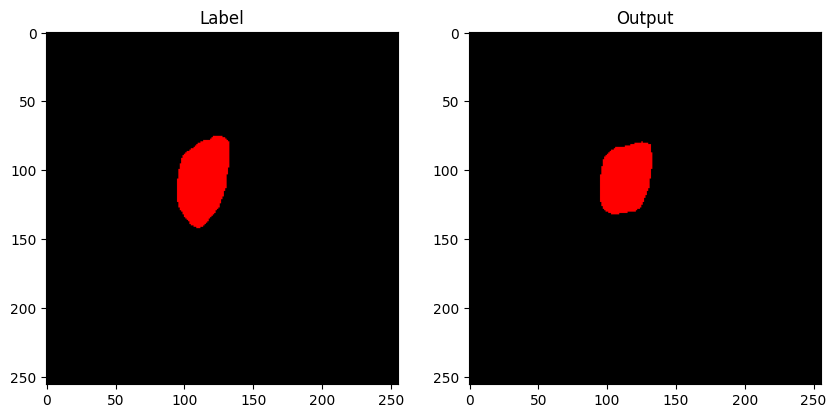

Epoch [194/200], Loss: 0.0842042061


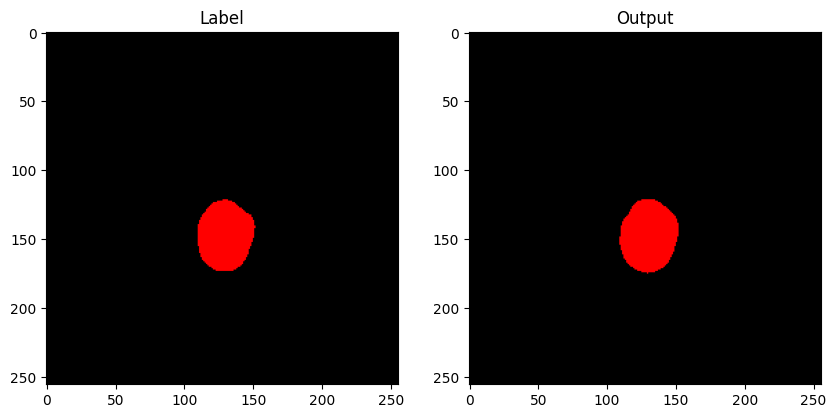

Epoch [195/200], Loss: 0.0846206874


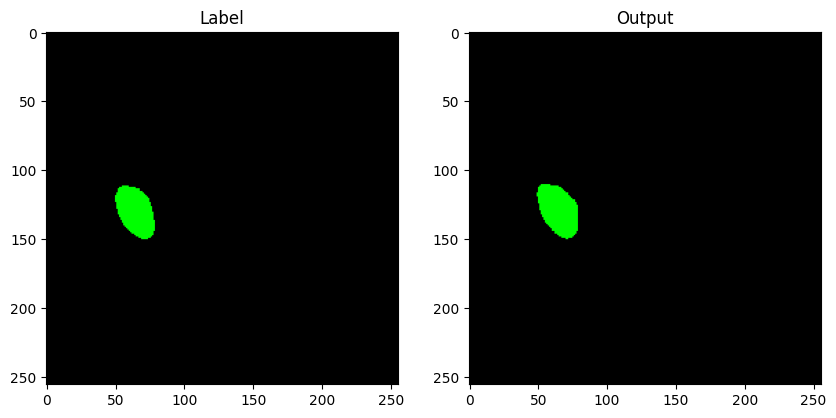

Epoch [196/200], Loss: 0.0833208812


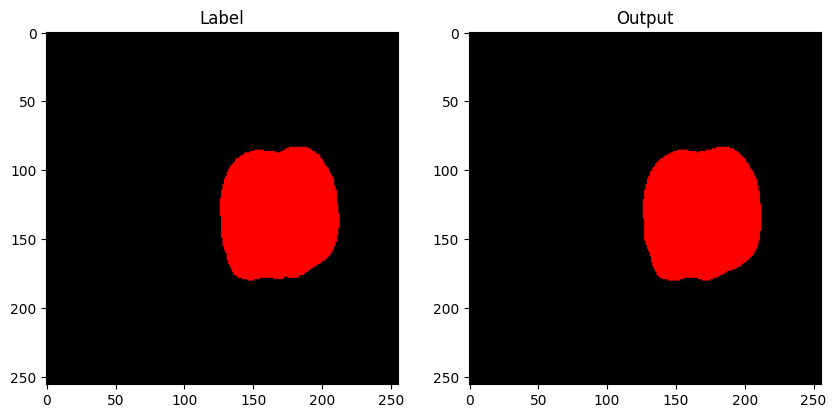

Epoch [197/200], Loss: 0.0805378553


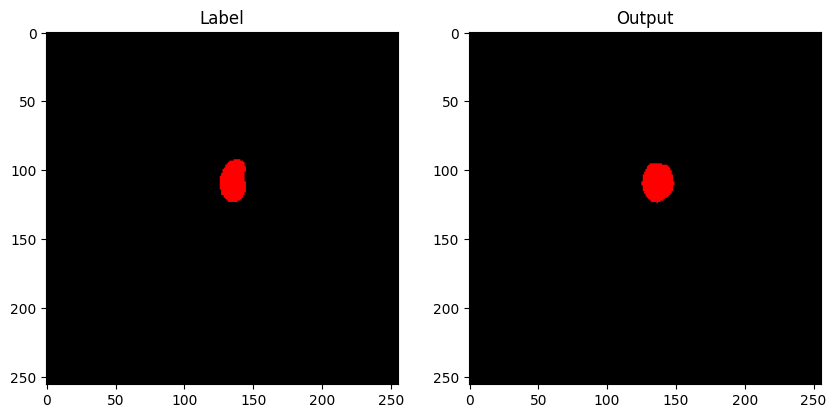

Epoch [198/200], Loss: 0.1083425717


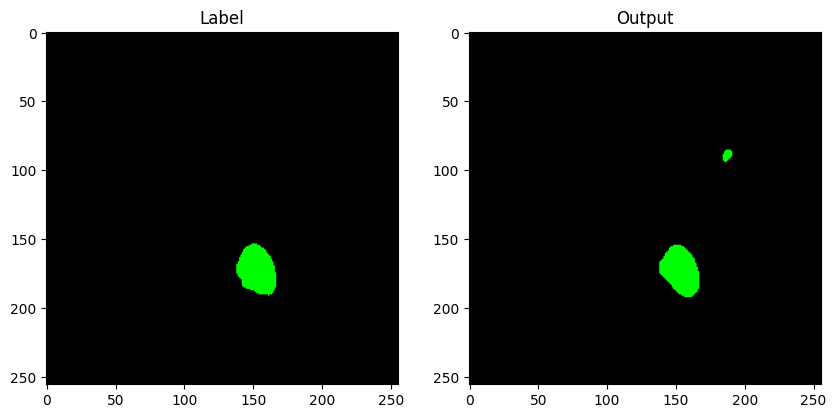

Epoch [199/200], Loss: 0.0851456322


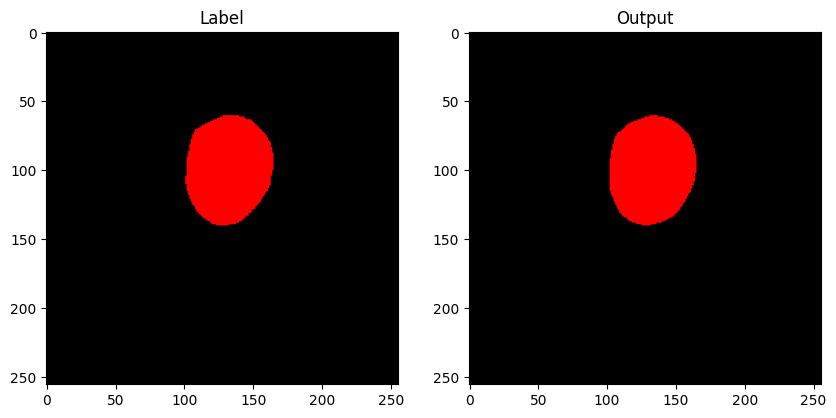

Epoch [200/200], Loss: 0.0837257708


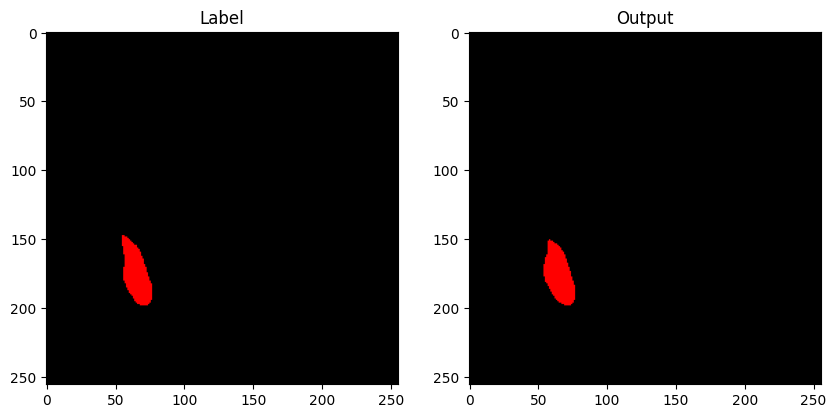

In [16]:
num_epochs = 200

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
best_val_loss = 999

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        labels = labels.squeeze(dim=1).long()
        outputs = model(images)
    
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.squeeze(dim=1).long()
            
            outputs = model(images)

            val_loss += criterion(outputs.float(),labels.long()).item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss/len(val_loader):.10f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = { 
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': val_loss,
        }
        save_path = f'colorization_model.pth'
        torch.save(checkpoint, save_path)
        print('Save new model')
    wandb.log({'Val_loss': val_loss/len(val_loader),
               'Train_loss': train_loss/len(train_loader)
              })

    label = labels[0].cpu().numpy()
    label = mask_to_rgb(label,color_dict)
    outputs[0] = outputs[0].softmax(dim=0)
    output = outputs[0].cpu().numpy()
    output = np.argmax(output, axis=0)
    output = mask_to_rgb(output,color_dict)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(label)
    axs[0].set_title('Label')
    axs[1].imshow(output)
    axs[1].set_title('Output')
    plt.show()

In [17]:
checkpoint = torch.load('/kaggle/working/colorization_model.pth')
model.load_state_dict(checkpoint['model'])
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)

/tmp/ipykernel_23/2183437931.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/working/colorization_model.pth')


UnetPlusPlus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [18]:
!mkdir prediction

In [19]:
trainsize = 256
model.eval()
for i in os.listdir("/kaggle/input/bkai-igh-neopolyp/test/test"):
    img_path = os.path.join("/kaggle/input/bkai-igh-neopolyp/test/test", i)
    ori_img = cv2.imread(img_path)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    ori_w = ori_img.shape[0]
    ori_h = ori_img.shape[1]
    img = cv2.resize(ori_img, (trainsize, trainsize))
    transformed = val_transform(image=img)
    input_img = transformed["image"]
    input_img = input_img.unsqueeze(0).to(device)
    with torch.no_grad():
        output_mask = model.forward(input_img).squeeze(0).cpu().numpy().transpose(1,2,0)
    mask = cv2.resize(output_mask, (ori_h, ori_w))
    mask = np.argmax(mask, axis=2)
    mask_rgb = mask_to_rgb(mask, color_dict)
    mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite("prediction/{}".format(i), mask_rgb) 

In [20]:
import numpy as np
import pandas as pd
import cv2
import os

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 225] = 255
    pixels[pixels <= 225] = 0
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    
    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = '/kaggle/working/prediction'
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']

df.to_csv(r'output.csv', index=False)
print('Done')

/kaggle/working/prediction/ea42b4eebc9e5a87e443434ac60af150.jpeg
/kaggle/working/prediction/5e8f14e1e0ae936de314f2d95e6c487f.jpeg
/kaggle/working/prediction/d6bf62f215f0da4ad3a7ab8df9da7386.jpeg
/kaggle/working/prediction/936de314f2d95e6c487ffa651b477422.jpeg
/kaggle/working/prediction/4417fda8019410b1fcf0625f608b4ce9.jpeg
/kaggle/working/prediction/7b5df7cdf3f33c3ca4d5060a633a8d5b.jpeg
/kaggle/working/prediction/c695325ded465efde988dfb96d081533.jpeg
/kaggle/working/prediction/d6240619ebebe9e9c9d00a4262b4fe4a.jpeg
/kaggle/working/prediction/4ca6160127cd1d5ff99c267599fc487b.jpeg
/kaggle/working/prediction/425b976973f13dd311a65d2b46d0a608.jpeg
/kaggle/working/prediction/98da48d679d7c7c8d3d96fb2b87fbbcf.jpeg
/kaggle/working/prediction/1c0e9082ea2c193ac8d551c149b60f29.jpeg
/kaggle/working/prediction/ff55177a34fc01019eec999fd84e679b.jpeg
/kaggle/working/prediction/677a6b1f2c6d40b3bbba8f6c704801b3.jpeg
/kaggle/working/prediction/395e56a6d9ba9d45c3dbc695325ded46.jpeg
/kaggle/working/predictio